In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

In [83]:
# Client & TPA

TPA = pd.read_excel('../data/Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [86]:
Client.head()

Active  Client ID                               Account Name  Current Eligibles  Eligibles at time of Launch                           Industry  NAICS Code                                  NAICS Description                               Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE                     CLIENT NAME         CLIENT AR                                Cash  TPA
0      Y       4270                  ATLANTIC GENERAL HOSPITAL              418.0                        418.0  Health Care and Social Assistance    622110.0             General Medical and Surgical Hospitals  Maryland Hospital Association/PRIME  2006-03-01              NaT          Affiliate         NaN                             NaN               NaN                                 NaN  NaN
1      Y       1000             SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0    Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...                                  PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
2      Y       3900                              STEPHENS, INC             1000.0                       1000.0              Finance and Insurance    523110.0          Investment Banking and Securities Dealing                                  PPC  2002-02-01              NaT          Affiliate         NaN                             NaN               NaN                                 NaN  NaN
3      Y       2458               FEDERAL MANAGERS ASSOCIATION           200000.0                     200000.0    Federal Government/Associations    813920.0                         Professional Organizations                                  NaN  2016-08-22              NaT            Fed Gov         NaN                             NaN               NaN                                 NaN  NaN
4      Y       5006  INDIANA STATE EMPLOYEES ASSOCIATION - ACH            20000.0                      20000.0      State Government/Associations    813910.0                              Business Associations                                  PPC  2013-08-05              NaT          Affiliate         NaN                             NaN               NaN                                 NaN  NaN

In [89]:
Client.shape

(511, 17)

In [38]:
Client.dtypes

Active                                 object
Client ID                               int64
Account Name                           object
Current Eligibles                     float64
Eligibles at time of Launch           float64
Industry                               object
NAICS Code                            float64
NAICS Description                      object
Broker                                 object
TPA                                    object
Launch Date                    datetime64[ns]
Termination Date               datetime64[ns]
Affiliate/Fed Gov?                     object
dtype: object

In [39]:
Client.isnull().sum(axis=0)

Active                           0
Client ID                        0
Account Name                     0
Current Eligibles               19
Eligibles at time of Launch     12
Industry                         0
NAICS Code                      22
NAICS Description               13
Broker                          42
TPA                            308
Launch Date                      1
Termination Date               346
Affiliate/Fed Gov?               4
dtype: int64

In [87]:
del TPA

In [ ]:
del Client

In [118]:
### 1. Customer Dataset

Customer_old = pd.read_csv('../data/Customer_Data_Request_20191121.csv')
Customer = pd.read_csv('../data/Customer_Data_Request_20191217.csv')

# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)
# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])


# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.'
# Assigned_Spending_Limit has 0
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (~Customer['Customer_Salary'].isin([0, '.'])) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]



 # Formating conversion
Customer['Street1'] = Customer['Street1'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Street2'] = Customer['Street2'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['City'] = Customer['City'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Status'] = Customer['Status'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer.loc[Customer['Customer_Salary']=='.','Customer_Salary']=np.nan
Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)
Customer['Enrollment_Date'] = pd.to_datetime(Customer['Enrollment_Date'].astype(str), format='%m/%d/%Y')
Customer.loc[Customer['Term_Date']=='.','Term_Date'] = np.nan
Customer['Term_Date'] = pd.to_datetime(Customer['Term_Date'].astype(str), format='%m/%d/%Y')

Customer.head()

Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                 Street1 Street2           City State    Zip    Status Term_Date
0           100001115               1000      2014-02-24                   6880.0            230.0          58229.0        Repeat Buyer          1471 N EAST ST     NaN           YORK    PA  17406  EMPLOYED       NaT
1           100001120               1000      2014-02-24                   6520.0            362.0         109245.0        Repeat Buyer         94 BRENTWOOD LN     NaN  VALLEY STREAM    NY  11581  EMPLOYED       NaT
2           100001141               1000      2014-02-25                  10290.0            337.0         127226.0        Repeat Buyer  103 KENILWORTH PARK DR  APT 2B         TOWSON    MD  21204  EMPLOYED       NaT
3           100001158               1000      2014-02-24                   5190.0            419.0          49375.0        Repeat Buyer       1036 BRADDISH AVE     NaN      BALTIMORE    MD  21216  EMPLOYED       NaT
4           100001169               1000      2014-02-24                   7500.0            448.0          69460.0        Repeat Buyer       3915 W ROGERS AVE     NaN      BALTIMORE    MD  21215  EMPLOYED       NaT

In [126]:
# Check Missing Values
Customer.isnull().sum(axis=0)

Unique_Customer_ID                  0
Unique_Company_ID                   0
Enrollment_Date                     0
Assigned_Spending_Limit             0
Customer_Tenure                   110
Customer_Salary                 67794
Prior_Customer_Flag                 0
Street1                            71
Street2                        483722
City                               68
State                               1
Zip                                 6
Status                            308
Term_Date                      501105
Active                          28605
Client ID                       28605
Account Name                    28605
Current Eligibles              115920
Eligibles at time of Launch     34855
Industry                        28605
NAICS Code                     111097
NAICS Description              109565
Broker                         201804
Launch Date                     32518
Termination Date               566580
Affiliate/Fed Gov?              32824
CLIENT CODE 

In [127]:
Customer.dtypes

Unique_Customer_ID                      int64
Unique_Company_ID                       int64
Enrollment_Date                datetime64[ns]
Assigned_Spending_Limit               float64
Customer_Tenure                       float64
Customer_Salary                       float64
Prior_Customer_Flag                    object
Street1                                object
Street2                                object
City                                   object
State                                  object
Zip                                    object
Status                                 object
Term_Date                      datetime64[ns]
Active                                 object
Client ID                             float64
Account Name                           object
Current Eligibles                     float64
Eligibles at time of Launch           float64
Industry                               object
NAICS Code                            float64
NAICS Description                 

In [128]:
Customer.shape

(619753, 31)

In [122]:
Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')

In [123]:
### 2. Performance Dataset

Perf_11 = pd.read_csv('../data/Performance_Data_Request_20191217.csv')
Perf = pd.read_csv('../data/Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns = {' Unique_Order_ID':'Unique_Order_ID','Order_date':'Order_Date'},inplace = True)
Perf.rename(columns = {'items_ordered':'Items_Ordered','EMPSTATUS':'Customer_Status'},inplace = True)
Perf = Perf.append(Perf_11, ignore_index=True)

# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID','Year_and_Month'],ascending = [False,True])

# Create new column - YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

Perf.loc[Perf['Date_account_went_delinquent']=='.','Date_account_went_delinquent'] = np.nan
Perf['Date_account_went_delinquent'] = pd.to_datetime(Perf['Date_account_went_delinquent'].astype(str), format='%m/%d/%Y')


# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Treat 151+ ad CO as BAD
Perf['Bad']=0
Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
# Create a flag Ever_Bad to distinguish first time bad and non-first time bad 
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os Loss, using Losses for C/O orders and Current_Balance for 151+ orders
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']


# Perf['Enrollment_Date'] = pd.to_datetime(Perf['Enrollment_Date'].astype(str), format = '%m/%d/%Y')

# Some cleaning here
Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=np.nan
Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount']!=0)]

Perf.loc[Perf['Payments_Due']=='.','Payments_Due']=np.nan
Perf['Payments_Due'] = Perf['Payments_Due'].astype(float)


Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')

In [116]:
Perf[Perf['Unique_Company_ID'].isnull()]['Unique_Customer_ID'].nunique()

70215

In [111]:
Customer.shape[0]

549500

In [6]:
Perf.shape

(38857220, 44)

In [125]:
Perf.dtypes

Unique_Order_ID                            object
Unique_Customer_ID                          int64
Order_Amount                              float64
Product_Markup                             object
Payments_Due                              float64
Current_Balance                           float64
Date_account_went_delinquent       datetime64[ns]
Default_Status                             object
Delinquency_Bucket                         object
Losses                                    float64
Auto_Pay_Enrollment                        object
Order_Closed_Flag                          object
Type_of_Backup_Payment                     object
Spending_Limit_at_time_of_Order            object
Tenure_at_time_of_Order                    object
Salary_at_time_of_Order                    object
Street1_x                                  object
Street2_x                                  object
City_x                                     object
State_x                                    object


In [124]:
Perf.isnull().sum(axis=0)

Unique_Order_ID                           0
Unique_Customer_ID                        0
Order_Amount                              0
Product_Markup                            0
Payments_Due                           8602
Current_Balance                           0
Date_account_went_delinquent       29665892
Default_Status                            0
Delinquency_Bucket                        0
Losses                                    0
Auto_Pay_Enrollment                       0
Order_Closed_Flag                         0
Type_of_Backup_Payment                    0
Spending_Limit_at_time_of_Order           0
Tenure_at_time_of_Order                   0
Salary_at_time_of_Order                   0
Street1_x                               123
Street2_x                          29867878
City_x                                   27
State_x                                  12
Zip_x                                    45
Items_Ordered                         44367
Year_and_Month                  

In [193]:
x = Perf.groupby('Unique_Order_ID').head(1)

In [194]:
x['diff'] = x['Order_Amount']-x['Current_Balance']

In [200]:
x['diff'] = abs(x['diff'])

In [201]:
x[['Order_Amount','Current_Balance','diff']].head(100)

Order_Amount  Current_Balance     diff
0           349.57           336.00    13.57
22          333.05           320.00    13.05
45          560.49           560.04     0.45
66          339.07           339.04     0.03
78         2018.74          2018.64     0.10
99          821.86           821.60     0.26
113        1134.35          1068.69    65.66
126          40.00          1134.12  1094.12
139         587.49           587.08     0.41
148        1871.63          1871.48     0.15
161         603.05           602.68     0.37
174        1329.23          1278.00    51.23
187         303.37           297.33     6.04
200         752.69           723.50    29.19
212         889.07           871.59    17.48
225        2396.69          2241.14   155.55
238         401.72           401.44     0.28
251         675.86           675.48     0.38
266        1219.58          1219.40     0.18
279         329.84           329.68     0.16
291         531.80           531.44     0.36
312         607.46           607.36     0.10
325         447.26           447.20     0.06
338         681.18           680.68     0.50
351        1435.39          1435.20     0.19
365        1222.28          1222.00     0.28
379         747.94           747.76     0.18
390        1204.99          1204.84     0.15
405        1169.11          1103.22    65.89
423         830.38           829.92     0.46
436         390.31           390.00     0.31
449         534.04           534.04     0.00
462        1183.74          1183.52     0.22
475         363.31           362.96     0.35
488         725.26           724.88     0.38
503         435.64           435.24     0.40
512         870.01           869.96     0.05
526        1079.13          1079.00     0.13
541         682.06           659.18    22.88
555         616.67           572.48    44.19
568        1072.72          1039.14    33.58
581         423.47           423.28     0.19
594        3078.10          3077.88     0.22
608         848.43           848.12     0.31
621         892.25           891.80     0.45
635         518.51           518.44     0.07
649        1242.61          1242.28     0.33
663         341.53           341.12     0.41
677        3174.09          3174.08     0.01
691        1235.86          1235.52     0.34
705         971.24           970.84     0.40
718        2419.98          2416.29     3.69
731        1372.69          1372.28     0.41
744         335.28           334.88     0.40
757        1038.29          1037.92     0.37
770         736.33           736.32     0.01
789         491.24           472.00    19.24
802        1299.08          1298.96     0.12
816        1390.36          1389.96     0.40
839         660.87           660.40     0.47
862        1542.08          1541.80     0.28
875         789.99           789.88     0.11
889         694.36           694.20     0.16
903        1081.55          1081.08     0.47
917         543.73           526.13    17.60
930        1164.74          1123.13    41.61
943         641.35           604.17    37.18
956        1220.09          1219.92     0.17
969         547.30           547.04     0.26
982         981.24           981.24     0.00
995        3308.61          3179.80   128.81
1011       1327.49          1327.04     0.45
1024        412.94           412.88     0.06
1037       2415.85          2415.40     0.45
1052       1844.42          1559.50   284.92
1067       1221.77          1174.50    47.27
1081        379.02           356.72    22.30
1092       1112.77          1112.28     0.49
1105       1297.33          1296.88     0.45
1118        424.99           400.33    24.66
1131        514.94           495.00    19.94
1140        923.01           923.00     0.01
1150        417.68           417.56     0.12
1168       1559.99          1559.48     0.51
1186       1370.19          1369.68     0.51
1201       1204.99          1204.84     0.15
1217       1108.74          1108.64     0.10
1230        769.33           754.25    15.08
1

In [210]:
x['diff_pct'] = x['diff']/x['Order_Amount']

In [202]:
x['diff'].describe()

count    3.291432e+06
mean     6.711874e+01
std      2.327886e+02
min      0.000000e+00
25%      0.000000e+00
50%      2.500000e-01
75%      4.291000e+01
max      1.038939e+04
Name: diff, dtype: float64

In [211]:
x['diff_pct'].describe()

count    3.291432e+06
mean     1.219510e-01
std      5.867567e+01
min     -8.092820e+01
25%      0.000000e+00
50%      5.442917e-04
75%      4.691484e-02
max      1.060270e+05
Name: diff_pct, dtype: float64

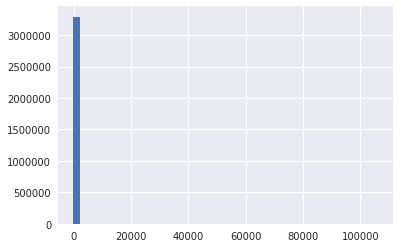

In [212]:
x['diff_pct'].hist(bins=50)

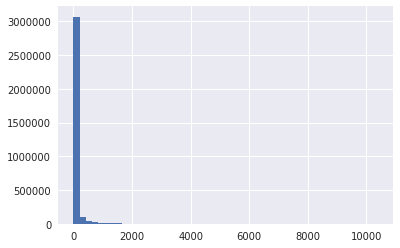

In [208]:
x['diff'].hist(bins=50)

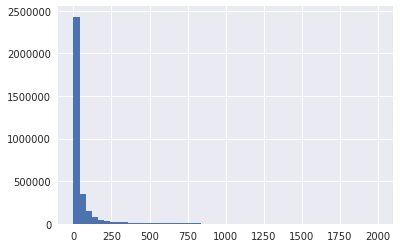

In [209]:
x[x['diff']<2000]['diff'].hist(bins=50)

In [192]:
# Perf[Perf['Unique_Company_ID'].isnull()]#['Unique_Customer_ID']#.nunique()

In [97]:
349.57/6.72

52.01934523809524

In [103]:
(336-309.12)/6.72

3.9999999999999996

In [159]:
fed_cust = Customer[Customer['Unique_Company_ID']==2049]

In [172]:
fed_cust.head()

Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag            Street1  Street2       City State    Zip    Status Term_Date Active  Client ID                                       Account Name  Current Eligibles  Eligibles at time of Launch                         Industry  NAICS Code NAICS Description Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE CLIENT NAME CLIENT AR Cash  TPA         YM
9             100001202               2049      2014-02-25                   9660.0            397.0         134578.0        Repeat Buyer    3637 GELSTON DR      NaN  BALTIMORE    MD  21229  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN 2014-02-01
26            100003117               2049      2014-02-25                   9660.0            182.0          81282.0        Repeat Buyer   15210 AMBERLY DR  APT 311      TAMPA    FL  33647  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN 2014-02-01
116           100004192               2049      2014-02-24                   3590.0            596.0          46763.0        Repeat Buyer     1320 W 98TH ST      NaN    CHICAGO    IL  60643  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN 2014-02-01
131           100004367               2049      2014-02-24                   6245.0            292.0          89258.0        Repeat Buyer   3734 CLARINTH RD      NaN  BALTIMORE    MD  21215  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN 2014-02-01
142           100007885               2049      2014-02-24                   4200.0            478.0          39168.0        Repeat Buyer  3801 GLENMORE AVE      NaN  BALTIMORE    MD  21206  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN 2014-02-01

In [171]:
fed_cust['YM'] = fed_cust['Enrollment_Date'].apply(lambda x: str(x)[:7])
fed_cust['YM'] = pd.to_datetime(fed_cust['YM'].astype(str), format = '%Y-%m')

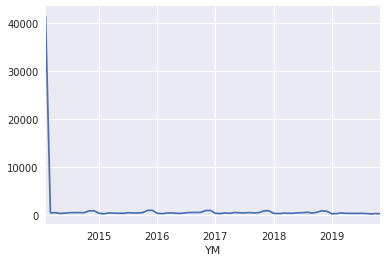

In [177]:
fed_cust.groupby('YM')['Unique_Customer_ID'].size().plot()

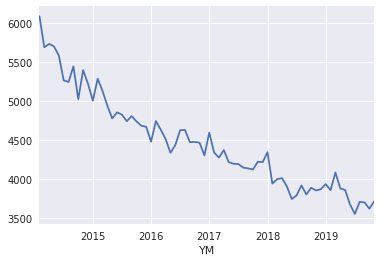

In [174]:
fed_cust.groupby('YM')['Assigned_Spending_Limit'].mean().plot()

In [178]:
fed_bad.head()

Unique_Order_ID  Unique_Customer_ID  Order_Amount Product_Markup  Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket   Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment Spending_Limit_at_time_of_Order Tenure_at_time_of_Order Salary_at_time_of_Order           Street1_x Street2_x        City_x State_x    Zip_x                                      Items_Ordered Year_and_Month Customer_Status  Order_Date      YQ  Year  Payment_Order  Bad  Ever_Bad  2os_loss  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag           Street1_y Street2_y       City_y State_y  Zip_y    Status Term_Date Active  Client ID                                       Account Name  Current Eligibles  Eligibles at time of Launch                         Industry  NAICS Code NAICS Description Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE CLIENT NAME CLIENT AR Cash  TPA
6890024        27043023           307757017       2898.89              .        111.50              0.0                   2019-10-31      Chargeoff            000-000  2898.89                  PA                 Y                    ACH                               .                       .                       .  77 LOCUST HILL AVE   APT 714       YONKERS      NY  10701.0  SquareTrade 1-Year Phone Warranty Plus Acciden...     2019-11-01        Employed  07/01/2019  2019Q4  2019            5.0    1         1   2898.89             2049.0      2019-07-01                   4050.0            268.0         46928.00     First Time Byer  77 LOCUST HILL AVE   APT 714      YONKERS      NY  10701  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN
6959546        26909094           307664010       2991.87              .        115.08              0.0                   2019-10-31      Chargeoff            000-000  2991.87                  PA                 Y                    ACH                           31.50                     241                35863.88       122 N 3RD AVE    APT 3G  MOUNT VERNON      NY  10550.0  Apple MacBook Pro with Touch Bar (13.3in Retin...     2019-11-01        Employed  06/21/2019  2019Q4  2019            6.0    1         1   2991.87             2049.0      2019-06-04                   3150.0            246.0         35863.88     First Time Byer      377 N BROADWAY   APT 405      YONKERS      NY  10701  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN
6974305        26888067           305628789       3146.14              .        121.01              0.0                   2019-08-31      Chargeoff            000-000  3025.14                  PA                 Y                     CC                           33.00                      32                  421.26        4306 ECHO CT         B       LA MESA      CA  91941.0  Apple iPhone Xr (6.1in 128GB Unlocked Red); Ap...     2019-10-01        Employed  06/19/2019  2019Q4  2019            5.0    1         1   3025.14             2049.0      2018-09-13                   3300.0             37.0         42126.00        Repeat Buyer        4306 ECHO CT         B      LA MESA      CA  91941  EMPLOYED       NaT      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0  Federal Government/Associations         NaN               NaN    NaN  2002-07-01              NaT            Fed Gov         NaN         NaN       NaN  NaN  NaN
6986329        26881

In [141]:
df_17 = Perf[Perf['Year']>=2017]
fed = df_17[df_17['Unique_Company_ID']==2049]
fed_bad = fed[(fed['Bad']==1) & (fed['Ever_Bad']<=1)]
# fed_good = fed[~fed['Unique_Customer_ID'].isin(fed_bad['Unique_Order_ID'].tolist())]
fed_good = fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)

In [148]:
# fed_bad.groupby('Unique_Order_ID')['Year_and_Month'].size()

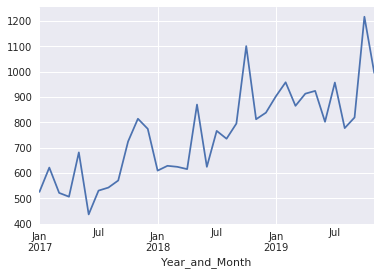

In [181]:
fed_bad.groupby('Year_and_Month')['Unique_Customer_ID'].size().plot()

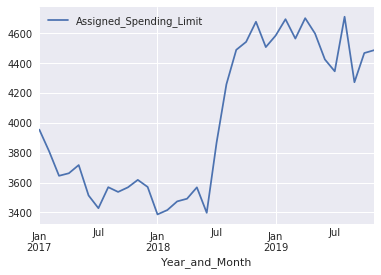

In [183]:
fed_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot()

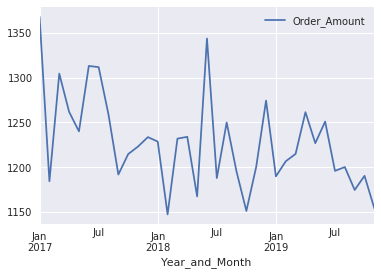

In [187]:
fed_bad.groupby('Year_and_Month').agg({'Order_Amount':'mean'}).plot()

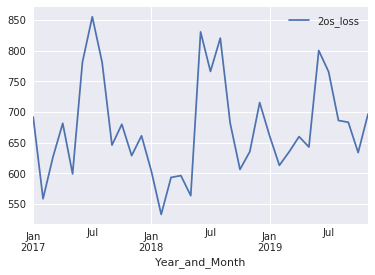

In [185]:
fed_bad.groupby('Year_and_Month').agg({'2os_loss':'mean'}).plot()

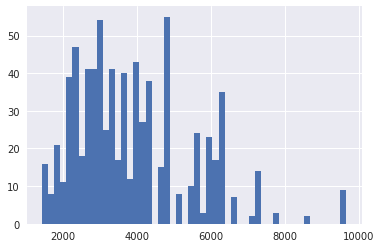

In [151]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-07-01')]['Assigned_Spending_Limit'].hist(bins=50)

In [157]:
fed_bad[(fed_bad['Year_and_Month']==pd.to_datetime('2018-09-01')) & (fed_bad['Assigned_Spending_Limit']<=6500)]['Assigned_Spending_Limit'].describe()

count     686.000000
mean     3864.176385
std      1195.680217
min         0.000000
25%      3000.000000
50%      3740.000000
75%      4790.000000
max      6245.000000
Name: Assigned_Spending_Limit, dtype: float64

In [154]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-06-01')]['Assigned_Spending_Limit'].describe()

count     624.000000
mean     3397.924679
std      1222.538433
min      1430.000000
25%      2510.000000
50%      3120.000000
75%      4390.000000
max      6245.000000
Name: Assigned_Spending_Limit, dtype: float64

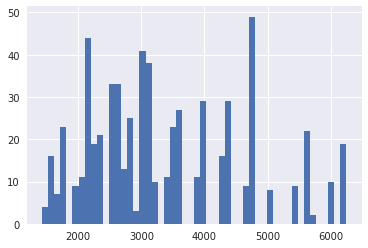

In [152]:
fed_bad[fed_bad['Year_and_Month']==pd.to_datetime('2018-06-01')]['Assigned_Spending_Limit'].hist(bins=50)

### Industry Risk Analysis

- Industry Distribution

In [29]:
Client.pivot_table(values='Client ID', index='Industry',
                   columns='Active', aggfunc='count', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active                                            Consolidated  Inactive  Split  Terminated    Y  All
Industry                                                                                             
All                                                         10         2      5         163  334  514
Health Care and Social Assistance                            4         0      0          42   94  140
Manufacturing                                                0         0      3          28   47   78
Retail Trade                                                 1         0      0           8   26   35
Educational Services                                         0         1      0           8   21   30
Professional, Scientific, and Technical Services             1         0      0           9   21   31
Local Government/Associations                                1         1      0           7   18   27
Finance and Insurance                                        0         0      0           5   15   20
State Government/Associations                                2         0      0           5   12   19
Wholesale Trade                                              0         0      0           4   10   14
Federal Government/Associations                              0         0      0           3    9   12
Transportation and Warehousing                               1         0      0           4    9   14
Nursing and Residential Care Facilities                      0         0      0           6    9   15
Accommodation and Food Services                              0         0      0           7    7   14
Information                                                  0         0      1           6    7   14
Administrative and Support                                   0         0      1           9    7   17
Other Services (except Public Administration)                0         0      0           4    7   11
Real Estate and Rental and Leasing                           0         0      0           4    4    8
Utilities                                                    0         0      0           1    2    3
Mining, Quarrying, and Oil and Gas Extraction                0         0      0           1    2    3
Retail                                                       0         0      0           0    1    1
Retail & Wholesale Trade                                     0         0      0           0    1    1
Management of Companies and Enterprises                      0         0      0           1    1    2
Machinery                                                    0         0      0           0    1    1
Healthcare                                                   0         0      0           0    1    1
Engineering                                                  0         0      0           0    1    1
Construction                                                 0         0      0           0    1    1
Arts, Entertainment, and Recreation                          0         0      0           1    0    1

In [30]:
Customer.pivot_table(values='Unique_Customer_ID', index='Industry',
                     columns='Active', aggfunc='count', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active                                            Consolidated  Split  Terminated       Y     All
Industry                                                                                         
All                                                       1043   2975       55509  526777  586304
Health Care and Social Assistance                          191      0        5768  138554  144513
Federal Government/Associations                              0      0          89   92410   92499
Retail Trade                                                59      0        2217   86388   88664
Manufacturing                                                0   2002        3507   41084   46593
State Government/Associations                              793      0        4719   40312   45824
Accommodation and Food Services                              0      0        2818   17844   20662
Transportation and Warehousing                               0      0          82   15527   15609
Finance and Insurance                                        0      0        1171   15010   16181
Other Services (except Public Administration)                0      0        2059   14828   16887
Nursing and Residential Care Facilities                      0      0        5831   13145   18976
Information                                                  0     72       24205   11865   36142
Local Government/Associations                                0      0         703   11190   11893
Educational Services                                         0      0         171    8161    8332
Professional, Scientific, and Technical Services             0      0         290    6556    6846
Wholesale Trade                                              0      0         385    6468    6853
Administrative and Support                                   0    901         636    5670    7207
Management of Companies and Enterprises                      0      0         226     935    1161
Real Estate and Rental and Leasing                           0      0         279     316     595
Utilities                                                    0      0          14     199     213
Healthcare                                                   0      0           0     170     170
Construction                                                 0      0           0      58      58
Mining, Quarrying, and Oil and Gas Extraction                0      0         298      57     355
Retail & Wholesale Trade                                     0      0           0      21      21
Machinery                                                    0      0           0       6       6
Engineering                                                  0      0           0       3       3
Arts, Entertainment, and Recreation                          0      0          41       0      41

In [31]:
Customer.pivot_table(values='Assigned_Spending_Limit', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active                                            Consolidated        Split   Terminated            Y          All
Industry                                                                                                          
Mining, Quarrying, and Oil and Gas Extraction         0.000000     0.000000  2284.530201  7005.775439  3042.589296
Construction                                          0.000000     0.000000     0.000000  6964.210345  6964.210345
Transportation and Warehousing                        0.000000     0.000000   598.963415  6015.680106  5987.224037
Federal Government/Associations                       0.000000     0.000000  2995.056180  5559.699437  5557.231808
Utilities                                             0.000000     0.000000  1272.142857  5339.096482  5071.784977
State Government/Associations                      3536.891551     0.000000  2019.876033  5104.373264  4759.602937
Health Care and Social Assistance                  4064.031414     0.000000  1644.881380  5031.170057  4894.733636
Engineering                                           0.000000     0.000000     0.000000  4740.000000  4740.000000
Educational Services                                  0.000000     0.000000  1765.969591  4642.573716  4583.536354
Finance and Insurance                                 0.000000     0.000000  1505.819812  4615.993544  4390.913918
Retail & Wholesale Trade                              0.000000     0.000000     0.000000  4557.057143  4557.057143
All                                                3653.817833  4245.018487  3204.795003  4431.675433  4313.188239
Nursing and Residential Care Facilities               0.000000     0.000000  2563.791014  4334.526208  3790.409591
Manufacturing                                         0.000000  3907.370130  2233.593955  4026.173269  3886.143232
Local Government/Associations                         0.000000     0.000000  1562.188620  3986.421403  3843.124031
Wholesale Trade                                       0.000000     0.000000   830.085195  3918.269975  3744.776448
Information                                           0.000000  9546.458333  4722.490188  3626.463472  4372.287342
Professional, Scientific, and Technical Services      0.000000     0.000000  1100.620690  3596.454957  3490.730164
Management of Companies and Enterprises               0.000000     0.000000   497.353982  3481.524064  2900.626184
Healthcare                                            0.000000     0.000000     0.000000  3398.081176  3398.081176
Administrative and Support                            0.000000  4571.620422  1161.083648  3234.481041  3218.674442
Accommodation and Food Services                       0.000000     0.000000  3178.590490  2885.887374  2925.807874
Retail Trade                                       3897.406780     0.000000  1066.237348  2849.562381  2805.668481
Machinery                                             0.000000     0.000000     0.000000  2560.183333  2560.183333
Real Estate and Rental and Leasing                    0.000000     0.000000  1758.996416  2546.930063  2177.462017
Other Services (except Public Administration)         0.000000     0.000000  2044.786304  2408.862955  2364.471777
Arts, Entertainment, and Recreation                   0.000000     0.000000  2327.951220     0.000000  2327.951220

In [32]:
Customer.pivot_table(values='Customer_Salary', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active                                            Consolidated          Split    Terminated              Y            All
Industry                                                                                                                 
Accommodation and Food Services                       0.000000       0.000000  37732.510128  296375.297181  262885.165205
Construction                                          0.000000       0.000000      0.000000   94452.379310   94452.379310
Mining, Quarrying, and Oil and Gas Extraction         0.000000       0.000000  47052.165909   81481.575746   57435.638717
Engineering                                           0.000000       0.000000      0.000000   61430.280000   61430.280000
Federal Government/Associations                       0.000000       0.000000  56085.494691   59861.636879   59858.124431
Management of Companies and Enterprises               0.000000       0.000000  34329.788235   55653.937463   54550.964227
All                                               33705.076894   40809.563462  40255.687306   54381.895265   53277.954328
Finance and Insurance                                 0.000000       0.000000  39283.859539   51807.226921   51437.868178
Utilities                                             0.000000       0.000000  79999.500000   51646.998207   51951.863817
Educational Services                                  0.000000       0.000000  56273.942350   50723.877074   50787.337253
Transportation and Warehousing                        0.000000       0.000000  20000.000000   48583.328213   48496.945984
Professional, Scientific, and Technical Services      0.000000       0.000000  35948.932266   47795.291875   47566.238396
Retail & Wholesale Trade                              0.000000       0.000000      0.000000   45910.416667   45910.416667
Local Government/Associations                         0.000000       0.000000  51384.652423   45558.600689   45650.460407
Information                                           0.000000  100828.769306  41630.892617   45306.707599   42647.726396
Health Care and Social Assistance                 37141.857853       0.000000  39611.043498   45210.538663   45110.146794
Other Services (except Public Administration)         0.000000       0.000000  38570.754071   43132.637290   42716.939056
Wholesale Trade                                       0.000000       0.000000  32754.345000   43002.326260   42870.012945
Nursing and Residential Care Facilities               0.000000       0.000000  35061.236129   42029.719189   40182.731759
State Government/Associations                     32147.925039       0.000000  37062.379404   41731.970702   41377.601260
Manufacturing                                         0.000000   36999.160330  44114.883315   40345.803885   40334.991266
Healthcare                                            0.000000       0.000000      0.000000   40189.286471   40189.286471
Administrative and Support                            0.000000   44479.978835  51797.652967   39006.167447   40128.890289
Real Estate and Rental and Leasing                    0.000000       0.000000  42604.345096   34313.467687   36411.402603
Retail Trade                                      39602.327458       0.000000  37010.070182   34205.794118   34241.193264
Machinery                                             0.000000       0.000000      0.000000   29737.568333   29737.568333
Arts, Entertainment, and Recreation                   0.000000       0.000000  49037.036563       0.000000   49037.036563

In [33]:
(Customer.pivot_table(values='Assigned_Spending_Limit', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True)/Customer.pivot_table(values='Customer_Salary', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True)).sort_values('Y',ascending = False)

Active                                            Consolidated     Split  Terminated         Y       All
Industry                                                                                                
Transportation and Warehousing                             NaN       NaN    0.029948  0.123822  0.123456
State Government/Associations                         0.110019       NaN    0.054499  0.122313  0.115028
Health Care and Social Assistance                     0.109419       NaN    0.041526  0.111283  0.108506
Utilities                                                  NaN       NaN    0.015902  0.103377  0.097625
Nursing and Residential Care Facilities                    NaN       NaN    0.073123  0.103130  0.094329
Manufacturing                                              NaN  0.105607    0.050631  0.099792  0.096347
Retail & Wholesale Trade                                   NaN       NaN         NaN  0.099260  0.099260
Federal Government/Associations                            NaN       NaN    0.053402  0.092876  0.092840
Educational Services                                       NaN       NaN    0.031382  0.091526  0.090250
Wholesale Trade                                            NaN       NaN    0.025343  0.091118  0.087352
Finance and Insurance                                      NaN       NaN    0.038332  0.089099  0.085363
Local Government/Associations                              NaN       NaN    0.030402  0.087501  0.084186
Machinery                                                  NaN       NaN         NaN  0.086093  0.086093
Mining, Quarrying, and Oil and Gas Extraction              NaN       NaN    0.048553  0.085980  0.052974
Healthcare                                                 NaN       NaN         NaN  0.084552  0.084552
Retail Trade                                          0.098414       NaN    0.028809  0.083306  0.081938
Administrative and Support                                 NaN  0.102779    0.022416  0.082922  0.080208
All                                                   0.108406  0.104020    0.079611  0.081492  0.080956
Information                                                NaN  0.094680    0.113437  0.080043  0.102521
Engineering                                                NaN       NaN         NaN  0.077161  0.077161
Professional, Scientific, and Technical Services           NaN       NaN    0.030616  0.075247  0.073387
Real Estate and Rental and Leasing                         NaN       NaN    0.041287  0.074225  0.059802
Construction                                               NaN       NaN         NaN  0.073733  0.073733
Management of Companies and Enterprises                    NaN       NaN    0.014488  0.062557  0.053173
Other Services (except Public Administration)              NaN       NaN    0.053014  0.055848  0.055352
Accommodation and Food Services                            NaN       NaN    0.084240  0.009737  0.011130
Arts, Entertainment, and Recreation                        NaN       NaN    0.047473       NaN  0.047473

In [25]:
# Customer[Customer['Unique_Company_ID']==2049].shape

In [20]:
def risk_ind(df):
    total_vol = df.pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    total_vol['Flag'] = 'On_Book_Total_Vol'
    # ---------------------------------------------------------------- #
    new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
                                                             'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_order_vol['Flag'] = 'New_Order_Total_Vol'
    # ---------------------------------------------------------------- #
    avg_new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Industry'], aggfunc='mean').reset_index().rename_axis(None, axis=1)
    avg_new_order_vol['Flag'] = 'Avg_New_Order_Amount'
    # ---------------------------------------------------------------- #
    new_bad_order_vol = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Order_Amount', index='Year_and_Month',
                                                                                 columns=['Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_order_vol['Flag'] = 'New_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                              columns=['Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    bad_loss['Flag'] = 'On_Book_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    new_bad_loss = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Year_and_Month', columns=[
        'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_loss['Flag'] = 'New_Bad_Total_Loss'
    # ---------------------------------------------------------------- #
    new_bad_unit = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
                                                                            columns=['Industry'], aggfunc='count').reset_index().rename_axis(None, axis=1)
    new_bad_unit['Flag'] = 'New_Bad_Unit'
#     good_unit = df[~((df['Bad'] == 1) & (df['Ever_Bad'] <= 1))].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
#                                                                 columns=[Industry], aggfunc='count').reset_index().rename_axis(None, axis=1)
    final = pd.concat([total_vol, new_order_vol, avg_new_order_vol,
                       new_bad_order_vol, bad_loss, new_bad_loss, new_bad_unit])
    final.to_csv('../data/Industry.csv', index=False)

    return final

In [9]:
df = Perf[Perf['Year']>=2015]

In [26]:
risk_ind(df)

Accommodation and Food Services  Administrative and Support  Arts, Entertainment, and Recreation   Construction  Educational Services  Engineering  Federal Government/Associations  Finance and Insurance                   Flag  Health Care and Social Assistance     Healthcare   Information  Local Government/Associations     Machinery  Management of Companies and Enterprises  Manufacturing  Mining, Quarrying, and Oil and Gas Extraction  Nursing and Residential Care Facilities  Other Services (except Public Administration)  Professional, Scientific, and Technical Services  Real Estate and Rental and Leasing  Retail & Wholesale Trade  Retail Trade  State Government/Associations  Transportation and Warehousing      Utilities  Wholesale Trade Year_and_Month
0                      3.823223e+06                2.476537e+06                                  NaN            NaN          2.899744e+06          NaN                     9.003275e+07           7.731404e+06      On_Book_Total_Vol                       6.621384e+07            NaN  2.119806e+07                   4.010148e+06           NaN                             6.367588e+04   1.788795e+07                                  434217.380000                             1.172460e+07                                   1.175341e+07                                      1.672183e+06                       262583.930000                       NaN  3.431059e+07                   3.782970e+07                    1.054073e+07  125747.760000     1.379693e+06     2015-01-01
1                      3.530523e+06                2.316810e+06                                  NaN            NaN          2.891871e+06          NaN                     8.783252e+07           7.716313e+06      On_Book_Total_Vol                       6.436283e+07            NaN  2.093645e+07                   3.922217e+06           NaN                             5.856698e+04   1.730979e+07                                  446196.430000                             1.139261e+07                                   1.125228e+07                                      1.584235e+06                       257744.850000                       NaN  3.365542e+07                   3.668762e+07                    9.895313e+06  128190.990000     1.297064e+06     2015-02-01
2                      3.394454e+06                2.405757e+06                                  NaN            NaN          2.973999e+06          NaN                     8.878398e+07           7.934298e+06      On_Book_Total_Vol                       6.503718e+07            NaN  2.121550e+07                   3.949739e+06           NaN                             6.027233e+04   1.742041e+07                                  486615.260000                             1.157649e+07                                   1.161707e+07                                      1.602832e+06                       268407.790000                       NaN  3.412972e+07                   3.662356e+07                    1.005060e+07  127600.850000     1.334986e+06     2015-03-01
3                      3.183690e+06                2.460648e+06                                  NaN            NaN          2.993594e+06          NaN                     8.897678e+07           8.122410e+06      On_Book_Total_Vol                       6.575985e+07            NaN  2.119004e+07                   4.114617e+06           NaN                             5.807728e+04   1.774511e+07                                  537913.130000                             1.176059e+07                                   1.193712e+07                                      1.630476e+06                       262601.330000                       NaN  3.461656e+07                   3.645968e+07                    1.019563e+07  126299.750000     1.359979e+06     2015-04-01
4                      3.065819e+06                2.445925e+06                                  NaN            NaN          2.877192e+06          NaN                     8.9

In [ ]:
def risk_client(df):
    total_vol = df.pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    total_vol['Flag'] = 'On_Book_Total_Vol'
    # ---------------------------------------------------------------- #
    new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
                                                             'Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_order_vol['Flag'] = 'New_Order_Total_Vol'
    # ---------------------------------------------------------------- #
    avg_new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Client ID'], aggfunc='mean').reset_index().rename_axis(None, axis=1)
    avg_new_order_vol['Flag'] = 'Avg_New_Order_Amount'
    # ---------------------------------------------------------------- #
    new_bad_order_vol = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Order_Amount', index='Year_and_Month',
                                                                                 columns=['Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_order_vol['Flag'] = 'New_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                              columns=['Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    bad_loss['Flag'] = 'On_Book_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    new_bad_loss = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Year_and_Month', columns=[
        'Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_loss['Flag'] = 'New_Bad_Total_Loss'
    # ---------------------------------------------------------------- #
    new_bad_unit = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
                                                                            columns=['Client ID'], aggfunc='count').reset_index().rename_axis(None, axis=1)
    new_bad_unit['Flag'] = 'New_Bad_Unit'
#     good_unit = df[~((df['Bad'] == 1) & (df['Ever_Bad'] <= 1))].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
#                                                                 columns=[Client ID], aggfunc='count').reset_index().rename_axis(None, axis=1)
    final = pd.concat([total_vol, new_order_vol, avg_new_order_vol,
                       new_bad_order_vol, bad_loss, new_bad_loss, new_bad_unit])
    final.to_csv('../data/Client ID.csv', index=False)

    return final

In [14]:
bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                              columns=['Account Name'], aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1)
# bad_loss['Flag'] = 'On_Book_Bad_Total_Vol'

In [15]:
bad_loss.iloc[:-1,1:] = bad_loss.iloc[:-1,1:].div(bad_loss.All, axis=0)

In [16]:
bad_loss.head()

Year_and_Month  7-ELEVEN INC. (Inactive)  7-ELEVEN, INC.  ABINGTON HEALTH  ACTIVE MILITARY  ADELANTE DEVELOPMENT CENTER, INC.  ADP TOTAL SOURCE  ADVANCE AUTO PARTS, INC.     AECOM      AFNI  AIR FORCE ASSOCIATION (AFA)  ALABAMA STATE EMPLOYEES ASSOCIATION  ALERE, INC.  ALLIANCE HEALTHCARE  ALLIANCE RESIDENTIAL COMPANY  ALLINA HOSPITALS & CLINICS  ALPHASTAFF, INC.  AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES  AMERICAN RED CROSS  ANHEUSER BUSCH - AMERICAN EAGLE CREDIT UNION  APL LIMITED  APL LOGISTICS  APPALACHIAN REGIONAL HEALTHCARE SYSTEM  APWU   ARCHWAY  ARKANSAS STATE EMPLOYEES ASSOCIATION  ARKANSAS STATE EMPLOYEES ASSOCIATION (ACH)  ARTHUR J GALLAGHER & CO  ASPEN DENTAL  ASSOCIATED WHOLESALE GROCERS, INC.  ATHENA HEALTH CARE  ATLANTIC GENERAL HOSPITAL  AUGEO AFFINITY MARKETING, INC  AUSTIN TRAVIS COUNTY INTEGRAL CARE  AUTOLIV ASP  AUTOPART INTERNATIONAL     AVERA  AVERA MCKENNAN  AVERY DENNISON  BALLAD HEALTH  BANNER HEALTH  BAPTIST HEALTH (KENTUCKY)  \
0  2015-01-01 00:00:00                       NaN        0.000915         0.001664              NaN                           0.000117          0.017496                  0.007365  0.002864  0.000889                          NaN                             0.002427     0.001616             0.000157                      0.000679                    0.002646          0.001320                                     0.039825            0.007218                                      0.000899     0.000835       0.000110                                0.001272   NaN  0.000231                              0.012367                                    0.000450                 0.001380           NaN                                 NaN                 NaN                   0.000116                       0.000086                            0.000042          NaN                0.000023       NaN        0.000527        0.000993       0.002726       0.007847                        NaN   
1  2015-02-01 00:00:00                       NaN        0.000047         0.000946              NaN                           0.000116          0.015569                  0.007717  0.002924  0.000940                          NaN                             0.002339     0.000568             0.000062                      0.000433                    0.002697          0.001713                                     0.038111            0.006622                                      0.000602     0.001029       0.000097                                0.000526   NaN  0.000532                              0.012111                                    0.000406                 0.001497           NaN                                 NaN                 NaN                   0.000427                       0.000091                            0.000041          NaN                0.000056       NaN        0.000008        0.000700       0.002584       0.007830                   0.000019   
2  2015-03-01 00:00:00                       NaN        0.000151         0.000706              NaN                           0.000106          0.011697                  0.011498  0.003516  0.000753                          NaN                             0.002311     0.000369             0.000184                      0.000261                    0.002967          0.001223                                     0.036982            0.007338                                      0.000680     0.000833       0.000127                                0.000522   NaN  0.000521                              0.011767                                    0.000418                 0.002430           NaN                                 NaN                 NaN                   0.000255                            NaN                            0.000029          NaN                0.000031       NaN        0.000085        0.000477       0.002935       0.009428                   0.000019   
3  2015-04-01 00:00:00                       NaN        0.000296         0.000703           

In [36]:
bad_loss['Year_and_Month'][0].date().year

2015

In [47]:
bad_loss['Year'] = bad_loss['Year_and_Month'].apply(lambda x: str(x)[:4])

In [50]:
bad_loss = bad_loss.iloc[:-1,:]

In [51]:
bad_loss['Year'] = bad_loss['Year'].astype(int)

In [53]:
bad_loss.groupby(['Year']).mean().to_csv('../data/Industry_annual_loss_contrib.csv')

In [17]:
top_client = pd.DataFrame(bad_loss.iloc[:-1,:-1].mean(axis=0).sort_values(ascending = False)).reset_index()

In [18]:
top_client.columns = ['Client','loss_contrib']

In [20]:
top_client['loss_contrib'] = top_client['loss_contrib'].apply(lambda x: "{0:.2f}%".format(x*100))

In [19]:
top_client['top_loss'] = top_client['loss_contrib'].cumsum()

In [26]:
top_client

Client loss_contrib  top_loss
0    FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...       22.34%  0.223439
1                               CHARTER COMMUNICATIONS        4.54%  0.268832
2                                       THE HOME DEPOT        4.00%  0.308796
3                                           DAVITA INC        3.28%  0.341628
4                                          TYSON FOODS        2.72%  0.368800
5          AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES        2.60%  0.394837
6               CALIFORNIA STATE EMPLOYEES ASSOCIATION        2.43%  0.419181
7                                                SEANC        2.05%  0.439636
8                             COMMUNITY HEALTH SYSTEMS        1.87%  0.458318
9                                  COMPASS GROUP (NEW)        1.86%  0.476914
10                               DELTA AIR LINES, INC.        1.80%  0.494877
11                            KOHL'S DEPARTMENT STORES        1.49%  0.509758
12                            ADVANCE AUTO PARTS, INC.        1.27%  0.522483
13                      SOCIAL SECURITY ADMINISTRATION        1.16%  0.534104
14                  MEMORIAL HERMANN HEALTHCARE SYSTEM        1.14%  0.545496
15                                            RITE-AID        1.11%  0.556568
16                                        CENTURY LINK        1.06%  0.567168
17                                   QUEST DIAGNOSTICS        1.00%  0.577143
18                                       GOLDEN LIVING        0.95%  0.586628
19                                                CITI        0.91%  0.595694
20                                SIGNATURE HEALTHCARE        0.89%  0.604631
21                              G4S - SECURE SOLUTIONS        0.85%  0.613132
22                     UNIVERSAL HEALTH SERVICES, INC.        0.85%  0.621587
23                            HENRY FORD HEALTH SYSTEM        0.83%  0.629906
24            OHIO CIVIL SERVICE EMPLOYEES ASSOCIATION        0.82%  0.638121
25                                       BANNER HEALTH        0.82%  0.646305
26                                SOUTHEASTERN GROCERS        0.80%  0.654331
27                                 WALGREENS FULL-TIME        0.80%  0.662349
28                                   REGIS CORPORATION        0.79%  0.670283
29                                            TAKECARE        0.78%  0.678109
30                        HEALTH MANAGEMENT ASSOCIATES        0.77%  0.685830
31                                    STATE OF GEORGIA        0.75%  0.693291
32                             THE WALT DISNEY COMPANY        0.72%  0.700494
33                                  AMERICAN RED CROSS        0.70%  0.707506
34                              BAY CARE HEALTH SYSTEM        0.67%  0.714237
35                              WELLSTAR HEALTH SYSTEM        0.66%  0.720838
36                               C&S WHOLESALE GROCERS        0.64%  0.727235
37                                      DIGNITY HEALTH        0.60%  0.733273
38                                    CLEVELAND CLINIC        0.59%  0.739200
39                                CSEA LOCAL 1000 - PD        0.56%  0.744840
40                ARKANSAS STATE EMPLOYEES ASSOCIATION        0.53%  0.750106
41                                             MEDSTAR        0.53%  0.755361
42                                       QUICKEN LOANS        0.52%  0.760520
43                                    ADP TOTAL SOURCE        0.51%  0.765621
44                                  SAFELITE AUTOGLASS        0.51%  0.770691
45                           MONTEFIORE MEDICAL CENTER        0.49%  0.775591
46                                  KINDRED HEALTHCARE        0.48%  0.780351
47               TENNESSEE STATE EMPLOYEES ASSOCIATION        0.47%  0.785099
48                                          KOCH FOODS        0.45%  0.789630
49                              STATE OF ARIZONA (ACH)        0.44%  0.794001
50             THOMAS JEFFERSON UNIVERSITY & HOSPITALS        0.43%  0

In [25]:
top_client.merge(Client, how='left',left_on='Client',right_on='Account Name')

Client loss_contrib  top_loss        Active  Client ID                                       Account Name  Current Eligibles  Eligibles at time of Launch                                          Industry  NAICS Code                                  NAICS Description                                             Broker                                              TPA_x Launch Date Termination Date Affiliate/Fed Gov?  HOST ID CLIENT CODE                                        CLIENT NAME         CLIENT AR                      TPA_y                                Cash
0    FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...       22.34%  0.223439             Y       2049  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...                NaN                    2900000.0                   Federal Government/Associations         NaN                                                NaN                                                NaN                                                NaN  2002-07-01              NaT            Fed Gov      NaN         NaN                                                NaN               NaN                        NaN                                 NaN
1                               CHARTER COMMUNICATIONS        4.54%  0.268832    Terminated       2311                             CHARTER COMMUNICATIONS            70231.0                      42178.0                                       Information    515210.0            Cable and Other Subscription Programing                                                NaN                                                NaN  2012-09-01       2018-12-31          Affiliate      NaN         NaN                                                NaN               NaN                        NaN                                 NaN
2                                       THE HOME DEPOT        4.00%  0.308796             Y       2302                                     THE HOME DEPOT           296526.0                     200584.0                                      Retail Trade    444110.0                                       Home Centers                                                NaN                                   Alight Solutions  2012-11-20              NaT          Affiliate   2302.0         THD                                     THE HOME DEPOT     DENA THOMPSON                 AON HEWITT                   Client sends cash
3                                           DAVITA INC        3.28%  0.341628             Y       2250                                         DAVITA INC            43022.0                      27503.0                 Health Care and Social Assistance    621492.0                            Kidney Dialysis Centers                                     Beneplace, Inc                                           Paylogix  2011-01-03              NaT          Affiliate   2250.0         DVI                                         DAVITA INC     DENA THOMPSON                   PAYLOGIX  TPA sends cash on behalf of client
4                                          TYSON FOODS        2.72%  0.368800             Y       2149                                        TYSON FOODS            87534.0                      69913.0                                     Manufacturing    311611.0               Animal (except Poultry) Slaughtering                    Allegiant Benefit Advisors, LLC                                                NaN  2004-06-01              NaT          Affiliate      NaN         NaN                                                NaN               NaN                        NaN                                 NaN
5          AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES        2.60%  0.394837             Y       2047        AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES           308000.0                     272495.0                   Federal Government/Associations    813930.0       Labor Unions and Similar Labor Organizations                          

In [23]:
Client.columns
[['Account Name','Active','Termination Date']]

Index(['Active', 'Client ID', 'Account Name', 'Current Eligibles', 'Eligibles at time of Launch', 'Industry', 'NAICS Code', 'NAICS Description', 'Broker', 'TPA_x', 'Launch Date', 'Termination Date', 'Affiliate/Fed Gov?', 'HOST ID', 'CLIENT CODE', 'CLIENT NAME', 'CLIENT AR', 'TPA_y', 'Cash'], dtype='object')

### 12.16 - Client View

In [77]:
df_17 = Perf[Perf['Year']>=2017]

In [28]:
Customer.groupby('Account Name').agg({'Unique_Customer_ID': 'count', 'Assigned_Spending_Limit': 'mean',
                                      'Customer_Salary': 'mean', 'Customer_Tenure': 'mean', 'Termination Date': 'unique'}).sort_values('Unique_Customer_ID', ascending=False).reset_index().round(1).head(20)

Account Name  Unique_Customer_ID  Assigned_Spending_Limit  Customer_Salary  Customer_Tenure                 Termination Date
0   FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...               75936                   5355.2          58924.9            168.5                            [NaT]
1                                      THE HOME DEPOT               44516                   1968.9          32059.2            101.6                            [NaT]
2                              CHARTER COMMUNICATIONS               20822                   5228.6          41916.9            104.1  [2018-12-31T00:00:00.000000000]
3                                         TYSON FOODS               17981                   3693.4          37523.2            119.0                            [NaT]
4                                          DAVITA INC               15967                   4793.3          45188.0            102.8                            [NaT]
5                                 COMPASS GROUP (NEW)               11562                   2258.1         435517.7             85.0                            [NaT]
6                               DELTA AIR LINES, INC.               11382                   6865.9          51191.1            153.9                            [NaT]
7                                               SEANC               11296                   4498.4          35132.4            140.5                            [NaT]
8         AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES               10888                   6475.9          62635.4            196.5                            [NaT]
9                            COMMUNITY HEALTH SYSTEMS               10139                   5329.6          41737.7            113.0                            [NaT]
10             CALIFORNIA STATE EMPLOYEES ASSOCIATION                9369                   6633.7          51136.2            186.1                            [NaT]
11                                WALGREENS FULL-TIME                8009                   3458.3          38561.8            115.1                            [NaT]
12                           KOHL'S DEPARTMENT STORES                7937                   3814.7          33975.4            105.8                            [NaT]
13                           ADVANCE AUTO PARTS, INC.                7126                   3668.5          34358.1             98.9                            [NaT]
14           OHIO CIVIL SERVICE EMPLOYEES ASSOCIATION                6753                   6813.4          46580.5            172.0                            [NaT]
15                            THE WALT DISNEY COMPANY                6319                   1784.0          21026.2            109.8                            [NaT]
16                                           RITE-AID                6151                   4305.1          34939.5            150.7                            [NaT]
17                                     DIGNITY HEALTH                6034                   7440.6          63388.2            142.6                            [NaT]
18                                               CITI                5796                   3106.6          44018.4            105.8                            [NaT]
19                                   STATE OF GEORGIA                5612                   4552.8          37619.5            100.3                            [NaT]

In [78]:
df_17.shape

(22428705, 44)

In [79]:
df_17 = df_17.merge(Client[['Client ID','Account Name']], how='left', left_on='Unique_Company_ID',right_on='Client ID')

In [80]:
df_17.shape

(22428705, 46)

In [81]:
df_17_w_bad = df_17[df_17['Account Name'].isin(df_17[(df_17['Bad'] == 1) & (df_17['Ever_Bad'] <= 1)]['Account Name'].tolist())]

In [82]:
Client_sub = Client[Client['Account Name'].isin(df_17_w_bad['Account Name'].unique())]

In [107]:
df_17_w_bad.shape

(21663452, 56)

In [83]:
df_17_w_bad.shape

(22414399, 46)

In [84]:
# Annual Flow Loss by Client
flow_loss = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='2os_loss', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_loss.csv')
flow_loss.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [12]:
# Annual Flow Bad Customers by Client
flow_cust = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_cust.csv')
flow_cust.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [13]:
# Annual Flow Bad Orders by Client
flow_ord = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_order.csv')
flow_ord.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [85]:
# Annual On Book $Order Amount by Client
total_amt_ob = df_17_w_bad.groupby(['Year', 'Unique_Order_ID']).head(1).pivot_table(
    values='Order_Amount', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/client_annual_ob_vol.csv')
total_amt_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [15]:
# Annual On Book # of Orders by Client
total_ord_ob = df_17_w_bad.pivot_table(
    values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_order.csv')
total_ord_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [92]:
# Annual On Book # of Customers by Client
total_cust_ob = df_17_w_bad.pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_cust.csv')
total_cust_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [93]:
# Annual Loss Contribution by Client
loss_contrib = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Account Name',columns='Year', aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1).iloc[:,:-1]
# loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.All, axis=0)
loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.iloc[-1,1:], axis=1)
loss_contrib.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
loss_contrib = loss_contrib.iloc[:-1,:]

In [94]:
loss_contrib['Avg_loss_contrib'] = loss_contrib.iloc[:,1:].mean(axis=1)
loss_contrib['cum_loss_contrib'] = loss_contrib.sort_values('Avg_loss_contrib',ascending = False)['Avg_loss_contrib'].cumsum()
loss_contrib = loss_contrib.merge(Client_sub[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [79]:
loss_contrib[loss_contrib['Active']=='Y'].sort_values('Avg_loss_contrib',ascending = False)

Account Name      2017      2018          2019  Avg_loss_contrib  Client ID Active Termination Date  cum_loss_contrib
126  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  0.168128  0.164981  1.652775e-01          0.166129       2049      Y              NaT          0.166129
329                                     THE HOME DEPOT  0.043226  0.038487  3.704651e-02          0.039586       2302      Y              NaT          0.262622
95                                          DAVITA INC  0.038936  0.038561  3.861689e-02          0.038704       2250      Y              NaT          0.301326
343                                        TYSON FOODS  0.034250  0.033013  3.228580e-02          0.033183       2149      Y              NaT          0.334509
81                            COMMUNITY HEALTH SYSTEMS  0.028057  0.030363  3.024520e-02          0.029555       2422      Y              NaT          0.364064
288                                              SEANC  0.019785  0.022902  1.591328e-02          0.019533       2191      Y              NaT          0.383597
192                           KOHL'S DEPARTMENT STORES  0.017150  0.016626  1.804053e-02          0.017272       2225      Y              NaT          0.400869
57              CALIFORNIA STATE EMPLOYEES ASSOCIATION  0.015650  0.016053  1.866798e-02          0.016790       2183      Y              NaT          0.417660
98                               DELTA AIR LINES, INC.  0.017237  0.014954  1.542782e-02          0.015873       2238      Y              NaT          0.433533
11         AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES  0.018089  0.016055  1.222725e-02          0.015457       2047      Y              NaT          0.448990
85                                 COMPASS GROUP (NEW)  0.000008  0.019254  2.536289e-02          0.014875       2496      Y              NaT          0.463865
3                             ADVANCE AUTO PARTS, INC.  0.013780  0.015024  1.335253e-02          0.014052       2218      Y              NaT          0.477917
359                                WALGREENS FULL-TIME  0.009397  0.019455  1.186567e-02          0.013573       2400      Y              NaT          0.491490
67                                        CENTURY LINK  0.013527  0.015980  1.021366e-02          0.013240       2297      Y              NaT          0.504731
218                 MEMORIAL HERMANN HEALTHCARE SYSTEM  0.014751  0.011429  9.549965e-03          0.011910       2186      Y              NaT          0.516641
264                                  QUEST DIAGNOSTICS  0.012356  0.009802  1.180806e-02          0.011322       2427      Y              NaT          0.527963
308                                   STATE OF GEORGIA  0.001050  0.014164  1.774390e-02          0.010986       2478      Y              NaT          0.538949
273                                           RITE-AID  0.011549  0.010629  8.126361e-03          0.010101       2164      Y              NaT          0.549050
321                                           TAKECARE  0.009577  0.010291  9.586964e-03          0.009818       2393      Y              NaT          0.558869
293                               SIGNATURE HEALTHCARE  0.013758  0.008279  7.339967e-03          0.009792       2333      Y              NaT          0.568661
245           OHIO CIVIL SERVICE EMPLOYEES ASSOCIATION  0.008154  0.009006  1.070357e-02          0.009288       2184      Y              NaT          0.577949
140                             G4S - SECURE SOLUTIONS  0.009502  0.010366  7.994529e-03          0.009287       2367      Y              NaT          0.587236
34                              BAY CARE HEALTH SYSTEM  0.007787  0.008987  8.969214e-03          0.008581       2261      Y              NaT          0.595817
266                                      QUICKEN LOANS  0.006882  0.008557  1.029674e-02          0.008579       2315      Y              NaT          0.604396
31                                       B

In [81]:
loss_contrib[loss_contrib['Active']=='Y'].sort_values('Avg_loss_contrib',ascending = False)['Client ID'].tolist()[:13]

[2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]

In [86]:
flow_loss.shape

(369, 4)

In [87]:
total_amt_ob.shape

(369, 4)

In [88]:
# Annual Loss Rate by Client
loss_rate = flow_loss.iloc[:,1:]/total_amt_ob.iloc[:,1:]
loss_rate['Account Name'] = flow_loss['Account Name']

In [89]:
loss_rate['Avg_loss_rate'] = loss_rate.iloc[:,1:].mean(axis=1)
loss_rate = loss_rate.merge(Client_sub[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [34]:
# loss_rate['Increase'] = loss_rate.apply(lambda x: x['2019']/x['2017'] if pd.notnull(x['2017']) else x['2019']/x['2018'],axis = 1)

In [91]:
# loss_rate[loss_rate['Active']=='Y'].sort_values('Avg_loss_rate',ascending = False)
loss_rate[loss_rate['Client ID'].isin([2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400])]

2017      2018      2019                                       Account Name  Avg_loss_rate  Client ID Active Termination Date
2    0.044037  0.053462  0.056706                           ADVANCE AUTO PARTS, INC.       0.055084       2218      Y              NaT
10   0.022531  0.025244  0.025992        AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES       0.025618       2047      Y              NaT
55   0.017857  0.023614  0.030954             CALIFORNIA STATE EMPLOYEES ASSOCIATION       0.027284       2183      Y              NaT
79   0.040729  0.048993  0.060841                           COMMUNITY HEALTH SYSTEMS       0.054917       2422      Y              NaT
83   0.000042  0.041849  0.047566                                COMPASS GROUP (NEW)       0.044708       2496      Y              NaT
93   0.038033  0.042535  0.050060                                         DAVITA INC       0.046298       2250      Y              NaT
96   0.022009  0.022570  0.028815                              DELTA AIR LINES, INC.       0.025693       2238      Y              NaT
124  0.031521  0.036412  0.046684  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...       0.041548       2049      Y              NaT
190  0.051706  0.059358  0.075749                           KOHL'S DEPARTMENT STORES       0.067553       2225      Y              NaT
288  0.032333  0.042594  0.033812                                              SEANC       0.038203       2191      Y              NaT
329  0.031356  0.031277  0.033904                                     THE HOME DEPOT       0.032590       2302      Y              NaT
343  0.047890  0.050395  0.055087                                        TYSON FOODS       0.052741       2149      Y              NaT
359  0.022195  0.047120  0.030275                                WALGREENS FULL-TIME       0.038698       2400      Y              NaT

In [26]:
loss_rate[loss_rate['Active']=='Y'].sort_values('Avg_loss_rate',ascending = False)

2017      2018      2019                                       Account Name  Avg_loss_rate  Client ID Active Termination Date
45        NaN  0.747202       NaN                                  BOEING (RETIREES)       0.747202       5001      Y              NaT
125       NaN       NaN  0.329457                                      FEDERAL FIRST       0.329457       2854      Y              NaT
220  0.109906  0.153408       NaN                                 MERCER MARKETPLACE       0.153408       2406      Y              NaT
330       NaN       NaN  0.138483                                 THE MECHANICS BANK       0.138483       2555      Y              NaT
190  0.024356  0.124946  0.112126                                  KMG PRESTIGE, INC       0.118536       4009      Y              NaT
62   0.052652  0.143057  0.093768                          CAPSTONE RESTAURANT GROUP       0.118412       2466      Y              NaT
360  0.055862  0.095693  0.131710                                WALGREENS PART-TIME       0.113701       2401      Y              NaT
291  0.087260  0.151211  0.069723                                              SERCO       0.110467       2351      Y              NaT
271  0.072319  0.110855  0.087769                                  REGIS CORPORATION       0.099312       2402      Y              NaT
25   0.197389  0.019576  0.174204                      AUGEO AFFINITY MARKETING, INC       0.096890       4022      Y              NaT
368  0.107892  0.094741       NaN                                WRIGHT AND FILIPPIS       0.094741       4418      Y              NaT
300  0.033513  0.084197  0.103995                                  SPIRE HOSPITALITY       0.094096       2461      Y              NaT
91   0.070037  0.089092  0.089583                              CSEA LOCAL 1000 - ACH       0.089337       5003      Y              NaT
10   0.088472  0.072600  0.103881                                   ALPHASTAFF, INC.       0.088240       2221      Y              NaT
63        NaN  0.080644  0.092520                                CARDON & ASSOCIATES       0.086582       2500      Y              NaT
74        NaN       NaN  0.085320                                 CITY BARBEQUE, LLC       0.085320       2532      Y              NaT
146  0.068737  0.086548  0.074855                                            GODADDY       0.080702       2413      Y              NaT
233       NaN  0.068785  0.084111               NEW YORK STATE UNITED TEACHERS (ACH)       0.076448       5008      Y              NaT
19   0.070836  0.095131  0.056409         ARKANSAS STATE EMPLOYEES ASSOCIATION (ACH)       0.075770       2444      Y              NaT
225  0.122506  0.044394  0.106807                                            MMC INC       0.075600       2278      Y              NaT
127  0.087559  0.072627       NaN                       FEDERAL MANAGERS ASSOCIATION       0.072627       2458      Y              NaT
121  0.024979  0.037057  0.103908                                            EXPRESS       0.070482       2454      Y              NaT
99        NaN       NaN  0.069628                         DENTSPLY NORTH AMERICA LLC       0.069628       2533      Y              NaT
192  0.051440  0.059161  0.079268                           KOHL'S DEPARTMENT STORES       0.069214       2225      Y              NaT
321  0.051680  0.062507  0.071517                                           TAKECARE       0.067012       2393      Y              NaT
130  0.039034  0.069226  0.061944                                       FIRST SOURCE       0.065585       2291      Y              NaT
123  0.089046  0.111432  0.019373                               FAZOLI'S SYSTEM MGMT       0.065403       2254      Y              NaT
87   0.004108  0.074159  0.056207                              CONSULATE HEALTH CARE       0.065183       2485      Y              NaT
358  0.011087  0.046042  0.082028                                             VIVAGE       0.0

In [41]:
loss_rate[loss_rate['Active']=='Y'].sort_values('Avg_loss_rate',ascending = False)['Client ID'].tolist()[:10]

[5001, 2854, 2406, 2555, 4009, 2466, 2401, 2351, 2402, 4022]

				*=============================================*
				50% Avg Loss Contribution(13) over past 3 years
				*=============================================*
*===============================================================================================================*
						 FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================================================================================*


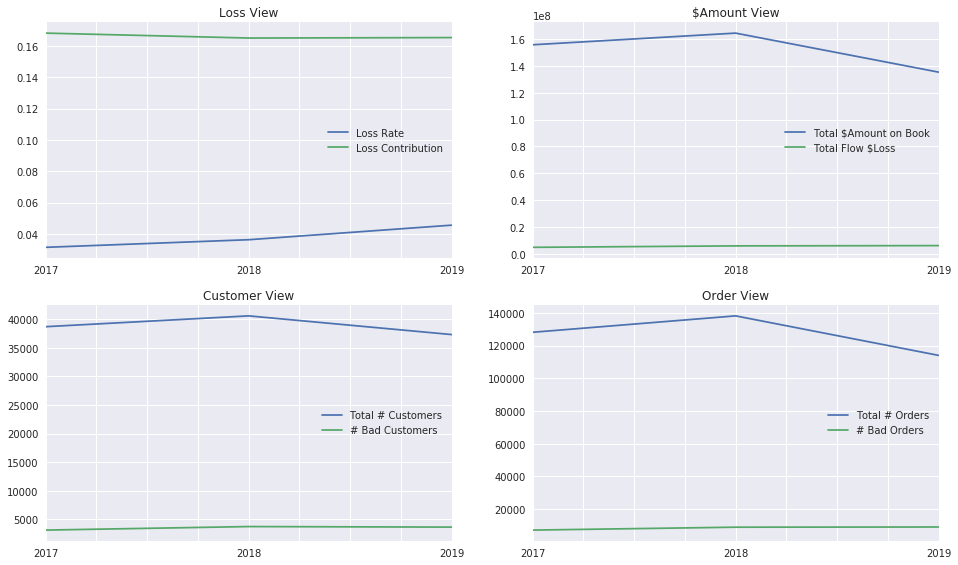

*===============================================================================================================*
						 THE HOME DEPOT
*===============================================================================================================*


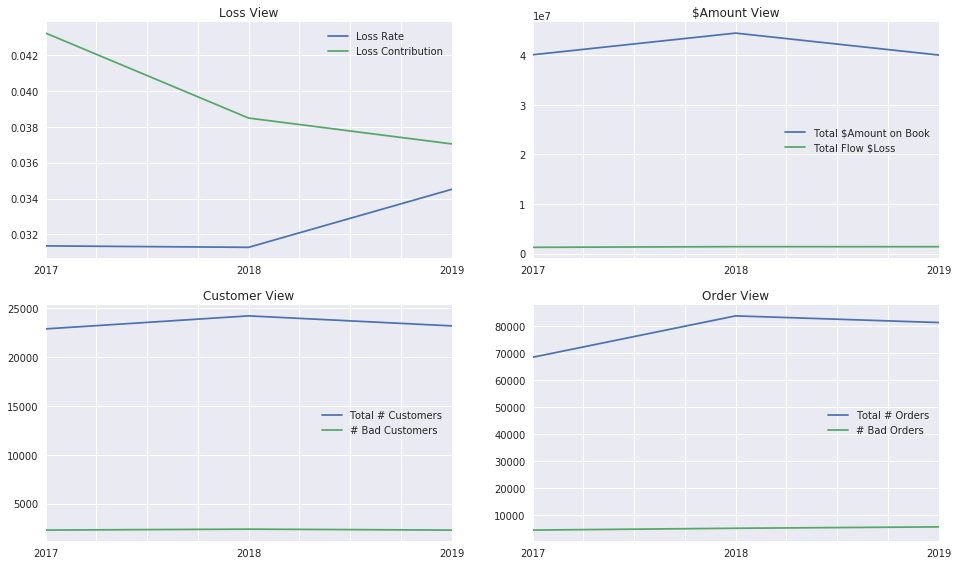

*===============================================================================================================*
						 DAVITA INC
*===============================================================================================================*


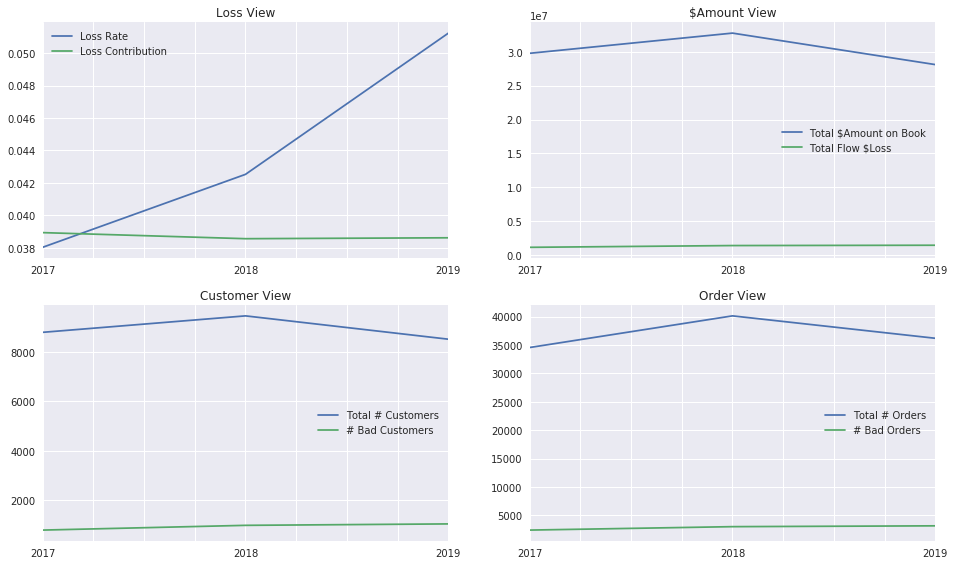

*===============================================================================================================*
						 TYSON FOODS
*===============================================================================================================*


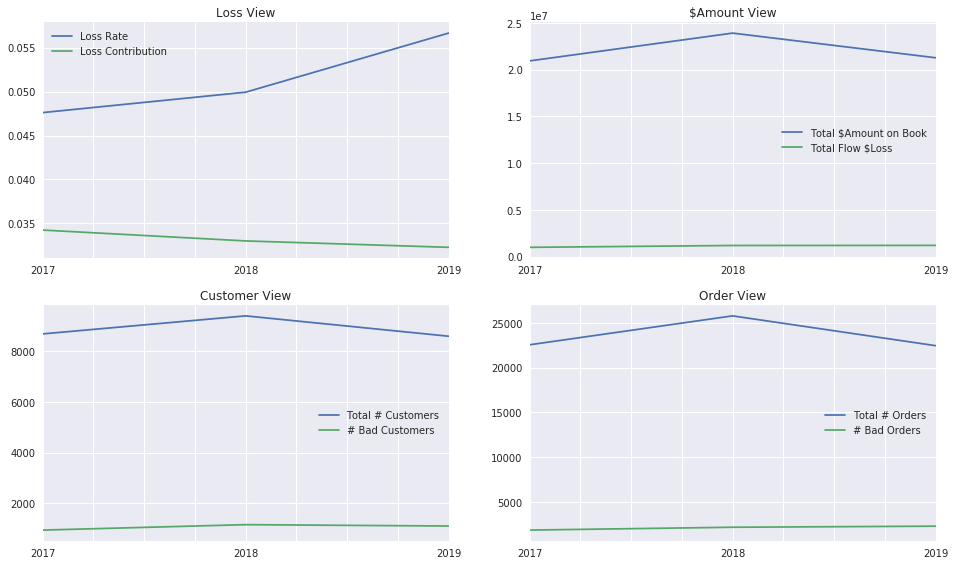

*===============================================================================================================*
						 COMMUNITY HEALTH SYSTEMS
*===============================================================================================================*


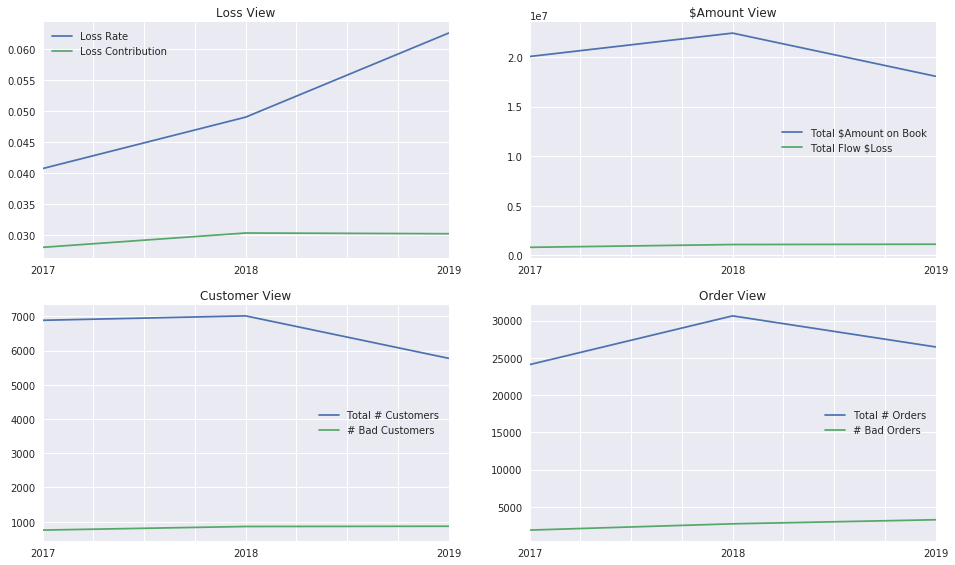

*===============================================================================================================*
						 SEANC
*===============================================================================================================*


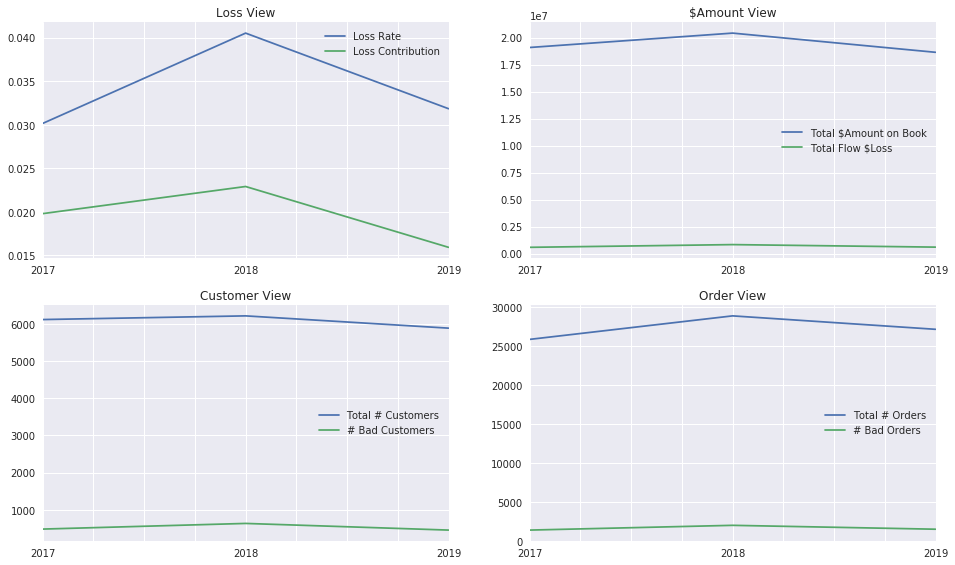

*===============================================================================================================*
						 KOHL'S DEPARTMENT STORES
*===============================================================================================================*


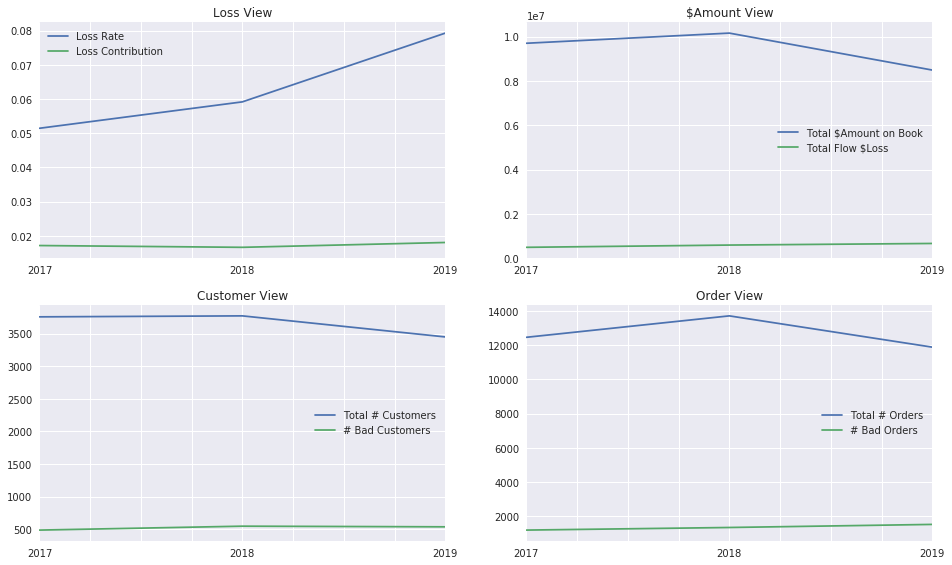

*===============================================================================================================*
						 CALIFORNIA STATE EMPLOYEES ASSOCIATION
*===============================================================================================================*


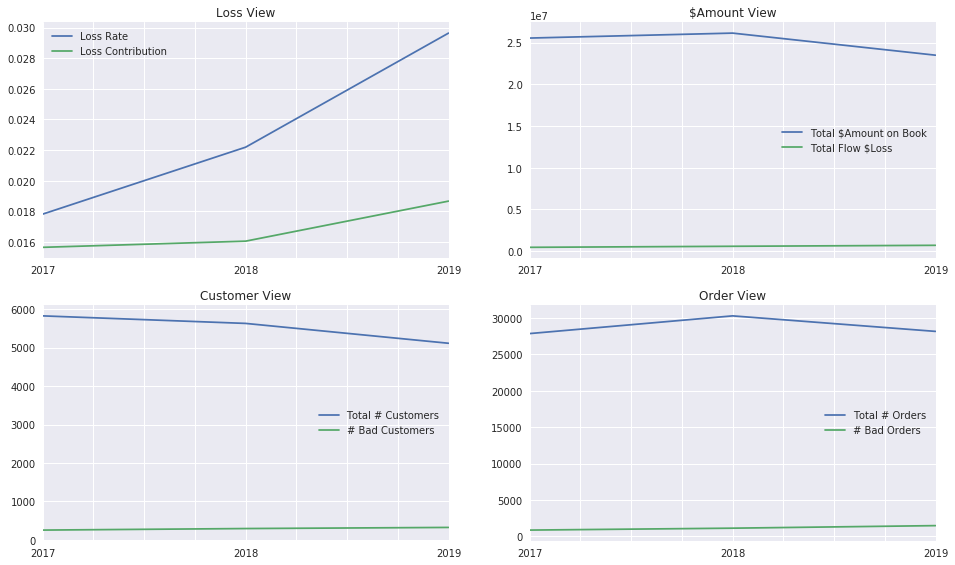

*===============================================================================================================*
						 DELTA AIR LINES, INC.
*===============================================================================================================*


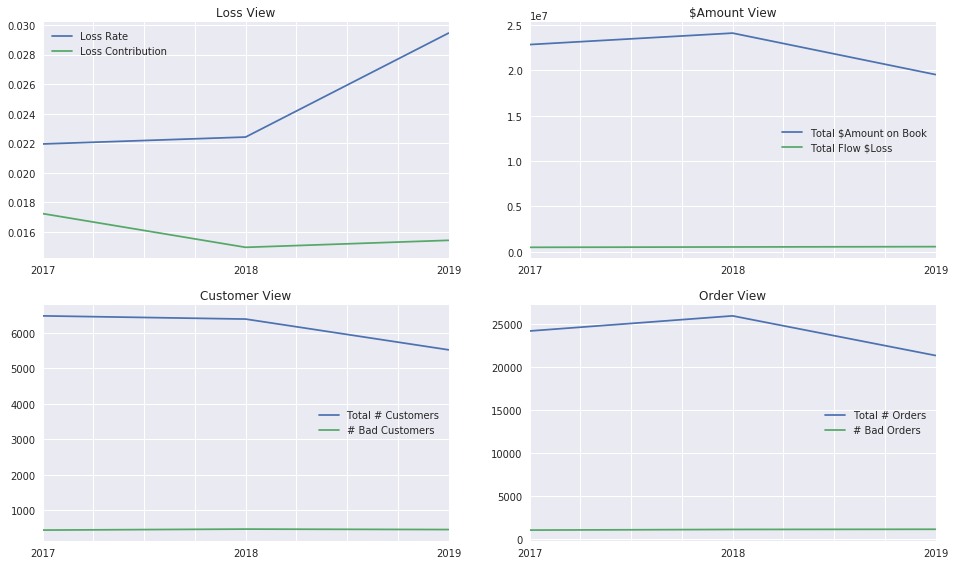

*===============================================================================================================*
						 AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES
*===============================================================================================================*


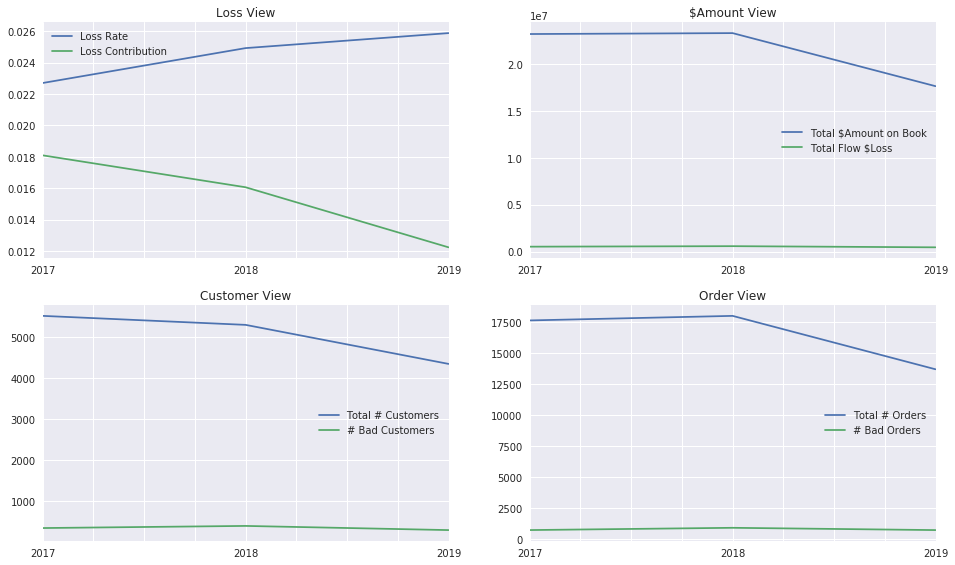

*===============================================================================================================*
						 COMPASS GROUP (NEW)
*===============================================================================================================*


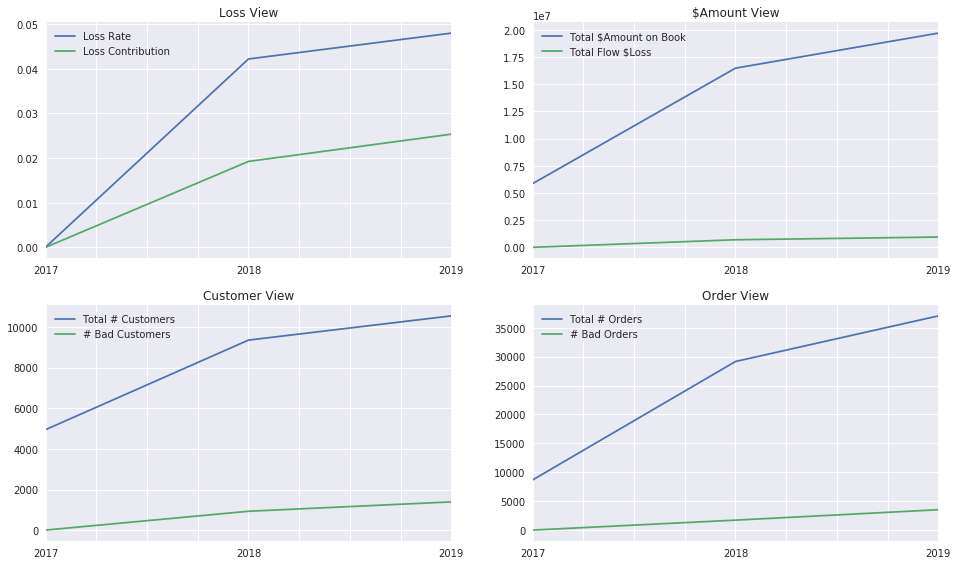

*===============================================================================================================*
						 ADVANCE AUTO PARTS, INC.
*===============================================================================================================*


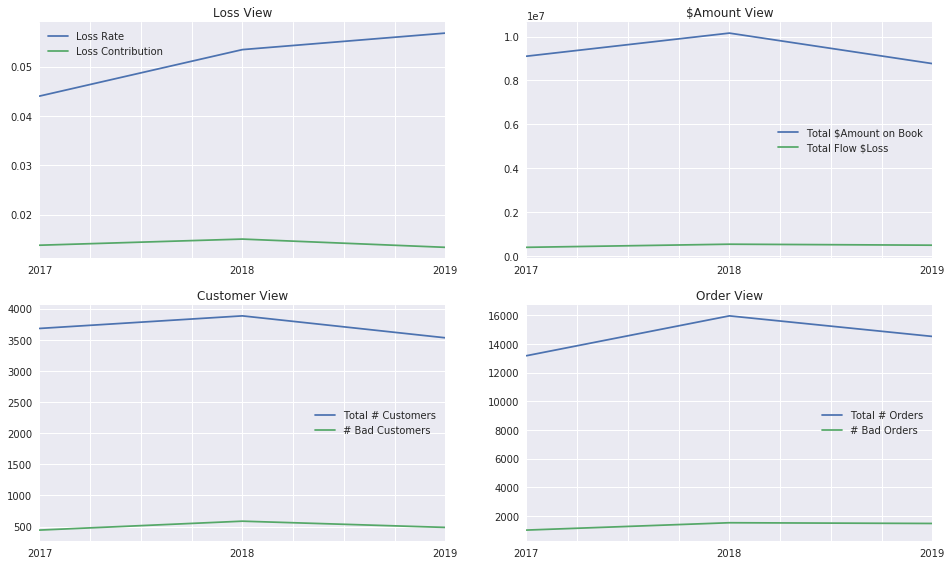

*===============================================================================================================*
						 WALGREENS FULL-TIME
*===============================================================================================================*


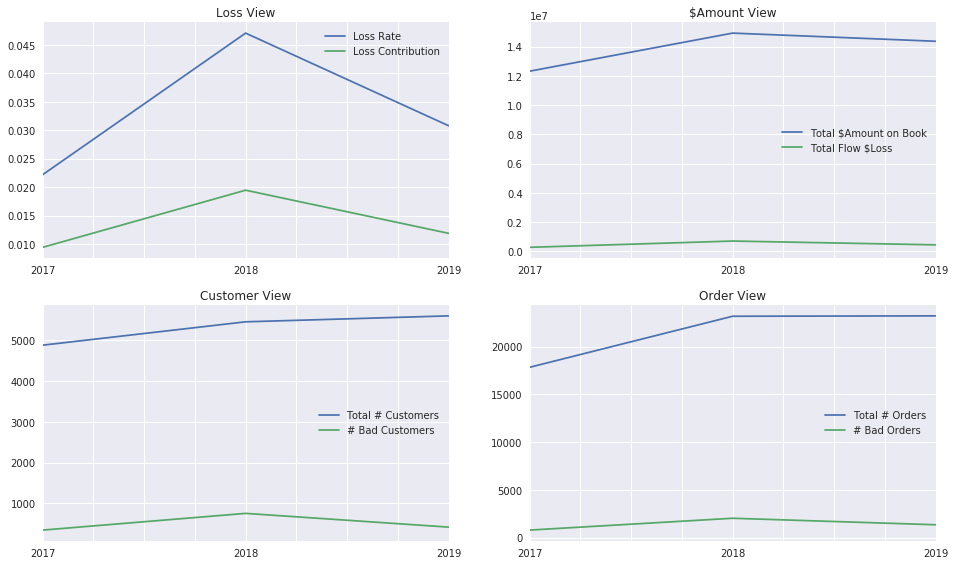

In [85]:
list_of_client_ids =[2049, 2302, 2250, 2149, 2422, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]
print('\t\t\t\t*=============================================*')
print('\t\t\t\t50% Avg Loss Contribution(13) over past 3 years')
print('\t\t\t\t*=============================================*')
# Client View
for client_id in list_of_client_ids:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.2)
    acct_name = loss_rate[loss_rate['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

        
    loss_rate[loss_rate['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    loss_contrib[loss_contrib['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    axes[0,0].legend(['Loss Rate','Loss Contribution'])
    axes[0,0].set_title('Loss View')
    
    total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
    axes[0,1].set_title('$Amount View')
    
    
    total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    axes[1,0].legend(['Total # Customers','# Bad Customers'])
    axes[1,0].set_title('Customer View')
    
    total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
    flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
    axes[1,1].legend(['Total # Orders','# Bad Orders'])
    axes[1,1].set_title('Order View')
    
    plt.show()

					*====================================*
					Top 10 Avg Loss Rate over past 3 years
					*====================================*
*===============================================================================================================*
						 BOEING (RETIREES)
*===============================================================================================================*


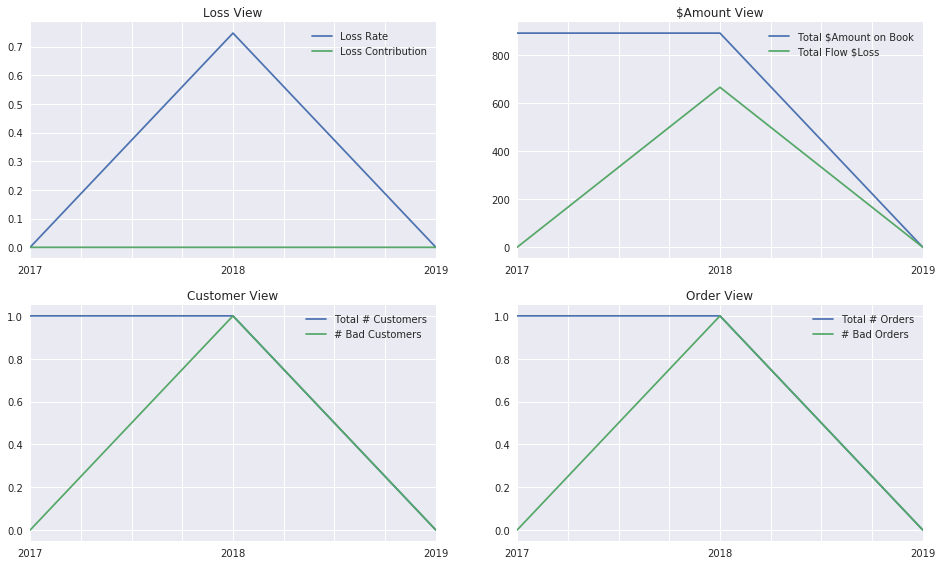

*===============================================================================================================*
						 FEDERAL FIRST
*===============================================================================================================*


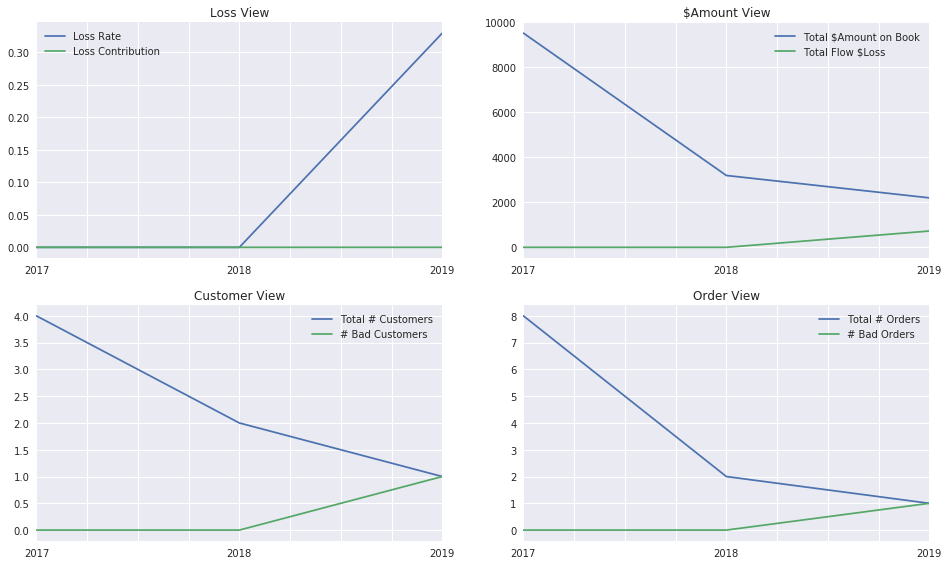

*===============================================================================================================*
						 MERCER MARKETPLACE
*===============================================================================================================*


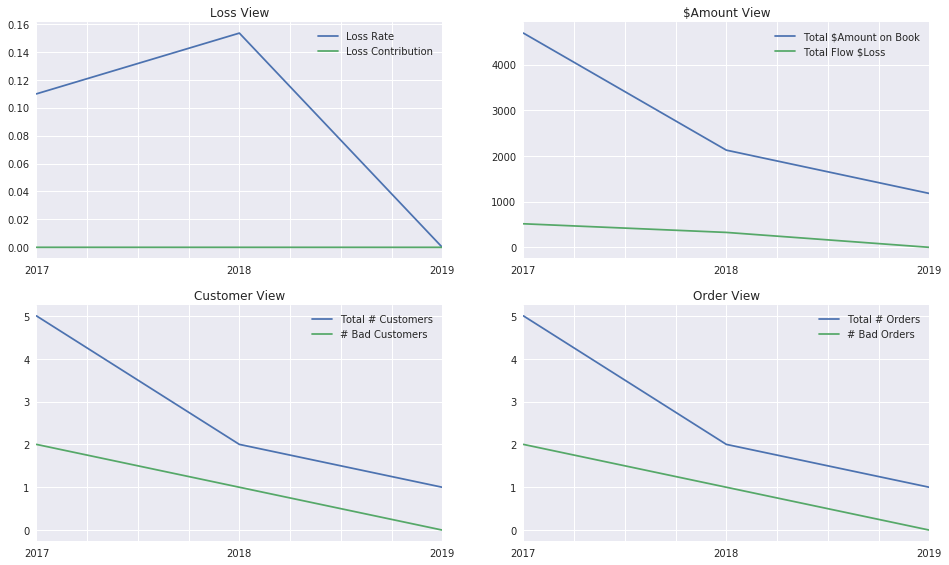

*===============================================================================================================*
						 THE MECHANICS BANK
*===============================================================================================================*


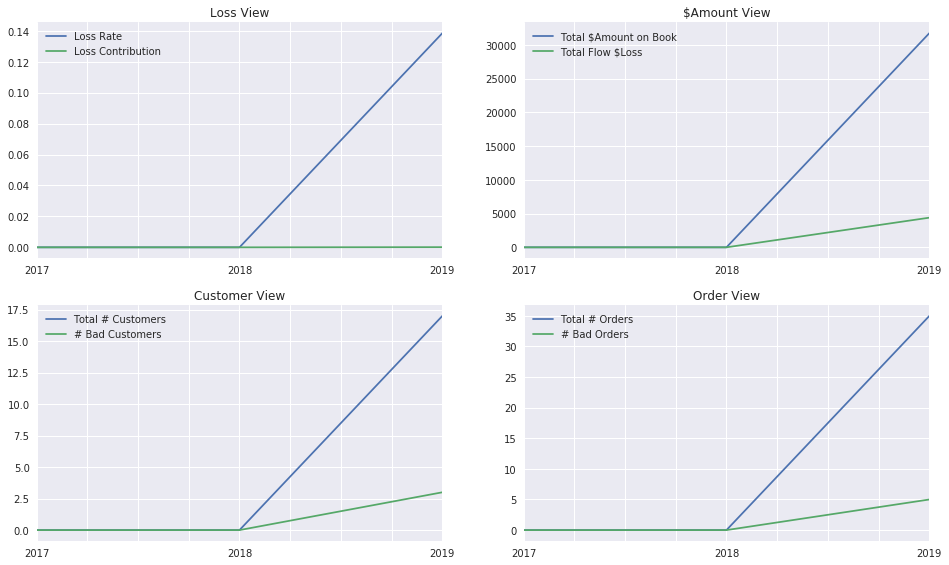

*===============================================================================================================*
						 KMG PRESTIGE, INC
*===============================================================================================================*


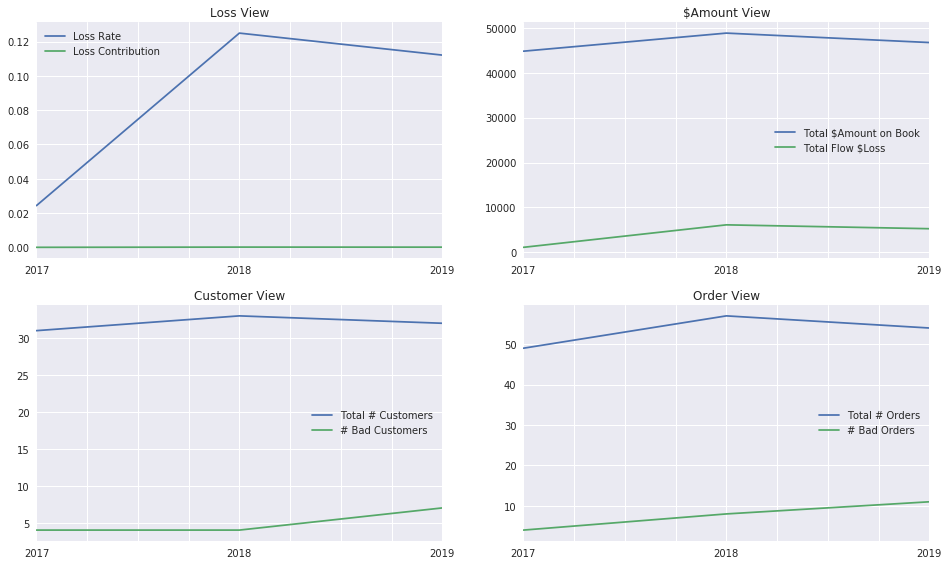

*===============================================================================================================*
						 CAPSTONE RESTAURANT GROUP
*===============================================================================================================*


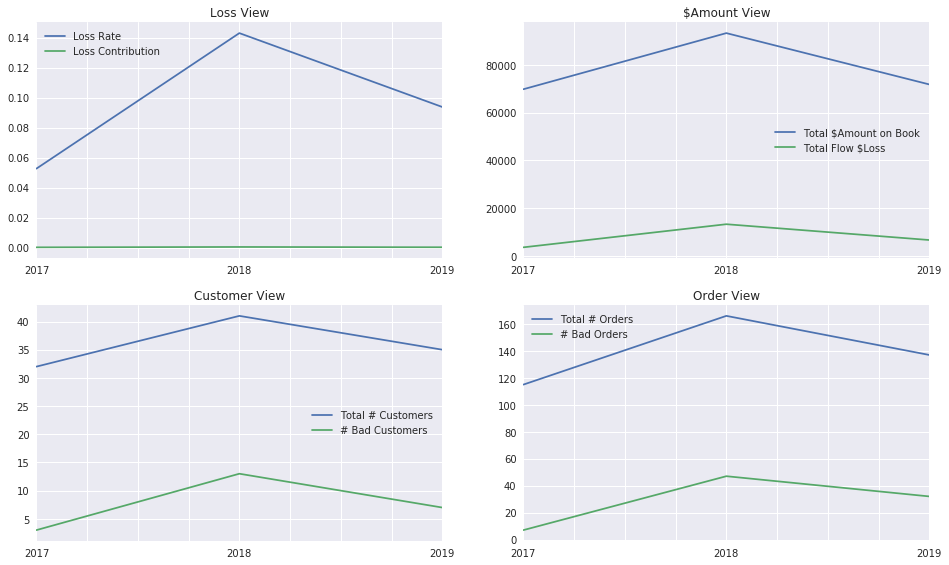

*===============================================================================================================*
						 WALGREENS PART-TIME
*===============================================================================================================*


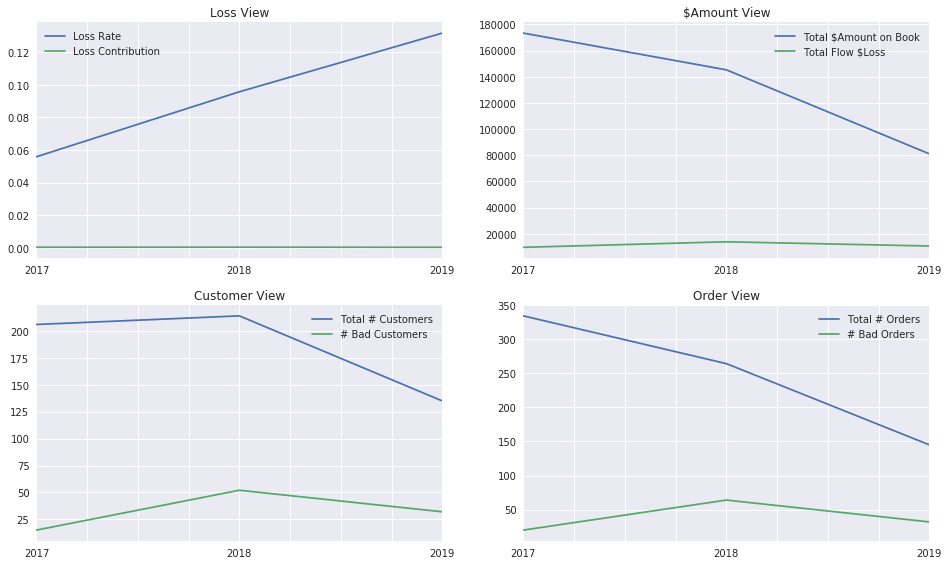

*===============================================================================================================*
						 SERCO
*===============================================================================================================*


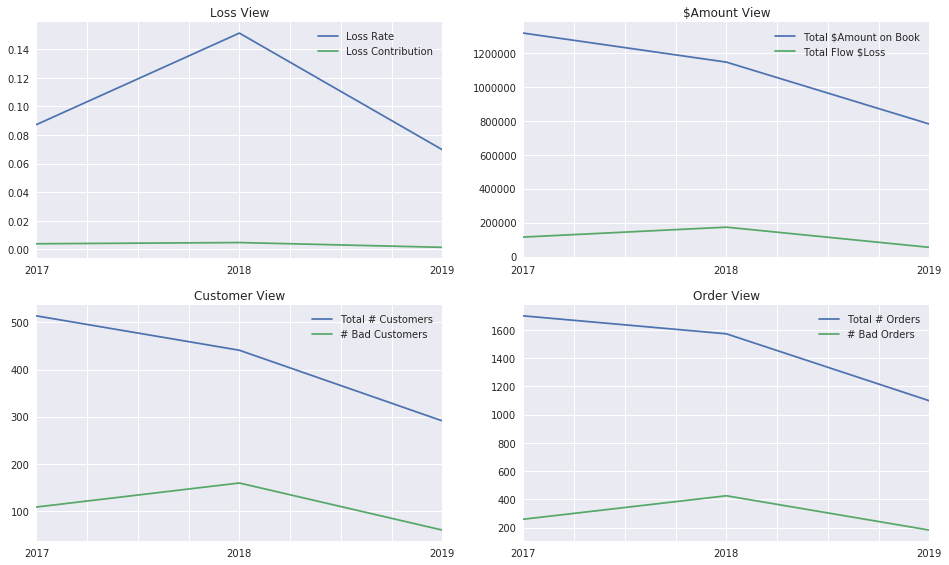

*===============================================================================================================*
						 REGIS CORPORATION
*===============================================================================================================*


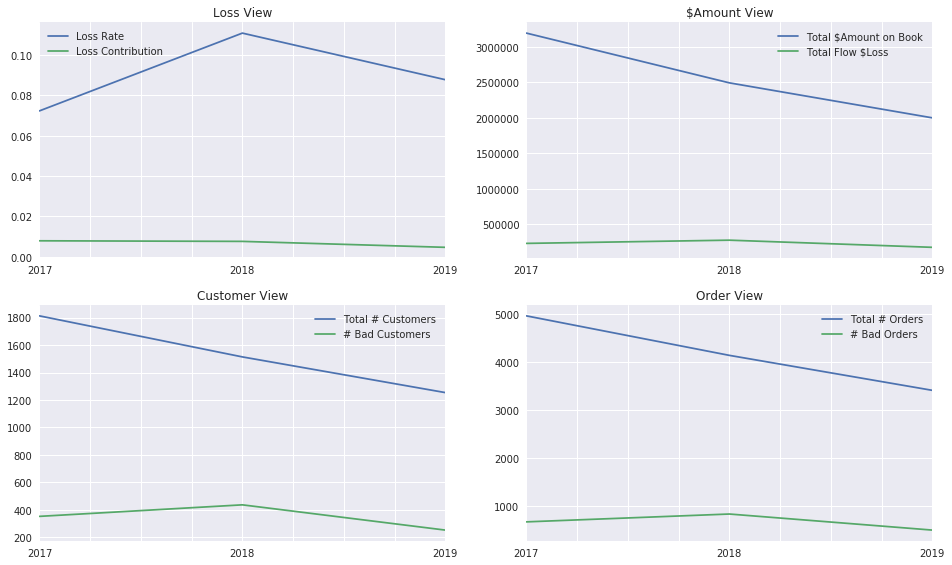

*===============================================================================================================*
						 AUGEO AFFINITY MARKETING, INC
*===============================================================================================================*


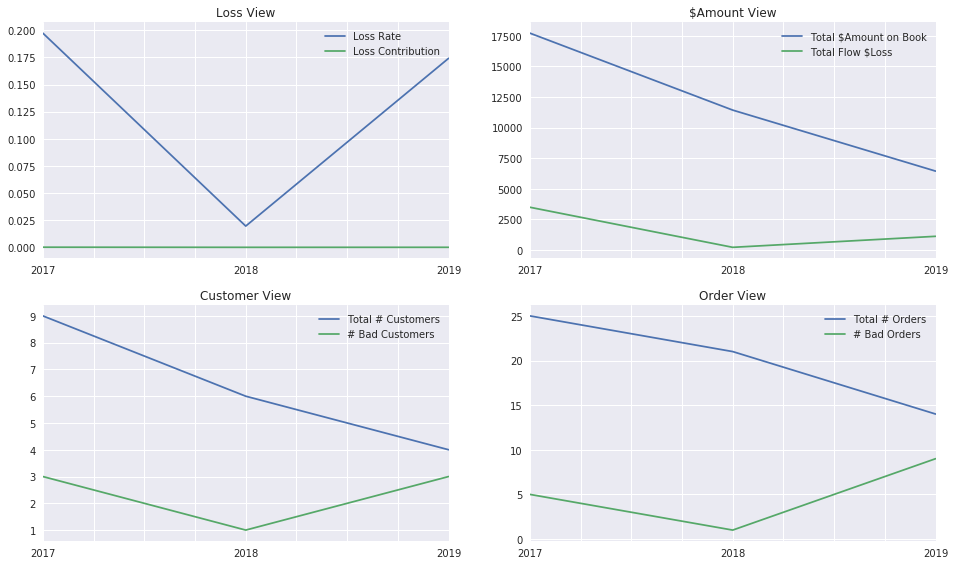

In [58]:
list_of_client_ids = [5001, 2854, 2406, 2555, 4009, 2466, 2401, 2351, 2402, 4022]
print('\t\t\t\t\t*====================================*')
print('\t\t\t\t\tTop 10 Avg Loss Rate over past 3 years')
print('\t\t\t\t\t*====================================*')

# Client View
for client_id in list_of_client_ids:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.2)
    acct_name = loss_rate[loss_rate['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

        
    loss_rate[loss_rate['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    loss_contrib[loss_contrib['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,0])
    axes[0,0].legend(['Loss Rate','Loss Contribution'])
    axes[0,0].set_title('Loss View')
    
    total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
    axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
    axes[0,1].set_title('$Amount View')
    
    
    total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    axes[1,0].legend(['Total # Customers','# Bad Customers'])
    axes[1,0].set_title('Customer View')
    
    total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
    flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
    axes[1,1].legend(['Total # Orders','# Bad Orders'])
    axes[1,1].set_title('Order View')
    
    plt.show()

In [202]:
top5_client_ids =[2049, 2302, 2250, 2149, 2422]#, 2191, 2225, 2183, 2238, 2047, 2496, 2218, 2400]

*===============================================================================================================*
					Top 5 Loss Contribution Clients
*===============================================================================================================*


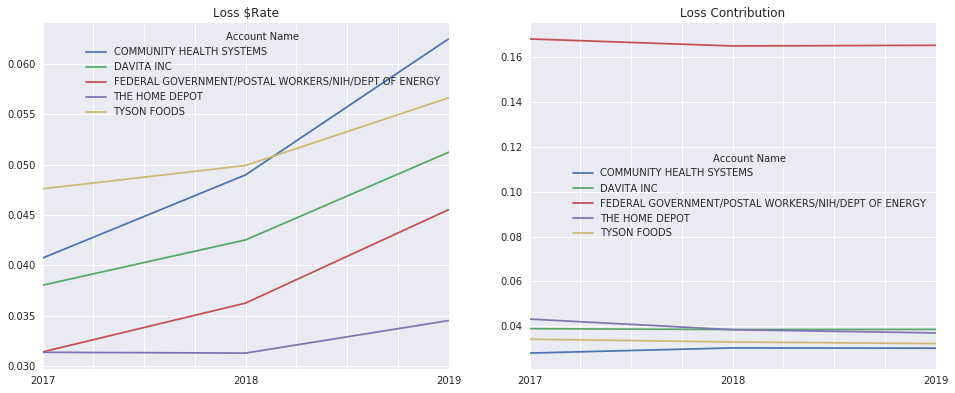

In [232]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top5_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 5 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')

# total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
# axes[0,1].set_title('$Amount View')


# total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# axes[1,0].legend(['Total # Customers','# Bad Customers'])
# axes[1,0].set_title('Customer View')

# total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
# flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
# axes[1,1].legend(['Total # Orders','# Bad Orders'])
# axes[1,1].set_title('Order View')

plt.show()

In [238]:
top2_to_5_client_ids =[2302, 2250, 2149, 2422]

*===============================================================================================================*
					Top 2-5 Loss Contribution Clients
*===============================================================================================================*


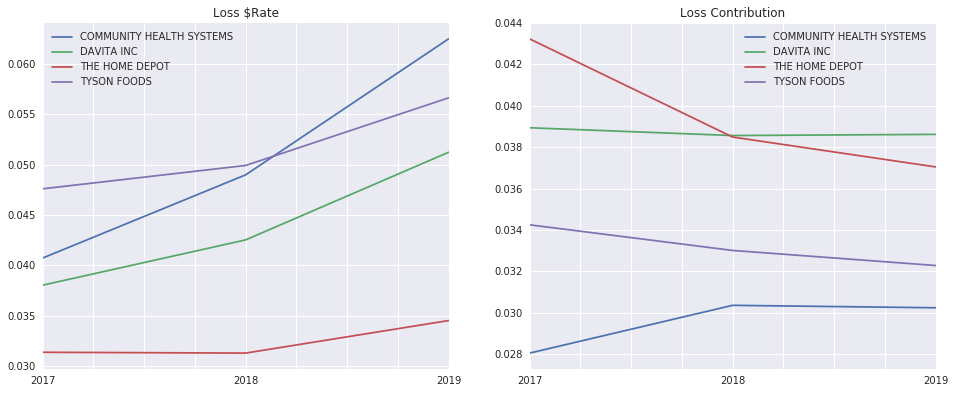

In [239]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top2_to_5_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 2-5 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')

# total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
# axes[0,1].set_title('$Amount View')


# total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# axes[1,0].legend(['Total # Customers','# Bad Customers'])
# axes[1,0].set_title('Customer View')

# total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
# flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
# axes[1,1].legend(['Total # Orders','# Bad Orders'])
# axes[1,1].set_title('Order View')

plt.show()

In [234]:
top5_to_10_client_ids = [2191, 2225, 2183, 2238, 2047]

*===============================================================================================================*
					Top 5-10 Loss Contribution Clients
*===============================================================================================================*


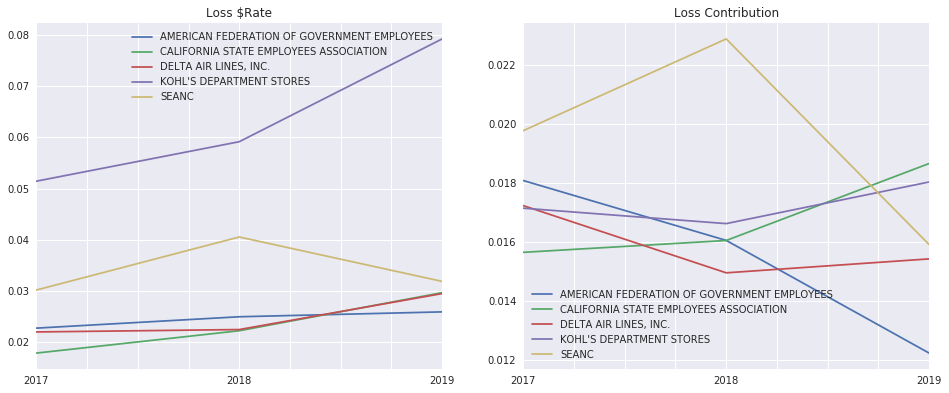

In [235]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top5_to_10_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 5-10 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')

# total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
# axes[0,1].set_title('$Amount View')


# total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# axes[1,0].legend(['Total # Customers','# Bad Customers'])
# axes[1,0].set_title('Customer View')

# total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
# flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
# axes[1,1].legend(['Total # Orders','# Bad Orders'])
# axes[1,1].set_title('Order View')

plt.show()

In [236]:
top10_to_13_client_ids = [2496, 2218, 2400]

*===============================================================================================================*
					Top 10-13 Loss Contribution Clients
*===============================================================================================================*


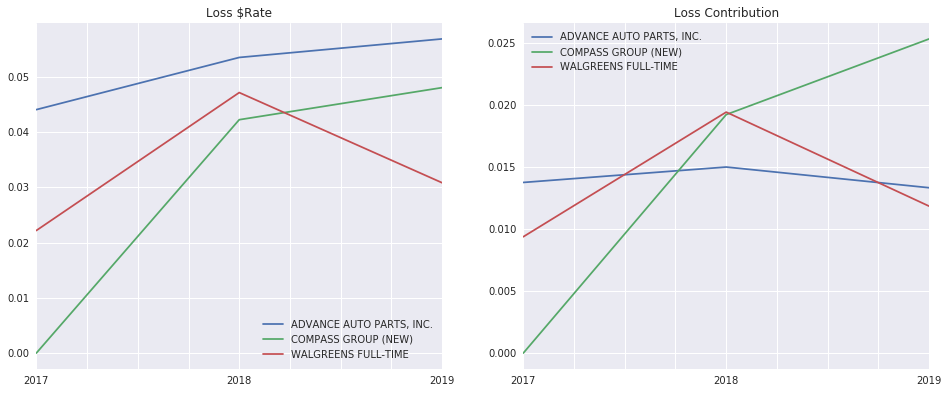

In [237]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
plt.subplots_adjust(left = 0.125,
                    right = 0.9,
                    bottom = 0.1,
                    top = 0.9,
                    wspace = 0.2,
                    hspace = 0.2)
acct_name = [loss_rate[loss_rate['Client ID']==i]['Account Name'].values[0] for i in top10_to_13_client_ids]
print('*===============================================================================================================*')
# print('\t\t\t\t\t\t',acct_name)
print('\t\t\t\t\tTop 10-13 Loss Contribution Clients')
print('*===============================================================================================================*')


loss_rate[loss_rate['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[0])

axes[0].legend()
axes[0].set_title('Loss $Rate')


loss_contrib[loss_contrib['Account Name'].isin(acct_name)][['Account Name','2017','2018','2019']].set_index('Account Name').fillna(0).T.plot(ax=axes[1])
axes[1].legend()
axes[1].set_title('Loss Contribution')

# total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,1])
# axes[0,1].legend(['Total $Amount on Book','Total Flow $Loss'])
# axes[0,1].set_title('$Amount View')


# total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
# axes[1,0].legend(['Total # Customers','# Bad Customers'])
# axes[1,0].set_title('Customer View')

# total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,1])
# flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,1])
# axes[1,1].legend(['Total # Orders','# Bad Orders'])
# axes[1,1].set_title('Order View')

plt.show()

### Closer look: top loss contribution clients

In [ ]:
"""
Selected Clients:



"""

In [87]:
Customer.groupby('Account Name').agg({'Unique_Customer_ID': 'count', 'Assigned_Spending_Limit': 'mean',
                                      'Customer_Salary': 'mean', 'Customer_Tenure': 'mean', 'Termination Date': 'unique'}).sort_values('Unique_Customer_ID', ascending=False).reset_index().round(1).head(20)

Account Name  Unique_Customer_ID  Assigned_Spending_Limit  Customer_Salary  Customer_Tenure                 Termination Date
0   FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...               75936                   5355.2          58924.9            168.5                            [NaT]
1                                      THE HOME DEPOT               44516                   1968.9          32059.2            101.6                            [NaT]
2                              CHARTER COMMUNICATIONS               20822                   5228.6          41916.9            104.1  [2018-12-31T00:00:00.000000000]
3                                         TYSON FOODS               17981                   3693.4          37523.2            119.0                            [NaT]
4                                          DAVITA INC               15967                   4793.3          45188.0            102.8                            [NaT]
5                                 COMPASS GROUP (NEW)               11562                   2258.1         435517.7             85.0                            [NaT]
6                               DELTA AIR LINES, INC.               11382                   6865.9          51191.1            153.9                            [NaT]
7                                               SEANC               11296                   4498.4          35132.4            140.5                            [NaT]
8         AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES               10888                   6475.9          62635.4            196.5                            [NaT]
9                            COMMUNITY HEALTH SYSTEMS               10139                   5329.6          41737.7            113.0                            [NaT]
10             CALIFORNIA STATE EMPLOYEES ASSOCIATION                9369                   6633.7          51136.2            186.1                            [NaT]
11                                WALGREENS FULL-TIME                8009                   3458.3          38561.8            115.1                            [NaT]
12                           KOHL'S DEPARTMENT STORES                7937                   3814.7          33975.4            105.8                            [NaT]
13                           ADVANCE AUTO PARTS, INC.                7126                   3668.5          34358.1             98.9                            [NaT]
14           OHIO CIVIL SERVICE EMPLOYEES ASSOCIATION                6753                   6813.4          46580.5            172.0                            [NaT]
15                            THE WALT DISNEY COMPANY                6319                   1784.0          21026.2            109.8                            [NaT]
16                                           RITE-AID                6151                   4305.1          34939.5            150.7                            [NaT]
17                                     DIGNITY HEALTH                6034                   7440.6          63388.2            142.6                            [NaT]
18                                               CITI                5796                   3106.6          44018.4            105.8                            [NaT]
19                                   STATE OF GEORGIA                5612                   4552.8          37619.5            100.3                            [NaT]

In [12]:
fed = df_17_w_bad[df_17_w_bad['Client ID']==2049]

In [102]:
fed.shape

(2371236, 56)

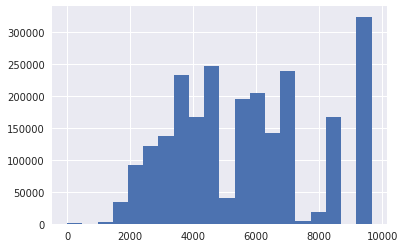

In [18]:
# 63 oders with 0 spending limit, 13 of them CO
fed['Assigned_Spending_Limit'].hist(bins = 20)

In [19]:
fed['Assigned_Spending_Limit'].describe()

count    2.371236e+06
mean     5.740464e+03
std      2.323100e+03
min      0.000000e+00
25%      3.740000e+03
50%      5.400000e+03
75%      7.200000e+03
max      9.660000e+03
Name: Assigned_Spending_Limit, dtype: float64

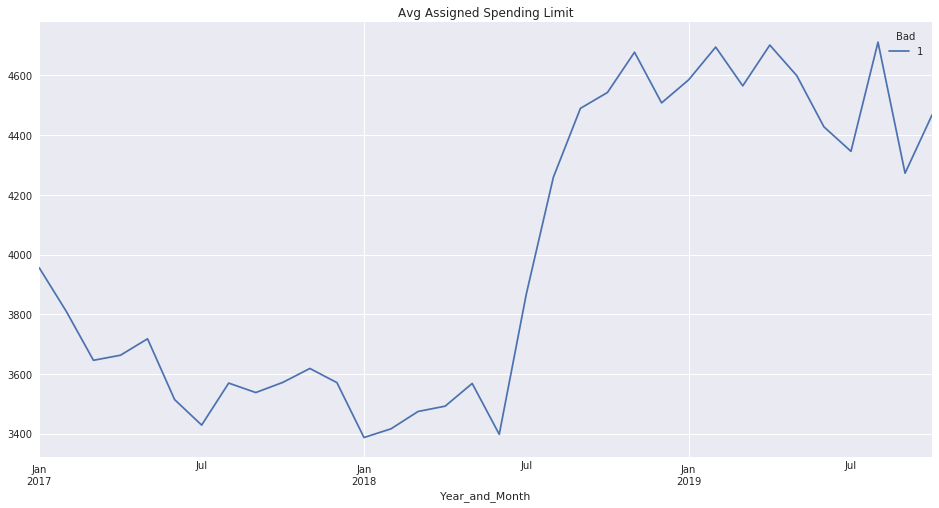

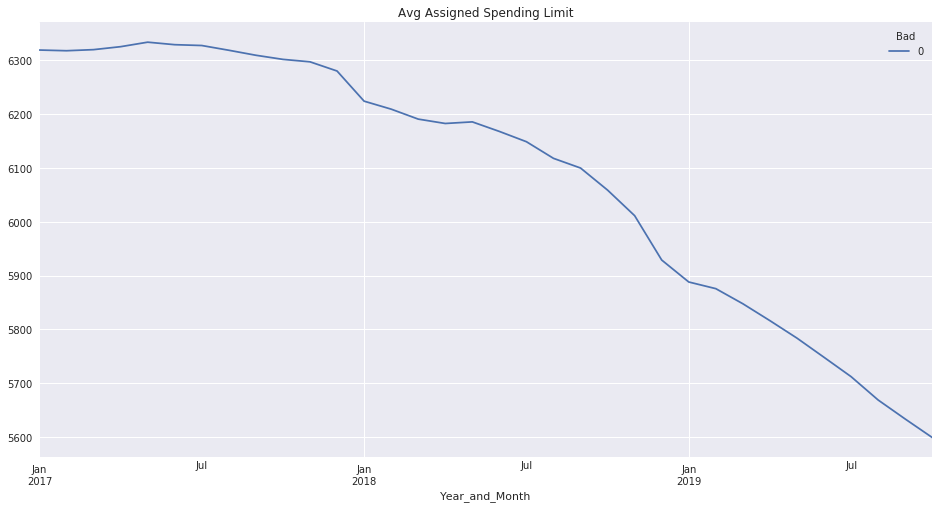

In [36]:
fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Assigned Spending Limit', figsize=(16, 8))

fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Assigned Spending Limit', figsize=(16, 8))

plt.show()

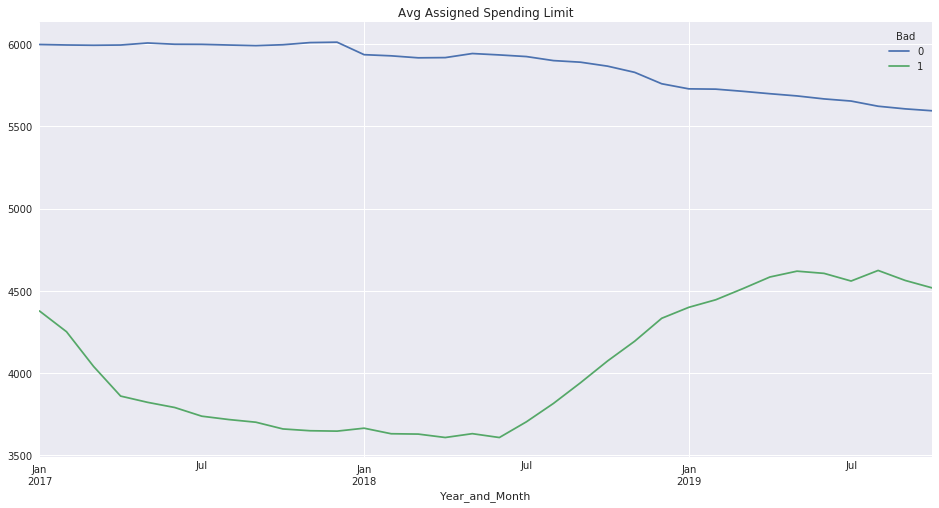

In [105]:
fed.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Assigned Spending Limit', figsize=(16, 8))
plt.show()

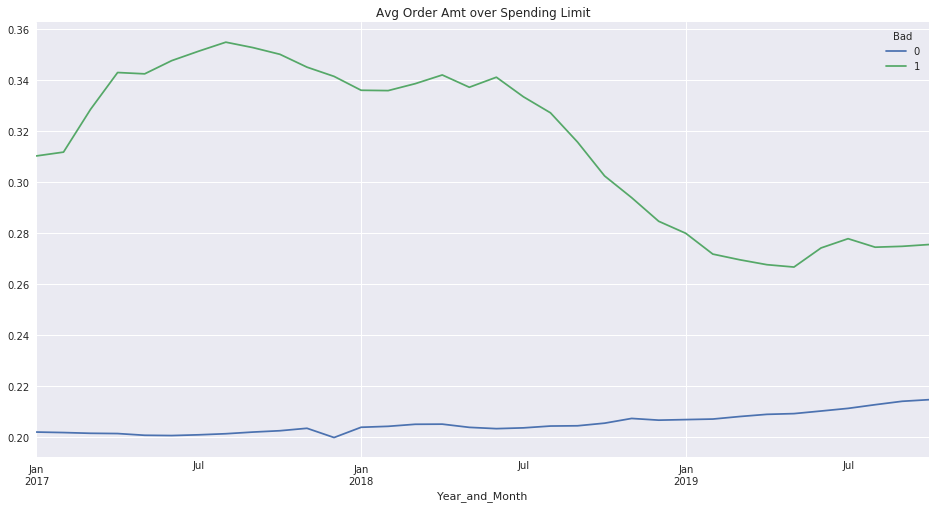

In [155]:
(fed.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/fed.pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(title='Avg Order Amt over Spending Limit', figsize=(16, 8))
plt.show()

In [156]:
# fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
#                 aggfunc='mean').plot(title='Avg Order_Amount', figsize=(16, 8))
# plt.show()

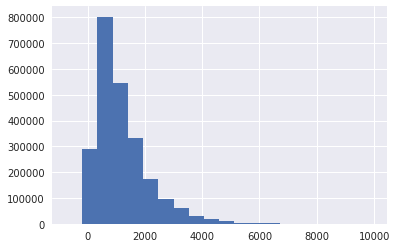

In [28]:
fed['Order_Amount'].hist(bins = 20)

In [29]:
fed['Order_Amount'].describe()

count    2.371236e+06
mean     1.207327e+03
std      9.357364e+02
min     -7.147100e+02
25%      5.437800e+02
50%      9.550600e+02
75%      1.595870e+03
max      9.906430e+03
Name: Order_Amount, dtype: float64

In [31]:
fed['Order_Amount'].min()

-714.71

In [34]:
fed[fed['Order_Amount']==-714.71]

Unique_Order_ID  Unique_Customer_ID  Order_Amount Product_Markup Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket  Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment Spending_Limit_at_time_of_Order Tenure_at_time_of_Order Salary_at_time_of_Order     Street1_x                               Street2_x      City_x State_x    Zip_x                                      items_ordered Year_and_Month EMPSTATUS  Order_Date  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag           Street1_y Street2_y          City_y State_y  Zip_y    Status Term_Date Active  Client ID                                       Account Name                         Industry  NAICS Code NAICS Description Broker TPA_x Launch Date Termination Date Affiliate/Fed Gov? Cash      YQ  Year  Payment_Order  Bad  Ever_Bad  2os_loss
13958190        14794629           100334757       -714.71         129.22        47.06             0.14                            .        Current            000-000     0.0                  PA                 N                     CC                            96.6                     353                 1562.28  US DOT PHMSA  1200 New Jersey Avenue SE Room E24 464  Washington      DC  20590.0  Apple iPhone 7 (4.7in 128GB Unlocked Black); S...     2017-01-01  Employed  12/13/2016             2049.0      02/25/2014                   9660.0            353.0         156228.0        Repeat Buyer  1230 BLUE WING TER       NaN  UPPER MARLBORO      MD  20774  Employed       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2017Q1  2017            2.0    0         0       0.0
13958191        14794629           100334757       -714.71         129.22        47.06             0.00                            .        Current            000-000     0.0                  PA                 Y                     CC                            96.6                     353                 1562.28  US DOT PHMSA  1200 New Jersey Avenue SE Room E24 464  Washington      DC  20590.0  Apple iPhone 7 (4.7in 128GB Unlocked Black); S...     2017-02-01  Employed  12/13/2016             2049.0      02/25/2014                   9660.0            353.0         156228.0        Repeat Buyer  1230 BLUE WING TER       NaN  UPPER MARLBORO      MD  20774  Employed       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2017Q1  2017            3.0    0         0       0.0

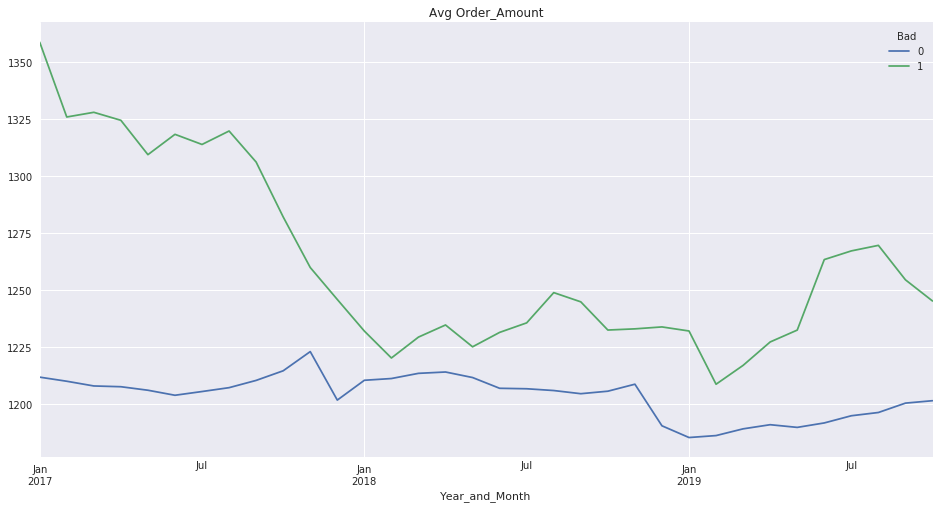

In [107]:
fed.pivot_table(values='Order_Amount', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Order_Amount', figsize=(16, 8))
plt.show()

In [ ]:
fed.loc[fed['Tenure_at_time_of_Order']=='.','Tenure_at_time_of_Order'] = np.nan
fed['Tenure_at_time_of_Order'] = fed['Tenure_at_time_of_Order'].astype(float)

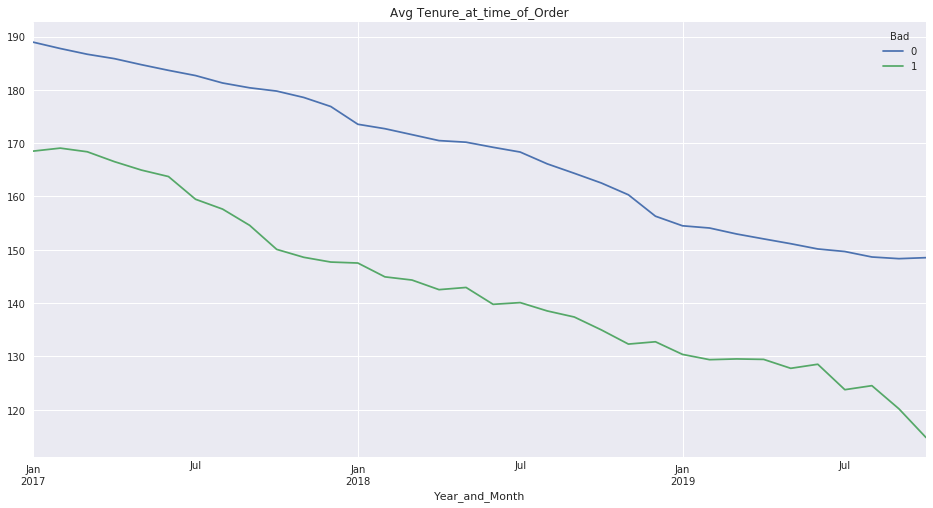

In [121]:
fed.pivot_table(values='Tenure_at_time_of_Order', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Tenure_at_time_of_Order', figsize=(16, 8))
plt.show()

In [127]:
# fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)]['Tenure_at_time_of_Order'].value_counts(dropna = False)

In [130]:
fed.loc[fed['Salary_at_time_of_Order']=='.','Salary_at_time_of_Order'] = np.nan
fed['Salary_at_time_of_Order'] = fed['Salary_at_time_of_Order'].astype(float)

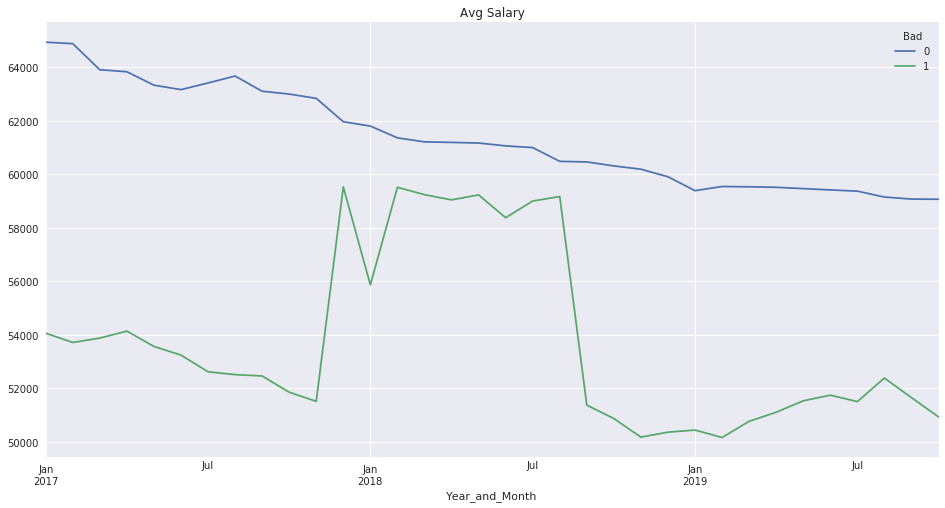

In [159]:
fed.pivot_table(values='Customer_Salary', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Salary', figsize=(16, 8))
plt.show()

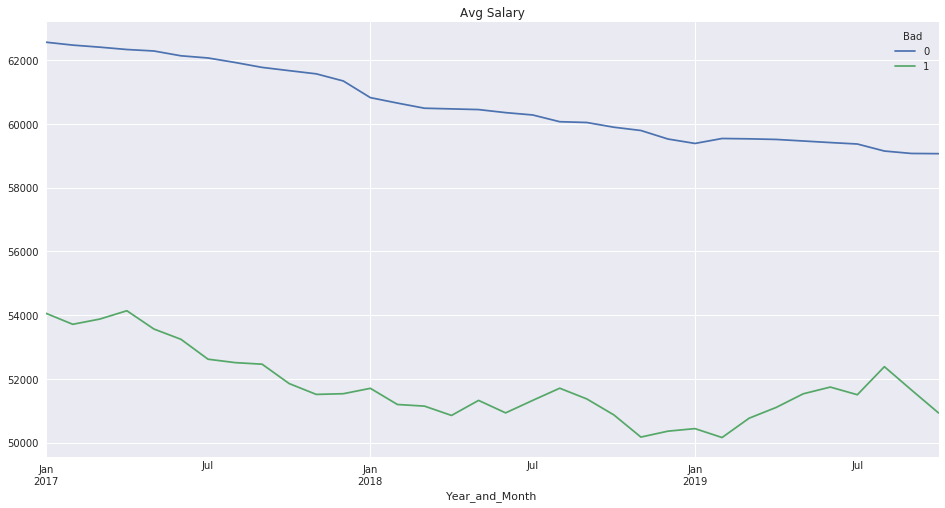

In [50]:
fed[fed['Customer_Salary']<1.815177e+07].pivot_table(values='Customer_Salary', index='Year_and_Month', columns='Bad',
                aggfunc='mean').plot(title='Avg Salary', figsize=(16, 8))
plt.show()

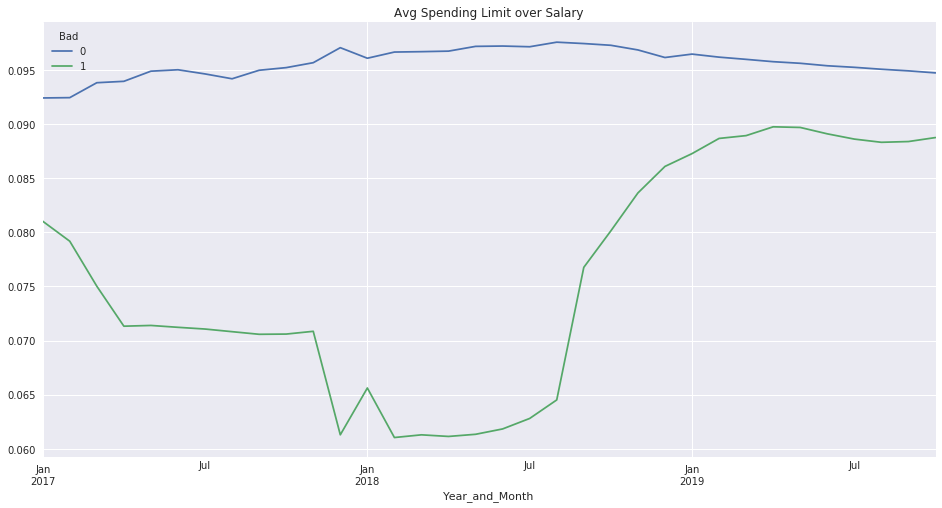

In [53]:
(fed[fed['Assigned_Spending_Limit']>0].pivot_table(values='Assigned_Spending_Limit', index='Year_and_Month', columns='Bad',
                aggfunc='mean')/fed.pivot_table(values='Customer_Salary', index='Year_and_Month', columns='Bad',
                aggfunc='mean')).plot(title='Avg Spending Limit over Salary', figsize=(16, 8))
plt.show()

In [161]:
fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].groupby('Year_and_Month')['Customer_Salary'].describe()

count          mean            std       min       25%           50%           75%           max
Year_and_Month                                                                                                   
2017-01-01       496.0  50811.354241   19026.776345  21974.52  35568.25  46002.500000  61761.250000  1.568240e+05
2017-02-01       597.0  51729.689449   20117.819726  20103.00  37414.00  47171.000000  60993.000000  1.568240e+05
2017-03-01       498.0  50018.244169   20193.704549  20225.00  34777.60  44235.500000  61792.030000  1.401250e+05
2017-04-01       483.0  50854.351612   19413.900670  20098.00  36440.00  47060.000000  60713.000000  1.217560e+05
2017-05-01       646.0  51958.818493   20080.369833  18816.00  37118.00  47776.101563  63332.640000  1.233150e+05
2017-06-01       401.0  49651.383469   20403.713991  20207.00  35796.00  44182.000000  60056.000000  1.624420e+05
2017-07-01       503.0  48260.793894   19482.811408  20091.00  34181.81  43978.000000  56853.000000  1.624420e+05
2017-08-01       518.0  51341.186924   23029.589411  20094.00  35543.00  44752.000000  57755.350000  1.624420e+05
2017-09-01       552.0  50161.103472   22223.948615  20056.00  35121.75  44793.000000  57605.350000  1.385350e+05
2017-10-01       695.0  50194.681715   20291.320425  20094.00  35559.00  45741.000000  62881.000000  1.226170e+05
2017-11-01       773.0  50801.318071   20539.760308  20280.00  36107.00  44891.000000  62391.000000  1.226170e+05
2017-12-01       743.0  99793.015641  938754.104345  20040.00  34674.00  44149.000000  63183.000000  1.815177e+07
2018-01-01       581.0  47108.373321   18653.573876  20040.00  33404.00  42414.000000  58104.000000  2.082110e+05
2018-02-01       596.0  48265.576346   20277.576255  20040.00  33774.75  43534.400000  57504.000000  1.346730e+05
2018-03-01       599.0  48707.753312   19402.059309  20040.00  34480.50  43825.000000  60636.500000  1.338030e+05
2018-04-01       589.0  48985.740064   18837.552979  20787.00  36372.52  44567.000000  57593.000000  1.277350e+05
2018-05-01       841.0  50686.290221   20782.234805  20509.00  36013.00  46118.000000  60902.400000  1.286770e+05
2018-06-01       613.0  47761.846562   18445.294013  20208.00  35054.00  42784.000000  57611.000000  1.870460e+05
2018-07-01       744.0  47772.182962   21603.514185  20174.00  34274.65  42157.000000  55065.000000  1.870460e+05
2018-08-01       710.0  51516.796969   53983.625009  20076.00  34683.75  43814.340000  58548.000000  9.882340e+05
2018-09-01       778.0  49477.138962   20495.606431  15901.86  35351.25  43982.000000  59359.000000  1.592343e+05
2018-10-01      1080.0  48365.071026   19392.368354  14381.76  35193.00  43658.800782  55269.000000  1.309380e+05
2018-11-01       793.0  48609.906188   18589.736372  20163.00  35464.00  44553.600000  56602.000000  1.155870e+05
2018-12-01       822.0  47409.733977   18354.587710  20163.00  34168.00  43263.000000  56602.000000  1.390320e+05
2019-01-01       891.0  48106.862483   18674.993038  20163.00  35600.00  44633.000000  55331.800781  1.242140e+05
2019-02-01       932.0  48907.767649   19070.730088  20350.00  35749.25  44036.000000  56747.250000  1.406910e+05
2019-03-01       830.0  48982.331718   20605.532944   2093.59  34477.00  44166.000000  57217.000000  2.080400e+05
2019-04-01       881.0  51195.658039   27223.247573  17174.04  35377.00  44421.000000  59481.000000  5.777842e+05
2019-05-01       907.0  50853.379151   28247.038673  20190.00  35569.00  45285.000000  59183.000000  5.777842e+05
2019-06-01       790.0  49291.645532   20937.366036  12264.00  35400.50  44064.000000  55653.450000  1.381190e+05
2019-07-01       945.0  48060.305550   19311.187684  20282.00  34887.00  45190.000000  54644.000000  2.354030e+05
2019-08-01       761.0  53353.340494   24853.204736  20144.00  37086.00  46813.000000  60022.000000  2.354030e+05
2019-09-01       797.0  47500.982107   18055.538428  20037.00  36317.00  44652.000000  54315.000000  1.762543e+05
2019-10-01      1195.0  502

In [160]:
fed[fed['Bad']==1].groupby('Year_and_Month')['Customer_Salary'].describe()

count          mean            std       min           25%           50%           75%           max
Year_and_Month                                                                                                       
2017-01-01      3737.0  54059.248692   35895.835169  14759.23  37952.040000  48700.000000  65157.988281  1.796625e+06
2017-02-01      3898.0  53711.403167   21797.215916  14759.23  38114.000000  48846.240000  65004.000000  1.614570e+05
2017-03-01      3654.0  53875.405973   21981.876107  14759.23  38114.000000  49174.000000  65157.988281  1.614570e+05
2017-04-01      3504.0  54136.858319   22139.182926  14759.23  38421.250000  49360.000000  65219.000000  1.614570e+05
2017-05-01      3740.0  53563.158797   21548.995464  14759.23  37881.000000  49174.000000  65157.988281  1.614570e+05
2017-06-01      3728.0  53239.930022   21427.432282  18816.00  37826.000000  48453.500000  65008.000000  1.624420e+05
2017-07-01      3761.0  52615.439771   21346.202359  18816.00  37449.000000  47897.000000  63900.000000  1.624420e+05
2017-08-01      3709.0  52508.875674   21718.664428  18816.00  37225.000000  47573.000000  63420.000000  1.624420e+05
2017-09-01      3634.0  52458.829584   22215.350713  18816.00  36894.459961  47195.000000  63332.640000  1.624420e+05
2017-10-01      3901.0  51850.678066   21904.829623  20056.00  36719.000000  46792.000000  62767.000000  1.624420e+05
2017-11-01      4204.0  51510.854528   21333.156283  20056.00  36515.000000  46217.600000  62608.000000  1.624420e+05
2017-12-01      4527.0  59529.057380  381017.628922  20040.00  36369.500000  45997.000000  62881.000000  1.815177e+07
2018-01-01      4344.0  55868.418073  275459.646008  20040.00  36439.250000  46367.500000  63043.000000  1.815177e+07
2018-02-01      4351.0  59514.414513  388607.008269  20040.00  35933.000000  45752.000000  62514.000000  1.815177e+07
2018-03-01      4472.0  59238.275037  383328.947364  20040.00  35918.000000  45812.000000  62546.500000  1.815177e+07
2018-04-01      4419.0  59043.117588  385607.901493  20040.00  35974.488281  45351.000000  62044.000000  1.815177e+07
2018-05-01      4578.0  59230.273912  378864.495792  20040.00  36450.000000  46151.000000  62630.250000  1.815177e+07
2018-06-01      4862.0  58376.615164  367662.003520  20040.00  36143.300000  45728.000000  61766.750000  1.815177e+07
2018-07-01      4715.0  59000.634506  373349.875884  20127.00  36483.000000  46028.000000  61628.000000  1.815177e+07
2018-08-01      4850.0  59168.805567  368623.838975  20076.00  36515.000000  45879.000000  61956.000000  1.815177e+07
2018-09-01      5103.0  51368.803773   27951.878344  15901.86  36450.000000  45744.000000  61504.000000  9.882340e+05
2018-10-01      5738.0  50867.588340   27120.916679  14381.76  36284.750000  45279.000000  60867.000000  9.882340e+05
2018-11-01      5645.0  50171.524549   20540.823701  14381.76  35942.000000  45273.000000  59730.000000  1.870460e+05
2018-12-01      5192.0  50357.292247   20326.494645  14381.76  36131.000000  45279.490235  59162.300000  1.592343e+05
2019-01-01      5500.0  50436.799190   20272.346277  14381.76  36535.000000  45553.500000  58960.000000  1.592343e+05
2019-02-01      5992.0  50157.505296   20007.341439  14381.76  36526.250000  45353.000000  58297.250000  1.592343e+05
2019-03-01      5529.0  50763.703835   20424.131062   2093.59  36535.000000  46003.820313  59134.400000  2.080400e+05
2019-04-01      5242.0  51102.059240   21855.921973   2093.59  36363.000000  45764.000000  59859.000000  5.777842e+05
2019-05-01      5423.0  51529.630651   23329.758795   2093.59  36337.600000  46143.000000  60867.000000  5.777842e+05
2019-06-01      5202.0  51741.159624   23630.536180      0.00  36605.000000  46521.109375  60902.400000  5.777842e+05
2019-07-01      4985.0  51500.668441   23620.830887      0.00  36659.000000  46365.000000  60307.000000  5.777842e+05
2019-08-01      5057.0  52380.975451   24430.140331      0.00  37139.000000  46862.400000  61233.000000  5.777842e+05
2019-

In [147]:
# fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].groupby('Year_and_Month')['State_x'].value_counts()

In [146]:
fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'State_x',aggfunc='nunique').to_csv('../data/fed_bad_state.csv')#.plot(figsize=(16,9))

In [148]:
fed[(fed['Bad']!=1)].pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'State_x',aggfunc='nunique').to_csv('../data/fed_good_state.csv')#.plot(figsize=(16,9))

In [152]:
(fed[(fed['Bad'] == 1) & (fed['Ever_Bad'] <= 1)].pivot_table(values='Unique_Customer_ID', index='Year_and_Month', columns='State_x', aggfunc='nunique') / \
    fed.pivot_table(values='Unique_Customer_ID', index='Year_and_Month', columns='State_x',
                    aggfunc='nunique')).to_csv('../data/fed_CO_state.csv')#.plot(figsize=(16,9))

In [143]:
fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'EMPSTATUS',aggfunc='nunique')#.plot(figsize=(16,9))

EMPSTATUS       Deceased  Direct Bill  Employed  Terminated
Year_and_Month                                             
2017-01-01           NaN        132.0     191.0         2.0
2017-02-01           NaN        146.0     173.0         NaN
2017-03-01           3.0        196.0     114.0         1.0
2017-04-01           3.0        144.0     148.0         1.0
2017-05-01           NaN         84.0     291.0         NaN
2017-06-01           NaN        110.0     160.0         NaN
2017-07-01           1.0         71.0     264.0         NaN
2017-08-01           4.0         28.0     277.0         NaN
2017-09-01           2.0          5.0     319.0         NaN
2017-10-01           NaN          2.0     374.0         NaN
2017-11-01           NaN          NaN     431.0         NaN
2017-12-01           1.0        138.0     282.0         NaN
2018-01-01           NaN         43.0     329.0         NaN
2018-02-01           1.0         16.0     344.0         1.0
2018-03-01           1.0          2.0     383.0         1.0
2018-04-01           2.0          5.0     351.0         NaN
2018-05-01           NaN          1.0     508.0         NaN
2018-06-01           NaN          NaN     398.0         NaN
2018-07-01           1.0         26.0     426.0         NaN
2018-08-01           2.0         30.0     417.0         NaN
2018-09-01           1.0         12.0     428.0         1.0
2018-10-01           4.0          3.0     564.0         NaN
2018-11-01           1.0          1.0     445.0         NaN
2018-12-01           NaN          NaN     489.0         NaN
2019-01-01           NaN          1.0     482.0         NaN
2019-02-01           1.0          NaN     460.0         NaN
2019-03-01           NaN          NaN     446.0         NaN
2019-04-01           1.0          NaN     469.0         NaN
2019-05-01           NaN          NaN     481.0         NaN
2019-06-01           1.0          NaN     450.0         NaN
2019-07-01           NaN          NaN     502.0         NaN
2019-08-01           1.0          NaN     408.0         NaN
2019-09-01           NaN          NaN     405.0         NaN
2019-10-01           NaN          NaN     563.0         NaN

In [144]:
fed.pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'EMPSTATUS',aggfunc='nunique')#.plot(figsize=(16,9))

EMPSTATUS       Deceased  Direct Bill  Employed  LOA  Terminated
Year_and_Month                                                  
2017-01-01           4.0        943.0   27642.0  NaN        16.0
2017-02-01           7.0        982.0   27299.0  1.0        14.0
2017-03-01           8.0       1120.0   27130.0  1.0        13.0
2017-04-01           8.0        991.0   27073.0  1.0        13.0
2017-05-01           6.0        910.0   27327.0  1.0        13.0
2017-06-01           8.0       1103.0   27364.0  NaN        16.0
2017-07-01           8.0        942.0   27481.0  NaN        16.0
2017-08-01           9.0        763.0   27903.0  NaN        15.0
2017-09-01           9.0        552.0   27892.0  NaN        15.0
2017-10-01           8.0        467.0   28028.0  NaN        15.0
2017-11-01           8.0        407.0   28617.0  NaN        15.0
2017-12-01           8.0       1134.0   30004.0  NaN        16.0
2018-01-01           4.0        928.0   28795.0  NaN        16.0
2018-02-01           5.0        759.0   28602.0  NaN        11.0
2018-03-01           4.0        596.0   28510.0  NaN         9.0
2018-04-01           4.0        378.0   28636.0  NaN         6.0
2018-05-01           NaN        165.0   28720.0  NaN         7.0
2018-06-01           NaN        154.0   28936.0  NaN         5.0
2018-07-01           2.0        322.0   28531.0  NaN         5.0
2018-08-01           5.0        293.0   28697.0  NaN         5.0
2018-09-01           7.0        262.0   28555.0  NaN         5.0
2018-10-01           8.0        234.0   28802.0  NaN         5.0
2018-11-01           3.0        180.0   29601.0  NaN         5.0
2018-12-01           NaN         89.0   30181.0  NaN         3.0
2019-01-01           1.0         69.0   29537.0  NaN         3.0
2019-02-01           1.0         68.0   29551.0  NaN         3.0
2019-03-01           NaN         38.0   29218.0  NaN         2.0
2019-04-01           1.0         31.0   29175.0  NaN         3.0
2019-05-01           NaN         27.0   29076.0  NaN         1.0
2019-06-01           1.0         26.0   28705.0  NaN         1.0
2019-07-01           1.0         24.0   28473.0  NaN         NaN
2019-08-01           2.0         22.0   28295.0  NaN         NaN
2019-09-01           1.0         21.0   28317.0  NaN         NaN
2019-10-01           1.0         21.0   28229.0  NaN         NaN

In [164]:
fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'Prior_Customer_Flag',aggfunc='nunique')#.plot(figsize=(16,9))

Prior_Customer_Flag  First Time Byer  Repeat Buyer
Year_and_Month                                    
2017-01-01                        48           277
2017-02-01                        37           282
2017-03-01                        38           276
2017-04-01                        40           257
2017-05-01                        44           331
2017-06-01                        48           222
2017-07-01                        63           273
2017-08-01                        47           262
2017-09-01                        42           284
2017-10-01                        45           331
2017-11-01                        56           375
2017-12-01                        49           372
2018-01-01                        52           320
2018-02-01                        37           325
2018-03-01                        42           345
2018-04-01                        43           315
2018-05-01                        64           445
2018-06-01                        64           334
2018-07-01                        67           386
2018-08-01                        69           380
2018-09-01                        63           379
2018-10-01                        77           494
2018-11-01                        59           388
2018-12-01                        61           428
2019-01-01                        78           405
2019-02-01                        56           405
2019-03-01                        76           370
2019-04-01                        90           380
2019-05-01                        58           423
2019-06-01                        71           380
2019-07-01                        88           414
2019-08-01                        71           338
2019-09-01                        55           350
2019-10-01                        87           476

In [170]:
fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'Prior_Customer_Flag',aggfunc='nunique')#.plot(figsize=(16,9))

Prior_Customer_Flag  First Time Byer  Repeat Buyer
Year_and_Month                                    
2017-01-01                      1328         22772
2017-02-01                      1303         22507
2017-03-01                      1297         22568
2017-04-01                      1277         22465
2017-05-01                      1285         22551
2017-06-01                      1290         22661
2017-07-01                      1287         22592
2017-08-01                      1339         22759
2017-09-01                      1314         22658
2017-10-01                      1325         22663
2017-11-01                      1364         23051
2017-12-01                      1640         24508
2018-01-01                      1533         23115
2018-02-01                      1509         22738
2018-03-01                      1489         22428
2018-04-01                      1536         22274
2018-05-01                      1567         22118
2018-06-01                      1617         22117
2018-07-01                      1661         21912
2018-08-01                      1725         21863
2018-09-01                      1749         21642
2018-10-01                      1843         21700
2018-11-01                      2066         22277
2018-12-01                      2428         22780
2019-01-01                      2389         22290
2019-02-01                      2458         22258
2019-03-01                      2588         22239
2019-04-01                      2757         22391
2019-05-01                      2910         22408
2019-06-01                      3062         22211
2019-07-01                      3254         22170
2019-08-01                      3461         22043
2019-09-01                      3674         21932
2019-10-01                      3940         21796

In [172]:
fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'Type_of_Backup_Payment',aggfunc='nunique')#.plot(figsize=(16,9))

Type_of_Backup_Payment    ACH     CC
Year_and_Month                      
2017-01-01              325.0    NaN
2017-02-01              319.0    NaN
2017-03-01              314.0    NaN
2017-04-01              297.0    NaN
2017-05-01              364.0   19.0
2017-06-01              223.0   68.0
2017-07-01              212.0  151.0
2017-08-01              193.0  159.0
2017-09-01              209.0  160.0
2017-10-01              207.0  227.0
2017-11-01              250.0  253.0
2017-12-01              179.0  299.0
2018-01-01              174.0  234.0
2018-02-01              139.0  242.0
2018-03-01              125.0  281.0
2018-04-01              108.0  259.0
2018-05-01              132.0  386.0
2018-06-01               84.0  317.0
2018-07-01              103.0  355.0
2018-08-01              112.0  347.0
2018-09-01               95.0  352.0
2018-10-01              144.0  443.0
2018-11-01              117.0  342.0
2018-12-01              130.0  367.0
2019-01-01              124.0  377.0
2019-02-01              108.0  361.0
2019-03-01              133.0  324.0
2019-04-01              126.0  359.0
2019-05-01              124.0  369.0
2019-06-01              109.0  346.0
2019-07-01              131.0  382.0
2019-08-01              104.0  314.0
2019-09-01              105.0  311.0
2019-10-01              140.0  441.0

In [173]:
fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'Type_of_Backup_Payment',aggfunc='nunique')#.plot(figsize=(16,9))

Type_of_Backup_Payment    ACH     CC
Year_and_Month                      
2017-01-01              20062   9335
2017-02-01              18986  10288
2017-03-01              18290  11246
2017-04-01              17343  12065
2017-05-01              16498  12960
2017-06-01              15617  13777
2017-07-01              14384  14494
2017-08-01              13274  15352
2017-09-01              11756  15951
2017-10-01              10308  16525
2017-11-01               8600  17514
2017-12-01               8217  19149
2018-01-01               7514  18073
2018-02-01               7273  17838
2018-03-01               7107  17631
2018-04-01               7044  17574
2018-05-01               6896  17565
2018-06-01               6882  17626
2018-07-01               6773  17543
2018-08-01               6775  17566
2018-09-01               6674  17480
2018-10-01               6657  17637
2018-11-01               6905  18296
2018-12-01               7279  18960
2019-01-01               7157  18520
2019-02-01               7150  18562
2019-03-01               7178  18648
2019-04-01               7266  18877
2019-05-01               7337  18956
2019-06-01               7324  18888
2019-07-01               7333  19037
2019-08-01               7372  19047
2019-09-01               7421  19075
2019-10-01               7466  19146

In [175]:
fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'Auto_Pay_Enrollment',aggfunc='nunique')#.plot(figsize=(16,9))

Auto_Pay_Enrollment  ACH       PA    PD
Year_and_Month                         
2017-01-01           1.0  24028.0  77.0
2017-02-01           1.0  23742.0  71.0
2017-03-01           1.0  23805.0  66.0
2017-04-01           1.0  23688.0  59.0
2017-05-01           1.0  23782.0  59.0
2017-06-01           1.0  23901.0  55.0
2017-07-01           1.0  23830.0  52.0
2017-08-01           1.0  24056.0  45.0
2017-09-01           1.0  23933.0  40.0
2017-10-01           1.0  23950.0  39.0
2017-11-01           1.0  24375.0  41.0
2017-12-01           1.0  26110.0  38.0
2018-01-01           1.0  24618.0  29.0
2018-02-01           1.0  24223.0  24.0
2018-03-01           1.0  23896.0  20.0
2018-04-01           NaN  23794.0  17.0
2018-05-01           NaN  23670.0  16.0
2018-06-01           NaN  23720.0  14.0
2018-07-01           NaN  23562.0  11.0
2018-08-01           NaN  23577.0  11.0
2018-09-01           NaN  23381.0  10.0
2018-10-01           NaN  23532.0  11.0
2018-11-01           NaN  24332.0  11.0
2018-12-01           NaN  25197.0  11.0
2019-01-01           NaN  24671.0   8.0
2019-02-01           NaN  24708.0   8.0
2019-03-01           NaN  24821.0   7.0
2019-04-01           NaN  25143.0   5.0
2019-05-01           NaN  25314.0   4.0
2019-06-01           NaN  25270.0   3.0
2019-07-01           NaN  25421.0   3.0
2019-08-01           NaN  25501.0   3.0
2019-09-01           NaN  25604.0   3.0
2019-10-01           NaN  25733.0   4.0

In [176]:
fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).pivot_table(values='Unique_Customer_ID',index='Year_and_Month',columns = 'Auto_Pay_Enrollment',aggfunc='nunique')#.plot(figsize=(16,9))

Auto_Pay_Enrollment  ACH       PA    PD
Year_and_Month                         
2017-01-01           1.0  24028.0  77.0
2017-02-01           1.0  23742.0  71.0
2017-03-01           1.0  23805.0  66.0
2017-04-01           1.0  23688.0  59.0
2017-05-01           1.0  23782.0  59.0
2017-06-01           1.0  23901.0  55.0
2017-07-01           1.0  23830.0  52.0
2017-08-01           1.0  24056.0  45.0
2017-09-01           1.0  23933.0  40.0
2017-10-01           1.0  23950.0  39.0
2017-11-01           1.0  24375.0  41.0
2017-12-01           1.0  26110.0  38.0
2018-01-01           1.0  24618.0  29.0
2018-02-01           1.0  24223.0  24.0
2018-03-01           1.0  23896.0  20.0
2018-04-01           NaN  23794.0  17.0
2018-05-01           NaN  23670.0  16.0
2018-06-01           NaN  23720.0  14.0
2018-07-01           NaN  23562.0  11.0
2018-08-01           NaN  23577.0  11.0
2018-09-01           NaN  23381.0  10.0
2018-10-01           NaN  23532.0  11.0
2018-11-01           NaN  24332.0  11.0
2018-12-01           NaN  25197.0  11.0
2019-01-01           NaN  24671.0   8.0
2019-02-01           NaN  24708.0   8.0
2019-03-01           NaN  24821.0   7.0
2019-04-01           NaN  25143.0   5.0
2019-05-01           NaN  25314.0   4.0
2019-06-01           NaN  25270.0   3.0
2019-07-01           NaN  25421.0   3.0
2019-08-01           NaN  25501.0   3.0
2019-09-01           NaN  25604.0   3.0
2019-10-01           NaN  25733.0   4.0

In [ ]:
# fed.to_csv('../fed.csv')

In [162]:
# fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)].groupby('Year_and_Month')['EMPSTATUS'].value_counts()

In [163]:
# fed[(fed['Bad']==1)&(fed['Ever_Bad']<=1)&(fed['State_x']=='TX')]

In [177]:
fed.head()

Unique_Order_ID  Unique_Customer_ID  Order_Amount Product_Markup Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket  Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment Spending_Limit_at_time_of_Order  Tenure_at_time_of_Order  Salary_at_time_of_Order                 Street1_x Street2_x  City_x State_x    Zip_x                                      items_ordered Year_and_Month    EMPSTATUS  Order_Date  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                 Street1_y Street2_y  City_y State_y  Zip_y       Status Term_Date Active  Client ID                                       Account Name                         Industry  NAICS Code NAICS Description Broker TPA_x Launch Date Termination Date Affiliate/Fed Gov? Cash      YQ  Year  Payment_Order  Bad  Ever_Bad  2os_loss
20082        10082145           248603057       1509.61              .        58.06           928.96                   07/31/2014           151+               151+    0.00                  PA                 N                    ACH                              34                    256.0                      NaN  16051 East Alabama Drive       NaN  Aurora      CO  80017.0  Monarch Swivel Faux Leather Lounge Accent Chai...     2017-01-01  Direct Bill  03/21/2014             2049.0      02/24/2014                   3400.0            256.0              NaN        Repeat Buyer  16051 EAST ALABAMA DRIVE       NaN  AURORA      CO  80017  Direct Bill       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2017Q1  2017           34.0    1        20    928.96
20083        10082145           248603057       1509.61              .        58.06           928.96                   07/31/2014           151+               151+    0.00                  PA                 N                    ACH                              34                    256.0                      NaN  16051 East Alabama Drive       NaN  Aurora      CO  80017.0  Monarch Swivel Faux Leather Lounge Accent Chai...     2017-02-01  Direct Bill  03/21/2014             2049.0      02/24/2014                   3400.0            256.0              NaN        Repeat Buyer  16051 EAST ALABAMA DRIVE       NaN  AURORA      CO  80017  Direct Bill       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2017Q1  2017           35.0    1        21    928.96
20084        10082145           248603057       1509.61              .        58.06           928.96                   07/31/2014           151+               151+    0.00                  PA                 N                    ACH                              34                    256.0                      NaN  16051 East Alabama Drive       NaN  Aurora      CO  80017.0  Monarch Swivel Faux Leather Lounge Accent Chai...     2017-03-01  Direct Bill  03/21/2014             2049.0      02/24/2014                   3400.0            256.0              NaN        Repeat Buyer  16051 EAST ALABAMA DRIVE       NaN  AURORA      CO  80017  Direct Bill       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2017Q1  2017           36.0    1        22    928.96
20085        10082145           248603057       1509.61              .        58.06           928.96                   07/31/2014           151+               151+    0.00                  PA                 N                    ACH                              34                    256.0                      NaN  16051 East Alabama Drive      

In [14]:
# fed['Date_account_went_delinquent'].value_counts()

In [106]:
list(fed)

['Unique_Order_ID',
 'Unique_Customer_ID',
 'Order_Amount',
 'Product_Markup',
 'Payments_Due',
 'Current_Balance',
 'Date_account_went_delinquent',
 'Default_Status',
 'Delinquency_Bucket',
 'Losses',
 'Auto_Pay_Enrollment',
 'Order_Closed_Flag',
 'Type_of_Backup_Payment',
 'Spending_Limit_at_time_of_Order',
 'Tenure_at_time_of_Order',
 'Salary_at_time_of_Order',
 'Street1_x',
 'Street2_x',
 'City_x',
 'State_x',
 'Zip_x',
 'items_ordered',
 'Year_and_Month',
 'EMPSTATUS',
 'Order_Date',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1_y',
 'Street2_y',
 'City_y',
 'State_y',
 'Zip_y',
 'Status',
 'Term_Date',
 'Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash',
 'YQ',
 'Year',
 'Payment_Order',
 'Bad',
 'Ever_Bad',
 '2os_loss']

In [185]:
# Create Bad Order Flag over all time
fed['Bad_Order_Flag']=1
fed.loc[fed['Unique_Order_ID'].isin(fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)['Unique_Order_ID'].tolist()),'Bad_Order_Flag']=0

In [181]:
fed.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)['Bad_Order_Flag']=1

In [182]:
fed['Bad_Order_Flag'].value_counts()

1    2371236
Name: Bad_Order_Flag, dtype: int64

In [186]:
fed['order_amt_over_limit'] = fed['Order_Amount']/fed['Assigned_Spending_Limit']

In [195]:
cut = 0.25

In [196]:
fed[fed['order_amt_over_limit']>=cut].groupby(['Bad_Order_Flag']).agg({'Unique_Order_ID':'nunique'})

Unique_Order_ID
Bad_Order_Flag                 
0                         67459
1                         15271

In [197]:
fed[fed['order_amt_over_limit']<=cut].groupby(['Bad_Order_Flag']).agg({'Unique_Order_ID':'nunique'})

Unique_Order_ID
Bad_Order_Flag                 
0                        147898
1                         14039

In [55]:
fed[['Unique_Order_ID','Order_Amount','Payments_Due','Spending_Limit_at_time_of_Order','Assigned_Spending_Limit']].head(100)

Unique_Order_ID  Order_Amount Payments_Due Spending_Limit_at_time_of_Order  Assigned_Spending_Limit
20082         10082145       1509.61        58.06                              34                   3400.0
20083         10082145       1509.61        58.06                              34                   3400.0
20084         10082145       1509.61        58.06                              34                   3400.0
20085         10082145       1509.61        58.06                              34                   3400.0
20086         10082145       1509.61        58.06                              34                   3400.0
23906         10085973        334.87        12.87                           62.45                   6245.0
23907         10085973        334.87        12.87                           62.45                   6245.0
23908         10085973        334.87        12.87                           62.45                   6245.0
23909         10085973        334.87        12.87                           62.45                   6245.0
23910         10085973        334.87        12.87                           62.45                   6245.0
23911         10085973        334.87        12.87                           62.45                   6245.0
23912         10085973        334.87        12.87                           62.45                   6245.0
23913         10085973        334.87        12.87                           62.45                   6245.0
23914         10085973        334.87        12.87                           62.45                   6245.0
23915         10085973        334.87        12.87                           62.45                   6245.0
33850         10096650       1052.77        43.86                            46.8                   4680.0
33851         10096650       1052.77        43.86                            46.8                   4680.0
33852         10096650       1052.77        43.86                            46.8                   4680.0
33853         10096650       1052.77        43.86                            46.8                   4680.0
33854         10096650       1052.77        43.86                            46.8                   4680.0
33855         10096650       1052.77        43.86                            46.8                   4680.0
54296         10120314       1452.82        64.96                              48                   4800.0
54297         10120314       1452.82        64.96                              48                   4800.0
60538         10127393       1610.21        61.93                              34                   3400.0
60539         10127393       1610.21        61.93                              34                   3400.0
60540         10127393       1610.21        61.93                              34                   3400.0
60541         10127393       1610.21        61.93                              34                   3400.0
60542         10127393       1610.21        61.93                              34                   3400.0
60543         10127393       1610.21        61.93                              34                   3400.0
60544         10127393       1610.21        61.93                              34                   3400.0
60545         10127393       1610.21        61.93                              34                   3400.0
60546         10127393       1610.21        61.93                              34                   3400.0
60547         10127393       1610.21        61.93                              34                   3400.0
60548         10127393       1610.21        61.93                              34                   3400.0
60549         10127393       1610.21        61.93                              34                   3400.0
60550         10127393       1610.21        61.93                              34                   3400.0
60551         10127393       1610.21        61.9

In [67]:
fed[fed['Spending_Limit_at_time_of_Order']==0].shape

(550, 56)

In [64]:
fed[fed['Assigned_Spending_Limit']=='.'].shape

(0, 56)

In [69]:
(fed[(fed['Spending_Limit_at_time_of_Order']!='.')& (fed['Spending_Limit_at_time_of_Order']!=0)]['Assigned_Spending_Limit'].astype(float) /
 fed[(fed['Spending_Limit_at_time_of_Order']!='.')& (fed['Spending_Limit_at_time_of_Order']!=0)]['Spending_Limit_at_time_of_Order'].astype(float)).describe()

count    2348392.0
mean           inf
std            NaN
min            0.0
25%          100.0
50%          100.0
75%          100.0
max            inf
dtype: float64

In [ ]:
fed

In [ ]:
fed[(fed['Spending_Limit_at_time_of_Order'] != '.')]

In [ ]:
df.A.where(df.A != 0, np.nan)

In [23]:
# fed['x'] = fed.apply(lambda x: '.' if x['Spending_Limit_at_time_of_Order'] == '.' else(
#     np.nan if x['Spending_Limit_at_time_of_Order'] == 0 else float(x['Assigned_Spending_Limit'])/float(x['Spending_Limit_at_time_of_Order'])), axis=1)

In [ ]:
fed['x'].value_counts()

In [ ]:
# fed[(fed['Spending_Limit_at_time_of_Order'] != '.')][((fed['Assigned_Spending_Limit'].astype(
#     float)/fed['Spending_Limit_at_time_of_Order'].astype(float)) != 100)]

## Create Customer Level Dataset

In [21]:
Perf['Unique_Customer_ID'].nunique()

619522

In [22]:
Customer['Unique_Customer_ID'].nunique()

619753

In [36]:
# Client[Client['Client ID'].isin([2049,2164,2187])]

In [34]:
# Customer.groupby('Unique_Customer_ID').size().sort_values(ascending =False)

In [48]:
Perf.head()

Unique_Order_ID  Unique_Customer_ID  Order_Amount Product_Markup Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket  Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment Spending_Limit_at_time_of_Order Tenure_at_time_of_Order Salary_at_time_of_Order        Street1_x Street2_x      City_x State_x    Zip_x                                      items_ordered Year_and_Month EMPSTATUS  Order_Date  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag        Street1_y Street2_y      City_y State_y  Zip_y    Status Term_Date Active  Client ID                                       Account Name                         Industry  NAICS Code NAICS Description Broker TPA_x Launch Date Termination Date Affiliate/Fed Gov? Cash      YQ  Year  Payment_Order  Bad  Ever_Bad  2os_loss time_window
0        10000091           100486182       1072.88              .        40.11           907.86                            .        Current            000-000     0.0                  PA                 N                    ACH                            96.6                     327                  800.29  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227.0  DeWalt 12in 15-Amp Double-Bevel Compound Miter...     2014-04-01  Employed  03/15/2014             2049.0      2014-02-25                   9660.0            327.0          80029.0        Repeat Buyer  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227  Employed       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2014Q2  2014            1.0    0         0       0.0  2015-08-25
1        10000091           100486182       1072.88              .        40.11           817.86                            .        Current            000-000     0.0                  PA                 N                    ACH                            96.6                     327                  800.29  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227.0  DeWalt 12in 15-Amp Double-Bevel Compound Miter...     2014-05-01  Employed  03/15/2014             2049.0      2014-02-25                   9660.0            327.0          80029.0        Repeat Buyer  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227  Employed       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2014Q2  2014            2.0    0         0       0.0  2015-08-25
2        10000091           100486182       1072.88              .        40.11           727.86                            .        Current            000-000     0.0                  PA                 N                    ACH                            96.6                     327                  800.29  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227.0  DeWalt 12in 15-Amp Double-Bevel Compound Miter...     2014-06-01  Employed  03/15/2014             2049.0      2014-02-25                   9660.0            327.0          80029.0        Repeat Buyer  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227  Employed       NaN      Y     2049.0  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...  Federal Government/Associations         NaN               NaN    NaN   NaN  2002-07-01              NaT            Fed Gov  NaN  2014Q2  2014            3.0    0         0       0.0  2015-08-25
3        10000091           100486182       1072.88              .        40.11           637.86                            .        Current            000-000     0.0                  PA                 N                    ACH                            96.6                     327                  800.29  929 IMPERIAL CT       NaN  HALETHORPE      MD  21227.0  DeWalt 12in 15-A

In [17]:
Perf['time_window'] = Perf['Enrollment_Date'].dt.date + relativedelta(months=18)

In [18]:
def Perf_filter(df):
    # Select customers that enrolled in the past 18-30 months (mature)
    df_sub = df[(df['Enrollment_Date'] <= pd.to_datetime('2018-04'))
                & (df['Enrollment_Date'] >= pd.to_datetime('2017-04'))]
    
    print(df_sub.shape[0])
    df_sub = df_sub.loc[df_sub.groupby('Unique_Order_ID')['Year_and_Month'].idxmax()]
    df_sub = df_sub.groupby('Unique_Customer_ID').agg(
        {'Unique_Order_ID': 'count', 'Ever_Bad': 'sum'}).reset_index()
    df_sub['Bad'] = df_sub['Ever_Bad']>=1
    df_sub.rename(columns = {'Unique_Order_ID':'num_of_orders'},inplace = True)

    return df_sub

In [48]:
Perf[(Perf['Enrollment_Date'] <= pd.to_datetime('2018-04'))
                & (Perf['Enrollment_Date'] >= pd.to_datetime('2017-04'))]['Unique_Order_ID'].nunique()

327123

In [49]:
Perf[(Perf['Enrollment_Date'] <= pd.to_datetime('2018-04'))
                & (Perf['Enrollment_Date'] >= pd.to_datetime('2017-04'))]['Unique_Customer_ID'].nunique()

78678

In [205]:
x = Perf[(Perf['Enrollment_Date'] <= pd.to_datetime('2018-04')) & (Perf['Enrollment_Date']
                                                               >= pd.to_datetime('2017-04'))]


In [207]:
x[(x['Bad']==1)&(x['Ever_Bad']<=1)]['Unique_Customer_ID'].nunique()/x['Unique_Customer_ID'].nunique()

0.22707745494293194

In [208]:
x[(x['Bad']==1)&(x['Ever_Bad']<=1)]['2os_loss'].sum()/x.groupby('Unique_Order_ID')['Order_Amount'].head(1).sum()

0.07964628283390424

In [206]:
list(x)

['Unique_Order_ID',
 'Unique_Customer_ID',
 'Order_Amount',
 'Product_Markup',
 'Payments_Due',
 'Current_Balance',
 'Date_account_went_delinquent',
 'Default_Status',
 'Delinquency_Bucket',
 'Losses',
 'Auto_Pay_Enrollment',
 'Order_Closed_Flag',
 'Type_of_Backup_Payment',
 'Spending_Limit_at_time_of_Order',
 'Tenure_at_time_of_Order',
 'Salary_at_time_of_Order',
 'Street1_x',
 'Street2_x',
 'City_x',
 'State_x',
 'Zip_x',
 'Items_Ordered',
 'Year_and_Month',
 'Customer_Status',
 'Order_Date',
 'YQ',
 'Year',
 'Payment_Order',
 'Bad',
 'Ever_Bad',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1_y',
 'Street2_y',
 'City_y',
 'State_y',
 'Zip_y',
 'Status',
 'Term_Date',
 '2os_loss',
 'time_window']

In [19]:
Perf_sub = Perf_filter(Perf)

3410534


In [43]:
Perf_sub.shape

(78678, 4)

In [44]:
Perf_sub.head()

Unique_Customer_ID  num_of_orders  Ever_Bad    Bad
0           302641212              1         0  False
1           302641217              1         0  False
2           302641220              3         0  False
3           302641222             15         0  False
4           302641226             13         0  False

In [118]:
Perf_sub['Bad'].value_counts(dropna=False)

False    60812
True     17866
Name: Bad, dtype: int64

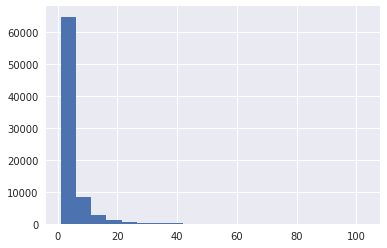

In [52]:
Perf_sub['num_of_orders'].hist(bins=20)

In [46]:
17866/Perf_sub.shape[0]

0.22707745494293194

In [ ]:
Perf_sub = Perf[Perf['Year_and_Month'].dt.date<=Perf['time_window']]

In [81]:
Perf_order_final = Perf_sub.loc[Perf_sub.groupby('Unique_Order_ID')['Ever_Bad'].idxmax()]

In [82]:
Perf_flag = Perf_order_final.groupby('Unique_Customer_ID').agg(
    {'Unique_Order_ID': 'count', 'Ever_Bad': 'sum'}).reset_index()

In [83]:
Perf_flag['Bad'] = Perf_flag['Ever_Bad']>=1

In [84]:
Perf_flag.rename(columns = {'Unique_Order_ID':'num_of_orders'},inplace = True)

In [134]:
Perf_order_final.shape

(1766836, 56)

In [132]:
Perf_flag['Bad'].value_counts()

False    550867
True      22242
Name: Bad, dtype: int64

In [ ]:
# Date Format
# Performance
"""
Year_and_Month
Date_account_went_delinquent
Order_Date
"""

# Customer
"""
Enrollment_Date
"""

# Client

"""
Launch Date
Termination Date
"""

In [ ]:
# $Numeric Format
# Performance
"""
Order_Amount
Product_Markup
Payments_Due
Current_Balance
Losses
Spending_Limit_at_time_of_Order
Tenure_at_time_of_Order
Salary_at_time_of_Order
"""


In [181]:
Perf_order_final['Unique_Customer_ID'].nunique()

573109

In [ ]:
# Create # of orders by Customer

In [86]:
Perf.shape

(39155989, 56)

In [61]:
Perf[['Enrollment_Date','time_window']].head()

Enrollment_Date time_window
0      2014-02-24  2015-08-24
1      2014-02-24  2015-08-24
2      2014-02-24  2015-08-24
3      2014-02-24  2015-08-24
4      2014-02-24  2015-08-24

In [62]:
Customer[Customer['Customer_Salary']==0].shape

(1562, 14)

In [66]:
Customer['Customer_Salary'].isnull().sum()

67794

In [64]:
Customer.loc[Customer['Customer_Salary']=='.']

Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure Customer_Salary Prior_Customer_Flag                           Street1            Street2               City State    Zip       Status   Term_Date
610153           100766090               2161      02/25/2014                   2100.0            149.0               .     First Time Byer                   2058 HWY 438  E                NaN         LOBELVILLE    TN  37097     Employed           .
610162           100821035               2183      02/25/2014                   3000.0            320.0               .        Repeat Buyer                    2320 MARIE WAY                NaN         CARMICHAEL    CA  95608     Employed           .
610175           138201925               2521      02/24/2014                   2900.0            123.0               .        Repeat Buyer             770 EAST 165TH STREET             APT 1H              BRONX    NY  10456     Employed           .
610275           300159528               2183      05/13/2014                   3000.0            119.0               .     First Time Byer                 362 S STAFFORD CT                NaN             TULARE    CA  93274     Employed           .
610277           300165297               2161      05/16/2014                   2100.0             95.0               .     First Time Byer                      32 PRINCE DR                NaN            JACKSON    TN  38301     Employed           .
610283           300205628               2161      07/14/2014                   2100.0            250.0               .     First Time Byer                 3347 DOUGLASS AVE                NaN            MEMPHIS    TN  38111     Employed           .
610300           300310783               2377      10/03/2014                   1650.0             75.0               .     First Time Byer           851042 HOOLOKAHI STREET                NaN            WAIANAE    HI  96792     Employed           .
610326           300492060               2377      12/03/2014                   1650.0            153.0               .     First Time Byer                      832 OHIO AVE             APT 11         LONG BEACH    CA  90804     Employed           .
610359           300641298               2404      04/03/2015                   2000.0            306.0               .     First Time Byer                     390 WRIGHT RD                NaN            POTSDAM    NY  13676     Employed           .
610367           300690354               2377      05/17/2015                   1650.0             38.0               .     First Time Byer      14557 SPOTTED SANDPIPER BLVD                NaN      WINTER GARDEN    FL  34787     Employed           .
610370           300711531               2404      06/07/2015                   2000.0            211.0               .     First Time Byer                  186 SARATOGA AVE                NaN           BROOKLYN    NY  11233     Employed           .
610376           300741980               2404      07/04/2015                   2000.0             70.0               .     First Time Byer                     12 NEWCOMB ST                NaN         QUEENSBURY    NY  12804     Employed           .
610397           300836774               2404      08/21/2015                   2000.0            465.0               .     First Time Byer                        23 GLEN DR                NaN               TROY    NY  12180     Employed           .
610410           300869169               2377      09/23/2015                   1650.0             61.0               .     First Time Byer            4615 N BELLFLOWER BLVD              APT 8         LONG BEACH    CA  90808     Employed           .
610427           301041304               2183      11/04/2015                   3000.0             68.0               .     First Time Byer                 2997 LAWRENCE AVE                NaN     SAN BERNARDINO    CA  92404     Employed           .
610455  

In [65]:
Customer.loc[Customer['Customer_Salary']=='.', 'Customer_Salary']= np.nan

In [67]:
Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)

In [68]:
Customer.shape

(619753, 14)

In [69]:
Customer_sub = Customer[Customer['Customer_Salary']>0]

In [70]:
Customer_sub['Unique_Customer_ID'].nunique()

550396

In [71]:
Customer_sub.shape

(550396, 14)

In [72]:
Customer_sub.head()

Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                 Street1 Street2           City State    Zip    Status Term_Date
0           100001115               1000      02/24/2014                   6880.0            230.0          58229.0        Repeat Buyer          1471 N EAST ST     NaN           YORK    PA  17406  Employed       NaN
1           100001120               1000      02/24/2014                   6520.0            362.0         109245.0        Repeat Buyer         94 Brentwood Ln     NaN  Valley Stream    NY  11581  Employed       NaN
2           100001141               1000      02/25/2014                  10290.0            337.0         127226.0        Repeat Buyer  103 KENILWORTH PARK DR  APT 2B         TOWSON    MD  21204  Employed       NaN
3           100001158               1000      02/24/2014                   5190.0            419.0          49375.0        Repeat Buyer       1036 Braddish Ave     NaN      Baltimore    MD  21216  Employed       NaN
4           100001169               1000      02/24/2014                   7500.0            448.0          69460.0        Repeat Buyer       3915 W ROGERS AVE     NaN      BALTIMORE    MD  21215  Employed       NaN

In [119]:
Customer_sub = Perf_sub[['Unique_Customer_ID', 'Bad', 'num_of_orders']].merge(Customer, how='left', on='Unique_Customer_ID')

In [73]:
Customer_sub = Customer_sub.merge(
    Perf_sub[['Unique_Customer_ID', 'Bad', 'num_of_orders']], how='left', on='Unique_Customer_ID')

In [120]:
Customer_sub.shape

(78678, 16)

In [121]:
Customer_sub.head()

Unique_Customer_ID    Bad  num_of_orders  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag             Street1 Street2          City State    Zip       Status Term_Date
0           302641212  False              1               2183      04/01/2017                   7260.0            317.0         47196.00     First Time Byer    214 S KESSING ST     NaN   PORTERVILLE    CA  93257     Employed       NaN
1           302641217  False              1               2302      04/01/2017                    500.0             44.0         11804.00     First Time Byer     6580 MORET DR S     NaN  JACKSONVILLE    FL  32244  Direct Bill       NaN
2           302641220  False              3               2250      04/01/2017                   2940.0             34.0         34037.38        Repeat Buyer      2967 GORDON RD     NaN     ROCK HILL    SC  29732     Employed       NaN
3           302641222  False             15               2425      04/01/2017                   3065.0             43.0         35495.09        Repeat Buyer  9231 S CYPRESS CIR     NaN       MIRAMAR    FL  33025     Employed       NaN
4           302641226  False             13               2464      04/01/2017                   1500.0             33.0         55823.00        Repeat Buyer  2266 S HARWOOD AVE     NaN   UPPER DARBY    PA  19082  Direct Bill       NaN

In [77]:
Perf_p12m.head()

Unique_Order_ID  Unique_Customer_ID  Order_Amount Product_Markup Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket  Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment Spending_Limit_at_time_of_Order Tenure_at_time_of_Order Salary_at_time_of_Order                    Street1_x Street2_x  City_x State_x    Zip_x                                      Items_Ordered Year_and_Month Customer_Status  Order_Date      YQ  Year  Payment_Order  Bad  Ever_Bad  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure Customer_Salary Prior_Customer_Flag          Street1_y       Street2_y       City_y State_y  Zip_y    Status Term_Date  2os_loss time_window
1087004  SSAMEYE1219618           301788754        2909.7              .       111.91          2901.08                            .        Current            000-000     0.0                  PD                 N                    ACH                              42                      42                  614.46  2050 NEWNAN CROSSING BLVD E  APT 5307  NEWNAN      GA  30265.0  SquareTrade 3-Year Appliance Warranty; Samsung...     2013-05-01        Employed  05/03/2013  2013Q2  2013            1.0    0         0             1000.0      2016-10-18                   4200.0             42.0           61446        Repeat Buyer  5010 CONSTANCE ST  Apartment 5307  NEW ORLEANS      LA  70115  Employed       NaN       0.0  2018-04-18
1087005  SSAMEYE1219618           301788754        2909.7              .       111.91          2863.08                            .        Current            000-000     0.0                  PD                 N                    ACH                              42                      42                  614.46  2050 NEWNAN CROSSING BLVD E  APT 5307  NEWNAN      GA  30265.0  SquareTrade 3-Year Appliance Warranty; Samsung...     2013-06-01        Employed  05/03/2013  2013Q2  2013            2.0    0         0             1000.0      2016-10-18                   4200.0             42.0           61446        Repeat Buyer  5010 CONSTANCE ST  Apartment 5307  NEW ORLEANS      LA  70115  Employed       NaN       0.0  2018-04-18
1087006  SSAMEYE1219618           301788754        2909.7              .       111.91          2825.08                            .        Current            000-000     0.0                  PD                 N                    ACH                              42                      42                  614.46  2050 NEWNAN CROSSING BLVD E  APT 5307  NEWNAN      GA  30265.0  SquareTrade 3-Year Appliance Warranty; Samsung...     2013-07-01        Employed  05/03/2013  2013Q3  2013            3.0    0         0             1000.0      2016-10-18                   4200.0             42.0           61446        Repeat Buyer  5010 CONSTANCE ST  Apartment 5307  NEW ORLEANS      LA  70115  Employed       NaN       0.0  2018-04-18
1087007  SSAMEYE1219618           301788754        2909.7              .       111.91          2612.36                            .        001-030            001-030     0.0                  PD                 N                    ACH                              42                      42                  614.46  2050 NEWNAN CROSSING BLVD E  APT 5307  NEWNAN      GA  30265.0  SquareTrade 3-Year Appliance Warranty; Samsung...     2013-08-01        Employed  05/03/2013  2013Q3  2013            4.0    0         0             1000.0      2016-10-18                   4200.0             42.0           61446        Repeat Buyer  5010 CONSTANCE ST  Apartment 5307  NEW ORLEANS      LA  70115  Employed       NaN       0.0  2018-04-18
1087008  SSAMEYE1219618           301788754        2909.7              .       111.91          2205.08                            .        Current            000-000     0.0                  PD                 N                    ACH                              42                      42                  614.46  2050 NEWNAN CROSS

In [20]:
Perf_p12m = Perf[(Perf['Year_and_Month'] <= pd.to_datetime('2017-04'))              
                & (Perf['Year_and_Month'] >= pd.to_datetime('2016-04'))]

In [90]:
Perf_p12m.shape

(6228054, 45)

In [91]:
client_loss = Perf_p12m[(Perf_p12m['Bad'] == 1) & (
    Perf_p12m['Ever_Bad'] <= 1)].groupby('Unique_Company_ID')['2os_loss'].sum().reset_index()

In [92]:
client_order_vol = Perf_p12m.groupby(['Unique_Company_ID', 'Unique_Order_ID']).head(
    1).groupby('Unique_Company_ID')['Order_Amount'].sum().reset_index()

In [93]:
client_loss_m = client_loss.merge(client_order_vol, how='right',on='Unique_Company_ID')

In [94]:
client_loss_m.head()

Unique_Company_ID   2os_loss  Order_Amount
0             1000.0  216952.58   11253752.99
1             1200.0   17430.36     726208.21
2             1301.0      60.60       6820.50
3             1302.0    2399.02      57143.76
4             1500.0   29892.92    6635630.02

In [95]:
client_loss_m['loss_rate'] = client_loss_m['2os_loss']/client_loss_m['Order_Amount']

In [100]:
client_loss_m =  client_loss_m.fillna(0)

In [101]:
client_loss_m.head()

Unique_Company_ID   2os_loss  Order_Amount  loss_rate
0             1000.0  216952.58   11253752.99   0.019278
1             1200.0   17430.36     726208.21   0.024002
2             1301.0      60.60       6820.50   0.008885
3             1302.0    2399.02      57143.76   0.041982
4             1500.0   29892.92    6635630.02   0.004505

In [102]:
client_loss_m['loss_rate'].describe()

count    379.000000
mean       0.033877
std        0.040398
min        0.000000
25%        0.003960
50%        0.027338
75%        0.043420
max        0.330952
Name: loss_rate, dtype: float64

In [115]:
client_loss_m['Unique_Company_ID'].nunique()

379

In [103]:
client_loss_m.shape

(379, 4)

In [104]:
client_order_vol['Order_Amount'].isnull().any()

False

In [198]:
list(client_loss_m)

['Client ID', '2os_loss', 'Order_Amount', 'loss_rate']

In [122]:
Customer_sub = Customer_sub.merge(client_loss_m, how = 'left',on= 'Unique_Company_ID')

In [123]:
Customer_sub.shape

(78678, 19)

In [124]:
Customer_sub.head()

Unique_Customer_ID    Bad  num_of_orders  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag             Street1 Street2          City State    Zip       Status Term_Date    2os_loss  Order_Amount  loss_rate
0           302641212  False              1               2183      04/01/2017                   7260.0            317.0         47196.00     First Time Byer    214 S KESSING ST     NaN   PORTERVILLE    CA  93257     Employed       NaN   535242.50   25245750.88   0.021201
1           302641217  False              1               2302      04/01/2017                    500.0             44.0         11804.00     First Time Byer     6580 MORET DR S     NaN  JACKSONVILLE    FL  32244  Direct Bill       NaN  1299145.01   38851808.71   0.033438
2           302641220  False              3               2250      04/01/2017                   2940.0             34.0         34037.38        Repeat Buyer      2967 GORDON RD     NaN     ROCK HILL    SC  29732     Employed       NaN  1125263.73   28018760.09   0.040161
3           302641222  False             15               2425      04/01/2017                   3065.0             43.0         35495.09        Repeat Buyer  9231 S CYPRESS CIR     NaN       MIRAMAR    FL  33025     Employed       NaN   188214.18    2734554.89   0.068828
4           302641226  False             13               2464      04/01/2017                   1500.0             33.0         55823.00        Repeat Buyer  2266 S HARWOOD AVE     NaN   UPPER DARBY    PA  19082  Direct Bill       NaN     3459.15    1689933.59   0.002047

In [125]:
Customer_sub[Customer_sub['loss_rate'].isnull()]['Unique_Company_ID'].nunique()

24

In [126]:
Customer_sub['Unique_Company_ID'].nunique()

323

In [116]:
Customer_sub[Customer_sub['loss_rate'].isnull()].shape

(7249, 19)

In [128]:
Customer_sub.shape

(78678, 19)

In [129]:
Customer_sub['Unique_Customer_ID'].nunique()

78678

In [130]:
Customer_sub['Customer_Tenure'].isnull().sum()

5

In [131]:
Customer_sub[Customer_sub['Customer_Tenure'].isnull()]['Bad'].sum()

0

In [132]:
Customer_sub[Customer_sub['Customer_Tenure']==0]

Empty DataFrame
Columns: [Unique_Customer_ID, Bad, num_of_orders, Unique_Company_ID, Enrollment_Date, Assigned_Spending_Limit, Customer_Tenure, Customer_Salary, Prior_Customer_Flag, Street1, Street2, City, State, Zip, Status, Term_Date, 2os_loss, Order_Amount, loss_rate]
Index: []

In [133]:
Customer_sub[Customer_sub['Assigned_Spending_Limit']==0]['Bad'].sum()#.shape[0]

164

In [138]:
Customer_sub[Customer_sub['Assigned_Spending_Limit']==0].shape

(3305, 19)

In [135]:
Customer_sub['Assigned_Spending_Limit'].isnull().sum()

0

In [136]:
Customer_sub['Customer_Salary'].isnull().sum()

4792

In [137]:
Customer_sub[Customer_sub['Customer_Salary']==0].shape[0]

14

In [149]:
Customer_sub[Customer_sub['Customer_Salary']>494]['Customer_Salary'].min()

518.0

In [159]:
Customer_sub[Customer_sub['Customer_Salary']<3000][['Customer_Salary','Assigned_Spending_Limit']]

Customer_Salary  Assigned_Spending_Limit
14208           722.00                    500.0
18575          2730.00                    500.0
23048          2600.00                    500.0
25349           549.00                    700.0
25696           518.00                    770.0
34531           493.74                    700.0
38791          2308.00                    700.0

In [157]:
Customer_sub[Customer_sub['Customer_Salary']<=Customer_sub['Assigned_Spending_Limit']]

Unique_Customer_ID    Bad  num_of_orders  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                     Street1   Street2            City State    Zip      Status   Term_Date   2os_loss  Order_Amount  loss_rate
25349           302962020  False              4               2238      08/09/2017                    700.0             31.0           549.00        Repeat Buyer         2006 W ALGONQUIN RD    APT 8A  MOUNT PROSPECT    IL  60056  Terminated  08/05/2019  481185.81   21590296.33   0.022287
25696           302963516  False              2               2238      08/12/2017                    770.0             28.0           518.00        Repeat Buyer  10537 Park Meadowbrooke Dr       NaN       Riverview    FL  33578    Employed         NaN  481185.81   21590296.33   0.022287
34531           303277535  False              1               2238      09/30/2017                    700.0             32.0           493.74     First Time Byer             527 W REGENT ST  UNIT 228       INGLEWOOD    CA  90301    Employed         NaN  481185.81   21590296.33   0.022287

In [160]:
Customer_sub = Customer_sub[(Customer_sub['Customer_Tenure'].notnull()) & (Customer_sub['loss_rate'].notnull()) & (
    Customer_sub['Assigned_Spending_Limit'] != 0) & (Customer_sub['Customer_Salary']>2000) &(Customer_sub['Customer_Salary']!=9999999.99)]

In [161]:
Customer_sub[['Customer_Tenure','Customer_Salary','Assigned_Spending_Limit','loss_rate']].describe()

Customer_Tenure  Customer_Salary  Assigned_Spending_Limit     loss_rate
count     72114.000000     72114.000000             72114.000000  72114.000000
mean         79.739163     41366.879206              3657.074340      0.027662
std          71.242136     19452.198669              2228.528054      0.025671
min           1.000000      2308.000000               400.000000      0.000000
25%          38.000000     29827.200000              1875.000000      0.003585
50%          50.000000     35736.345000              3260.000000      0.033245
75%          90.000000     47822.735000              4915.000000      0.035308
max         634.000000    762720.000000             13160.000000      0.316066

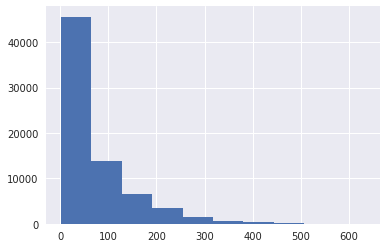

In [162]:
Customer_sub['Customer_Tenure'].hist()

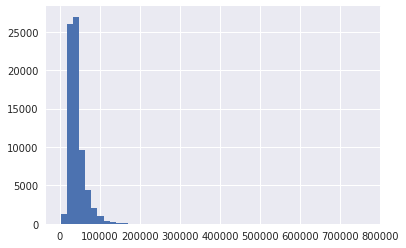

In [163]:
Customer_sub['Customer_Salary'].hist(bins=50)

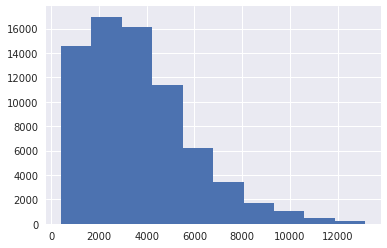

In [164]:
Customer_sub['Assigned_Spending_Limit'].hist()

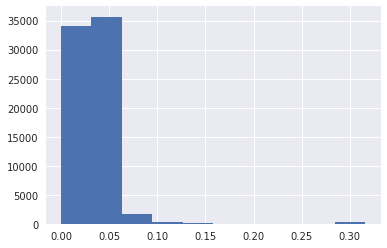

In [165]:
Customer_sub['loss_rate'].hist()

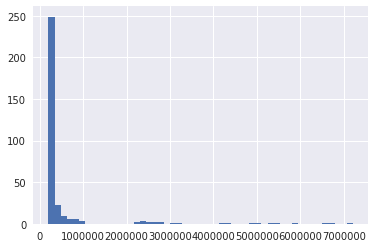

In [222]:
Customer_sub[Customer_sub['Customer_Salary']>200000]['Customer_Salary'].hist(bins=50)

In [121]:
Customer_sub[Customer_sub['loss_rate']>0.2].shapeh

(221, 31)

In [156]:
# Customer_sub[['Customer_Salary','Assigned_Spending_Limit']].plot()

In [166]:
test = Customer_sub[['Unique_Customer_ID','Customer_Tenure','Customer_Salary','Assigned_Spending_Limit','loss_rate','Bad']]

In [167]:
test.rename(columns = {'loss_rate':'Client_Loss_Rate_p12m'},inplace = True)

In [193]:
test['limit_over_salary'] = test['Assigned_Sxpending_Limit']/test['Customer_Salary']

In [209]:
test.head()

Unique_Customer_ID  Customer_Tenure  Customer_Salary  Assigned_Spending_Limit  Client_Loss_Rate_p12m    Bad     Customer_Salary_bin Customer_Tenure_bin Spending_Limit_bin Client_Loss_Rate_p12m_bin  limit_over_salary limit_over_salary_bin
0           302641212            317.0         47196.00                   7260.0               0.021201  False  (35736.345, 47822.735]       (90.0, 634.0]  (5620.0, 13160.0]         (0.00359, 0.0332]           0.153827        (0.108, 0.303]
1           302641217             44.0         11804.00                    500.0               0.033438  False     (2307.999, 29827.2]        (38.0, 50.0]  (399.999, 1445.0]          (0.0332, 0.0353]           0.042359     (0.00608, 0.0608]
2           302641220             34.0         34037.38                   2940.0               0.040161  False    (29827.2, 35736.345]       (0.999, 38.0]   (2330.0, 3260.0]           (0.0353, 0.316]           0.086376       (0.0842, 0.108]
3           302641222             43.0         35495.09                   3065.0               0.068828  False    (29827.2, 35736.345]        (38.0, 50.0]   (2330.0, 3260.0]           (0.0353, 0.316]           0.086350       (0.0842, 0.108]
4           302641226             33.0         55823.00                   1500.0               0.002047  False   (47822.735, 762720.0]       (0.999, 38.0]   (1445.0, 2330.0]         (-0.001, 0.00359]           0.026871     (0.00608, 0.0608]

In [220]:
Customer_sub['limit_over_salary'] = Customer_sub['Assigned_Spending_Limit']/Customer_sub['Customer_Salary']
Customer_sub[Customer_sub['limit_over_salary']>=0.108]

Unique_Customer_ID    Bad  num_of_orders  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                      Street1            Street2                 City State    Zip       Status   Term_Date    2os_loss  Order_Amount  loss_rate  limit_over_salary
0               302641212  False              1               2183      04/01/2017                  7260.00            317.0     47196.000000     First Time Byer             214 S KESSING ST                NaN          PORTERVILLE    CA  93257     Employed         NaN   535242.50  2.524575e+07   0.021201           0.153827
5               302641227  False              1               2192      04/01/2017                  4435.00             38.0     36758.000000     First Time Byer            5101 LUCYDALE AVE                NaN        NORTH OLMSTED    OH  44070     Employed         NaN   104748.88  4.141117e+06   0.025295           0.120654
6               302641237  False              1               2184      04/01/2017                  8995.00            238.0     59000.000000     First Time Byer            11720 Passage Way            Apt 129           Cincinnati    OH  45240     Employed         NaN   206862.71  1.046163e+07   0.019773           0.152458
12              302641291   True              3               2342      04/01/2017                  4135.00             35.0     38147.200000        Repeat Buyer              945 N Eaton ave                NaN         Indianapolis    IN  46219     Employed         NaN   300497.67  5.462503e+06   0.055011           0.108396
14              302641294  False              1               2422      04/01/2017                  3670.00            161.0     29120.000000     First Time Byer                180 W WIND DR                NaN              NEWBERN    TN  38059  Direct Bill         NaN   548683.01  1.554010e+07   0.035308           0.126030
15              302641297   True              1               2478      04/01/2017                  3375.00             26.0     30506.110000     First Time Byer             601 PINE GLEN DR                NaN               ALBANY    GA  31705   Terminated  03/26/2019       34.46  8.727187e+05   0.000039           0.110634
19              302641313  False              8               2184      04/02/2017                  5330.00             41.0     42000.000000        Repeat Buyer                6353 BRENT CT                NaN         REYNOLDSBURG    OH  43068     Employed         NaN   206862.71  1.046163e+07   0.019773           0.126905
21              302641322   True              3               2250      04/02/2017                  6000.00             57.0     54080.000000        Repeat Buyer      130 S Massachusetts ave               A805             Lakeland    FL  33801   Terminated  03/16/2018  1125263.73  2.801876e+07   0.040161           0.110947
23              302641331  False              2               2316      04/02/2017                  5960.00             71.0     44724.000000        Repeat Buyer  15403 FOREST CREEK FARMS DR                NaN              CYPRESS    TX  77429     Employed         NaN    61756.56  1.620210e+06   0.038116           0.133262
24              302642226   True              1               2250      04/01/2017                  5150.00             94.0     41267.200000     First Time Byer                422 CARVIN ST                NaN              CLAYTON    NJ   8312  Direct Bill         NaN  1125263.73  2.801876e+07   0.040161           0.124796
25              302642227  False              2               2149      04/01/2017                  5205.00             60.0     47547.000000        Repeat Buyer                216 e 10th st                NaN           storm lake    IA  50588     Employed         NaN   972606.67  1.977884e+07   0.049174           0.109471
30              302642257  False             13               2404      04/01/2017                  4675.00

In [224]:
Customer_sub['limit_over_salary'] = Customer_sub['Assigned_Spending_Limit']/Customer_sub['Customer_Salary']
Customer_sub[Customer_sub['limit_over_salary']>=0.108]['Customer_Salary'].describe()

count     18131.000000
mean      44444.262852
std       14454.301445
min        2308.000000
25%       35211.530000
50%       40812.000000
75%       50644.255000
max      117916.000000
Name: Customer_Salary, dtype: float64

In [212]:
Customer_sub.shape

(72114, 19)

In [169]:
Customer_sub['Unique_Customer_ID'].nunique()

72114

In [204]:
Customer_sub['Bad'].value_counts()

False    54935
True     17179
Name: Bad, dtype: int64

In [203]:
Customer_sub.groupby(['Bad'])['num_of_orders'].mean()

Bad
False    4.634149
True     3.121835
Name: num_of_orders, dtype: float64

In [195]:
def view(var,df):
    print('Spending Limit by {}'.format(var))
    df[var+'_bin'] = pd.qcut(test[var], q=4)
    return df.groupby(var+'_bin').agg({'Assigned_Spending_Limit':'mean','Unique_Customer_ID':'count'}).round(2)

In [196]:
view('Customer_Salary',test)

Spending Limit by Customer_Salary


Assigned_Spending_Limit  Unique_Customer_ID
Customer_Salary_bin                                                
(2307.999, 29827.2]                     1604.71               18039
(29827.2, 35736.345]                    2721.52               18018
(35736.345, 47822.735]                  4045.42               18028
(47822.735, 762720.0]                   6257.23               18029

In [197]:
view('Customer_Tenure',test)

Spending Limit by Customer_Tenure


Assigned_Spending_Limit  Unique_Customer_ID
Customer_Tenure_bin                                             
(0.999, 38.0]                        2953.70               19593
(38.0, 50.0]                         3025.36               16596
(50.0, 90.0]                         3811.42               17938
(90.0, 634.0]                        4852.19               17987

In [182]:
view('Client_Loss_Rate_p12m',test)

Spending Limit by Client_Loss_Rate_p12m


Assigned_Spending_Limit  Unique_Customer_ID
Client_Loss_Rate_p12m_bin                                             
(-0.001, 0.00359]                          3152.33               18143
(0.00359, 0.0332]                          4341.43               18895
(0.0332, 0.0353]                           3667.06               18493
(0.0353, 0.316]                            3418.40               16583

In [188]:
def risk_view(var,df):
    print('Bad Rate by {}'.format(var))
    df[var+'_bin'] = pd.qcut(test[var], q=4)
    return df.groupby(var+'_bin')['Bad'].sum().div(df.groupby(var+'_bin')['Unique_Customer_ID'].size())

In [189]:
risk_view('Customer_Salary',test)

Bad Rate by Customer_Salary


Customer_Salary_bin
(2307.999, 29827.2]       0.363158
(29827.2, 35736.345]      0.273837
(35736.345, 47822.735]    0.178056
(47822.735, 762720.0]     0.137778
dtype: float64

In [190]:
risk_view('Customer_Tenure',test)

Bad Rate by Customer_Tenure


Customer_Tenure_bin
(0.999, 38.0]    0.281733
(38.0, 50.0]     0.313027
(50.0, 90.0]     0.228398
(90.0, 634.0]    0.131595
dtype: float64

In [191]:
risk_view('Client_Loss_Rate_p12m',test)

Bad Rate by Client_Loss_Rate_p12m


Client_Loss_Rate_p12m_bin
(-0.001, 0.00359]    0.226423
(0.00359, 0.0332]    0.190315
(0.0332, 0.0353]     0.246147
(0.0353, 0.316]      0.296870
dtype: float64

In [199]:
risk_view('limit_over_salary',test)

Bad Rate by limit_over_salary


limit_over_salary_bin
(0.00608, 0.0608]    0.328138
(0.0608, 0.0842]     0.245216
(0.0842, 0.108]      0.233790
(0.108, 0.303]       0.145726
dtype: float64

In [200]:
print('Bad Rate vs Spending Limit')
test['Spending_Limit_bin'] = pd.qcut(test['Assigned_Spending_Limit'], q=6)
test.groupby('Spending_Limit_bin')['Bad'].sum().div(test.groupby('Spending_Limit_bin')['Unique_Customer_ID'].size())

Bad Rate vs Spending Limit


Spending_Limit_bin
(399.999, 1445.0]    0.367015
(1445.0, 2330.0]     0.313652
(2330.0, 3260.0]     0.269077
(3260.0, 4335.0]     0.213520
(4335.0, 5620.0]     0.154103
(5620.0, 13160.0]    0.108509
dtype: float64